<a href="https://colab.research.google.com/github/always-reach/GAN/blob/dcgan/gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
from tensorflow.keras import Sequential,datasets
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense,Flatten,LeakyReLU,BatchNormalization,Reshape,Convolution2D,Dropout,MaxPooling2D,Activation,UpSampling2D
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

In [49]:
class DCGAN():
  def __init__(self):
    #mnist画像の幅
    self.image_row=28
    #mnist画像の高さ
    self.image_col=28
    #mnist画像のチャンネル数
    self.channels=1
    self.image_shape=(self.image_row,self.image_col,self.channels)
    #入力ノイズの次元数
    self.z_input_dim=100
    #最適化アルゴリズムはAdam
    optimizer=Adam()

    self.discriminator=self.build_discriminator()
    self.discriminator.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=["accuracy"])

    self.generator=self.build_generator()
    self.combined=self.build_combined()
    self.combined.compile(loss='binary_crossentropy',optimizer=optimizer)

  def build_discriminator(self):
    model = Sequential()
    model.add(Convolution2D(32, kernel_size=(3, 3), input_shape=self.image_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Convolution2D(64, (3, 3)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))   
    model.summary()

    return model

  def build_generator(self):
    noise_shape=(self.z_input_dim,)
    model = Sequential()
    model.add(Dense(1024,input_shape=noise_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(128*7*7))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    #入力のノイズデータが1次元のため、Reshapeで3次元データに変換
    model.add(Reshape(target_shape=(7,7,128),input_shape=(128*7*7,)))
    model.add(UpSampling2D(size=(2,2)))
    model.add(Convolution2D(filters=64,kernel_size=2,strides=1,padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(UpSampling2D(size=(2,2)))
    model.add(Convolution2D(filters=1,kernel_size=2,strides=1,padding='same',activation='tanh'))
    model.summary()
    
    return model

  def build_combined(self):
    self.discriminator.trainable=False
    model=Sequential([self.generator,self.discriminator])
    return model

  def train(self,epochs,batch_size=128,save_interval=100):
    print("training start")
    (x_train,y_train),(x_test,y_test)=datasets.mnist.load_data()
    x_train=(x_train.astype(np.float32)-127.5)/127.5
    x_train=np.expand_dims(x_train,axis=3)

    half_batch=int(batch_size/2)

    for epoch in range(epochs):
      noise=np.random.normal(0,1,(half_batch,self.z_input_dim))
      gen_images=self.generator.predict(noise)
      index=np.random.randint(0,x_train.shape[0],half_batch)
      images=x_train[index]
      d_loss_real=self.discriminator.train_on_batch(images,np.ones((half_batch,1)))
      d_loss_fake=self.discriminator.train_on_batch(gen_images,np.zeros((half_batch,1)))

      d_loss=0.5*np.add(d_loss_real,d_loss_fake)

      noise=np.random.normal(0,1,(batch_size,self.z_input_dim))
      valid_y=np.array([1]*batch_size)
      g_loss=self.combined.train_on_batch(noise,valid_y)

      print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

      if (epoch+1) % save_interval==0:
        plt.figure(figsize=(10,10))
        x = gen_images[:10]
        for i in range(10):
          plt.subplot(1,10, i+1)
          # 画像を見やすいように座標軸を非表示にする。
          plt.axis("off")
          # 画像を表示
          plt.imshow(x[i].reshape([28,28]), cmap='gray')
        plt.tight_layout()
        plt.show()


Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_75 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 leaky_re_lu_63 (LeakyReLU)  (None, 26, 26, 32)        0         
                                                                 
 conv2d_76 (Conv2D)          (None, 24, 24, 64)        18496     
                                                                 
 leaky_re_lu_64 (LeakyReLU)  (None, 24, 24, 64)        0         
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 12, 12, 64)       0         
 g2D)                                                            
                                                                 
 dropout_42 (Dropout)        (None, 12, 12, 64)        0         
                                                     

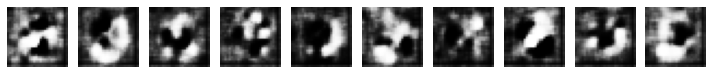

100 [D loss: 0.030155, acc.: 100.00%] [G loss: 0.640285]
101 [D loss: 0.043702, acc.: 100.00%] [G loss: 0.868235]
102 [D loss: 0.052712, acc.: 98.44%] [G loss: 0.879541]
103 [D loss: 0.110019, acc.: 94.53%] [G loss: 0.722989]
104 [D loss: 0.072716, acc.: 99.22%] [G loss: 0.561636]
105 [D loss: 0.089314, acc.: 99.22%] [G loss: 0.355729]
106 [D loss: 0.146283, acc.: 97.66%] [G loss: 0.533783]
107 [D loss: 0.157835, acc.: 95.31%] [G loss: 0.822127]
108 [D loss: 0.117082, acc.: 97.66%] [G loss: 1.657942]
109 [D loss: 0.263496, acc.: 87.50%] [G loss: 1.179778]
110 [D loss: 0.488967, acc.: 78.12%] [G loss: 0.350865]
111 [D loss: 0.302046, acc.: 86.72%] [G loss: 0.806309]
112 [D loss: 0.382890, acc.: 86.72%] [G loss: 1.310230]
113 [D loss: 0.511147, acc.: 79.69%] [G loss: 0.508740]
114 [D loss: 0.447789, acc.: 78.12%] [G loss: 0.466467]
115 [D loss: 0.286504, acc.: 90.62%] [G loss: 1.091989]
116 [D loss: 0.482944, acc.: 79.69%] [G loss: 0.821359]
117 [D loss: 0.476265, acc.: 79.69%] [G loss: 

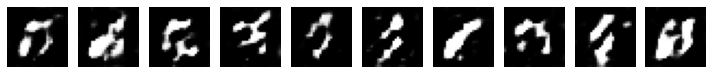

200 [D loss: 0.431008, acc.: 82.03%] [G loss: 0.752916]
201 [D loss: 0.319477, acc.: 84.38%] [G loss: 0.651162]
202 [D loss: 0.423279, acc.: 80.47%] [G loss: 0.758705]
203 [D loss: 0.362319, acc.: 82.81%] [G loss: 0.821487]
204 [D loss: 0.361452, acc.: 82.03%] [G loss: 1.073848]
205 [D loss: 0.289470, acc.: 85.16%] [G loss: 1.109452]
206 [D loss: 0.416124, acc.: 83.59%] [G loss: 0.901825]
207 [D loss: 0.441869, acc.: 82.03%] [G loss: 0.725726]
208 [D loss: 0.444283, acc.: 83.59%] [G loss: 1.017624]
209 [D loss: 0.353686, acc.: 87.50%] [G loss: 1.391834]
210 [D loss: 0.485252, acc.: 78.91%] [G loss: 1.525671]
211 [D loss: 0.645848, acc.: 73.44%] [G loss: 1.222705]
212 [D loss: 0.449658, acc.: 78.91%] [G loss: 1.239480]
213 [D loss: 0.597048, acc.: 71.09%] [G loss: 1.337199]
214 [D loss: 0.489928, acc.: 78.91%] [G loss: 1.354396]
215 [D loss: 0.440685, acc.: 80.47%] [G loss: 1.333745]
216 [D loss: 0.467044, acc.: 78.12%] [G loss: 1.282906]
217 [D loss: 0.451401, acc.: 77.34%] [G loss: 1.

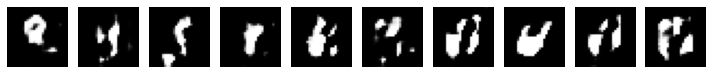

300 [D loss: 0.436240, acc.: 84.38%] [G loss: 1.215577]
301 [D loss: 0.561264, acc.: 76.56%] [G loss: 0.751029]
302 [D loss: 0.326018, acc.: 85.94%] [G loss: 1.022582]
303 [D loss: 0.219347, acc.: 94.53%] [G loss: 1.444194]
304 [D loss: 0.286710, acc.: 91.41%] [G loss: 1.448582]
305 [D loss: 0.303182, acc.: 89.06%] [G loss: 1.186077]
306 [D loss: 0.262997, acc.: 87.50%] [G loss: 0.777820]
307 [D loss: 0.285585, acc.: 90.62%] [G loss: 0.590696]
308 [D loss: 0.290893, acc.: 89.06%] [G loss: 0.616360]
309 [D loss: 0.247637, acc.: 89.84%] [G loss: 0.831008]
310 [D loss: 0.189520, acc.: 93.75%] [G loss: 1.230524]
311 [D loss: 0.284166, acc.: 91.41%] [G loss: 1.035078]
312 [D loss: 0.212926, acc.: 93.75%] [G loss: 0.876853]
313 [D loss: 0.184452, acc.: 93.75%] [G loss: 0.762191]
314 [D loss: 0.156765, acc.: 95.31%] [G loss: 0.796631]
315 [D loss: 0.260951, acc.: 89.84%] [G loss: 0.854304]
316 [D loss: 0.200241, acc.: 94.53%] [G loss: 0.987385]
317 [D loss: 0.214369, acc.: 95.31%] [G loss: 0.

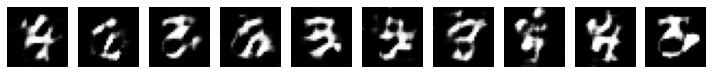

400 [D loss: 0.413364, acc.: 78.91%] [G loss: 1.409009]
401 [D loss: 0.273707, acc.: 88.28%] [G loss: 1.363798]
402 [D loss: 0.290761, acc.: 85.16%] [G loss: 1.360532]
403 [D loss: 0.264545, acc.: 89.06%] [G loss: 2.028950]
404 [D loss: 0.293352, acc.: 88.28%] [G loss: 1.818654]
405 [D loss: 0.345379, acc.: 82.81%] [G loss: 1.035101]
406 [D loss: 0.320213, acc.: 85.16%] [G loss: 0.891450]
407 [D loss: 0.331352, acc.: 87.50%] [G loss: 1.306580]
408 [D loss: 0.337755, acc.: 84.38%] [G loss: 1.734246]
409 [D loss: 0.307935, acc.: 84.38%] [G loss: 1.395211]
410 [D loss: 0.356921, acc.: 85.16%] [G loss: 1.229538]
411 [D loss: 0.300136, acc.: 87.50%] [G loss: 1.147712]
412 [D loss: 0.302951, acc.: 87.50%] [G loss: 1.178768]
413 [D loss: 0.223827, acc.: 92.19%] [G loss: 1.544582]
414 [D loss: 0.282107, acc.: 87.50%] [G loss: 1.541136]
415 [D loss: 0.238198, acc.: 92.97%] [G loss: 1.610815]
416 [D loss: 0.182811, acc.: 92.19%] [G loss: 1.592074]
417 [D loss: 0.260077, acc.: 87.50%] [G loss: 1.

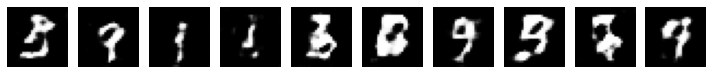

500 [D loss: 0.348718, acc.: 83.59%] [G loss: 0.390126]
501 [D loss: 0.332310, acc.: 86.72%] [G loss: 0.721730]
502 [D loss: 0.169130, acc.: 92.97%] [G loss: 1.536840]
503 [D loss: 0.397391, acc.: 85.94%] [G loss: 1.478395]
504 [D loss: 0.214192, acc.: 89.06%] [G loss: 1.177483]
505 [D loss: 0.248143, acc.: 90.62%] [G loss: 0.799805]
506 [D loss: 0.314514, acc.: 86.72%] [G loss: 0.813652]
507 [D loss: 0.249840, acc.: 89.06%] [G loss: 1.010874]
508 [D loss: 0.201715, acc.: 92.97%] [G loss: 1.219263]
509 [D loss: 0.186516, acc.: 94.53%] [G loss: 1.253039]
510 [D loss: 0.240961, acc.: 92.19%] [G loss: 1.141460]
511 [D loss: 0.246957, acc.: 87.50%] [G loss: 1.040226]
512 [D loss: 0.211736, acc.: 92.19%] [G loss: 1.183668]
513 [D loss: 0.242656, acc.: 92.97%] [G loss: 1.148463]
514 [D loss: 0.264398, acc.: 92.19%] [G loss: 1.153116]
515 [D loss: 0.253726, acc.: 89.84%] [G loss: 0.972216]
516 [D loss: 0.264370, acc.: 90.62%] [G loss: 1.129532]
517 [D loss: 0.187838, acc.: 92.97%] [G loss: 1.

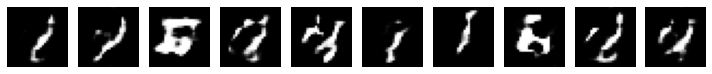

600 [D loss: 0.180478, acc.: 92.97%] [G loss: 2.538333]
601 [D loss: 0.069776, acc.: 99.22%] [G loss: 2.814305]
602 [D loss: 0.148303, acc.: 96.09%] [G loss: 2.303321]
603 [D loss: 0.263537, acc.: 89.84%] [G loss: 1.882914]
604 [D loss: 0.186483, acc.: 92.97%] [G loss: 1.960528]
605 [D loss: 0.093649, acc.: 97.66%] [G loss: 2.422669]
606 [D loss: 0.244226, acc.: 90.62%] [G loss: 2.374486]
607 [D loss: 0.220682, acc.: 90.62%] [G loss: 1.980581]
608 [D loss: 0.174934, acc.: 94.53%] [G loss: 1.372047]
609 [D loss: 0.342543, acc.: 86.72%] [G loss: 1.408430]
610 [D loss: 0.132450, acc.: 96.88%] [G loss: 1.363334]
611 [D loss: 0.127232, acc.: 96.09%] [G loss: 2.056662]
612 [D loss: 0.116805, acc.: 97.66%] [G loss: 2.503919]
613 [D loss: 0.239826, acc.: 89.84%] [G loss: 2.003381]
614 [D loss: 0.288514, acc.: 89.06%] [G loss: 1.169609]
615 [D loss: 0.195213, acc.: 92.97%] [G loss: 1.024573]
616 [D loss: 0.093161, acc.: 97.66%] [G loss: 2.041256]
617 [D loss: 0.183993, acc.: 95.31%] [G loss: 2.

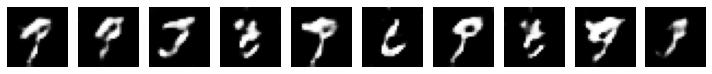

700 [D loss: 0.192865, acc.: 93.75%] [G loss: 1.340228]
701 [D loss: 0.168291, acc.: 94.53%] [G loss: 1.484141]
702 [D loss: 0.106646, acc.: 97.66%] [G loss: 1.580456]
703 [D loss: 0.137180, acc.: 95.31%] [G loss: 1.473613]
704 [D loss: 0.133018, acc.: 95.31%] [G loss: 1.071975]
705 [D loss: 0.174224, acc.: 92.19%] [G loss: 1.281920]
706 [D loss: 0.175613, acc.: 93.75%] [G loss: 1.198884]
707 [D loss: 0.216138, acc.: 89.06%] [G loss: 1.248237]
708 [D loss: 0.159974, acc.: 92.97%] [G loss: 0.991407]
709 [D loss: 0.127666, acc.: 94.53%] [G loss: 1.161668]
710 [D loss: 0.104227, acc.: 97.66%] [G loss: 1.489679]
711 [D loss: 0.132608, acc.: 95.31%] [G loss: 1.578276]
712 [D loss: 0.081989, acc.: 98.44%] [G loss: 1.460164]
713 [D loss: 0.118106, acc.: 96.88%] [G loss: 1.201690]
714 [D loss: 0.117834, acc.: 98.44%] [G loss: 0.874432]
715 [D loss: 0.192398, acc.: 92.97%] [G loss: 1.194211]
716 [D loss: 0.089213, acc.: 96.88%] [G loss: 1.622960]
717 [D loss: 0.199783, acc.: 92.19%] [G loss: 1.

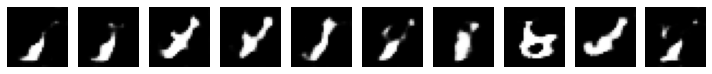

800 [D loss: 0.229185, acc.: 93.75%] [G loss: 3.462535]
801 [D loss: 0.141445, acc.: 94.53%] [G loss: 2.416679]
802 [D loss: 0.124396, acc.: 97.66%] [G loss: 3.194116]
803 [D loss: 0.094909, acc.: 96.88%] [G loss: 4.263511]
804 [D loss: 0.066620, acc.: 98.44%] [G loss: 4.684038]
805 [D loss: 0.131513, acc.: 93.75%] [G loss: 3.855681]
806 [D loss: 0.091243, acc.: 97.66%] [G loss: 3.377903]
807 [D loss: 0.120548, acc.: 96.88%] [G loss: 3.563034]
808 [D loss: 0.114428, acc.: 94.53%] [G loss: 3.440484]
809 [D loss: 0.166153, acc.: 93.75%] [G loss: 2.882608]
810 [D loss: 0.181300, acc.: 92.19%] [G loss: 3.341804]
811 [D loss: 0.086926, acc.: 96.88%] [G loss: 3.759875]
812 [D loss: 0.054661, acc.: 98.44%] [G loss: 4.247676]
813 [D loss: 0.078269, acc.: 96.09%] [G loss: 3.565547]
814 [D loss: 0.078345, acc.: 97.66%] [G loss: 3.168170]
815 [D loss: 0.123908, acc.: 94.53%] [G loss: 3.047639]
816 [D loss: 0.183224, acc.: 92.19%] [G loss: 2.548960]
817 [D loss: 0.182452, acc.: 92.19%] [G loss: 3.

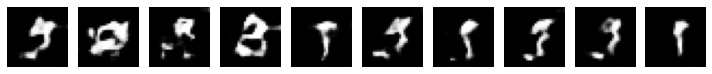

900 [D loss: 0.222133, acc.: 92.97%] [G loss: 0.969256]
901 [D loss: 0.143180, acc.: 94.53%] [G loss: 1.450369]
902 [D loss: 0.053987, acc.: 98.44%] [G loss: 2.031546]
903 [D loss: 0.175534, acc.: 92.97%] [G loss: 1.629414]
904 [D loss: 0.113708, acc.: 97.66%] [G loss: 1.420030]
905 [D loss: 0.083430, acc.: 96.88%] [G loss: 0.980892]
906 [D loss: 0.060985, acc.: 98.44%] [G loss: 1.295855]
907 [D loss: 0.072577, acc.: 93.75%] [G loss: 1.271191]
908 [D loss: 0.153234, acc.: 92.97%] [G loss: 1.440507]
909 [D loss: 0.122997, acc.: 95.31%] [G loss: 1.202231]
910 [D loss: 0.083969, acc.: 98.44%] [G loss: 1.320874]
911 [D loss: 0.042209, acc.: 99.22%] [G loss: 1.168452]
912 [D loss: 0.057005, acc.: 98.44%] [G loss: 1.223369]
913 [D loss: 0.070006, acc.: 98.44%] [G loss: 1.373263]
914 [D loss: 0.036363, acc.: 100.00%] [G loss: 1.557593]
915 [D loss: 0.050273, acc.: 98.44%] [G loss: 1.571182]
916 [D loss: 0.156436, acc.: 96.09%] [G loss: 1.223200]
917 [D loss: 0.076185, acc.: 97.66%] [G loss: 0

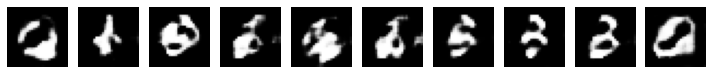

1000 [D loss: 0.098253, acc.: 96.88%] [G loss: 1.617418]
1001 [D loss: 0.101557, acc.: 97.66%] [G loss: 2.169906]
1002 [D loss: 0.171837, acc.: 94.53%] [G loss: 1.427903]
1003 [D loss: 0.177024, acc.: 92.97%] [G loss: 1.019297]
1004 [D loss: 0.140193, acc.: 93.75%] [G loss: 1.978466]
1005 [D loss: 0.202611, acc.: 92.19%] [G loss: 2.000276]
1006 [D loss: 0.129742, acc.: 96.09%] [G loss: 1.554630]
1007 [D loss: 0.220144, acc.: 92.97%] [G loss: 1.282286]
1008 [D loss: 0.153620, acc.: 96.09%] [G loss: 1.183037]
1009 [D loss: 0.092893, acc.: 97.66%] [G loss: 1.717738]
1010 [D loss: 0.090186, acc.: 97.66%] [G loss: 2.502594]
1011 [D loss: 0.136725, acc.: 94.53%] [G loss: 2.582412]
1012 [D loss: 0.142822, acc.: 94.53%] [G loss: 2.362512]
1013 [D loss: 0.091714, acc.: 96.09%] [G loss: 2.278155]
1014 [D loss: 0.169166, acc.: 92.19%] [G loss: 1.609283]
1015 [D loss: 0.225603, acc.: 89.84%] [G loss: 1.885729]
1016 [D loss: 0.082826, acc.: 97.66%] [G loss: 3.213501]
1017 [D loss: 0.031999, acc.: 9

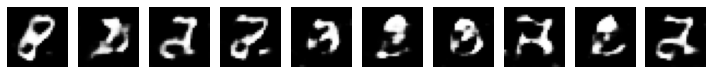

1100 [D loss: 0.134508, acc.: 96.09%] [G loss: 0.961836]
1101 [D loss: 0.067710, acc.: 97.66%] [G loss: 1.268673]
1102 [D loss: 0.041132, acc.: 98.44%] [G loss: 1.646825]
1103 [D loss: 0.119729, acc.: 95.31%] [G loss: 1.186779]
1104 [D loss: 0.060836, acc.: 97.66%] [G loss: 1.019512]
1105 [D loss: 0.112840, acc.: 96.88%] [G loss: 1.141540]
1106 [D loss: 0.042689, acc.: 98.44%] [G loss: 1.386024]
1107 [D loss: 0.124009, acc.: 95.31%] [G loss: 1.280102]
1108 [D loss: 0.065592, acc.: 99.22%] [G loss: 1.220411]
1109 [D loss: 0.079926, acc.: 98.44%] [G loss: 1.164216]
1110 [D loss: 0.046813, acc.: 98.44%] [G loss: 1.208908]
1111 [D loss: 0.107037, acc.: 96.88%] [G loss: 1.201410]
1112 [D loss: 0.055928, acc.: 98.44%] [G loss: 1.226700]
1113 [D loss: 0.145521, acc.: 96.09%] [G loss: 1.221783]
1114 [D loss: 0.105885, acc.: 96.09%] [G loss: 1.202559]
1115 [D loss: 0.052065, acc.: 98.44%] [G loss: 1.628359]
1116 [D loss: 0.056509, acc.: 98.44%] [G loss: 2.218110]
1117 [D loss: 0.025416, acc.: 9

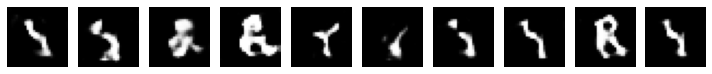

1200 [D loss: 0.141019, acc.: 95.31%] [G loss: 4.190901]
1201 [D loss: 0.127376, acc.: 94.53%] [G loss: 2.834697]
1202 [D loss: 0.164988, acc.: 94.53%] [G loss: 3.268268]
1203 [D loss: 0.077674, acc.: 97.66%] [G loss: 4.444191]
1204 [D loss: 0.078777, acc.: 98.44%] [G loss: 5.113574]
1205 [D loss: 0.104934, acc.: 94.53%] [G loss: 4.555823]
1206 [D loss: 0.103237, acc.: 95.31%] [G loss: 3.435950]
1207 [D loss: 0.084197, acc.: 97.66%] [G loss: 4.153291]
1208 [D loss: 0.029354, acc.: 99.22%] [G loss: 5.304412]
1209 [D loss: 0.146092, acc.: 93.75%] [G loss: 3.688494]
1210 [D loss: 0.150380, acc.: 93.75%] [G loss: 3.633350]
1211 [D loss: 0.099517, acc.: 96.88%] [G loss: 4.139043]
1212 [D loss: 0.042500, acc.: 99.22%] [G loss: 4.654205]
1213 [D loss: 0.123880, acc.: 97.66%] [G loss: 4.303734]
1214 [D loss: 0.095859, acc.: 96.88%] [G loss: 3.340644]
1215 [D loss: 0.064222, acc.: 98.44%] [G loss: 3.099216]
1216 [D loss: 0.044666, acc.: 98.44%] [G loss: 4.206155]
1217 [D loss: 0.036987, acc.: 9

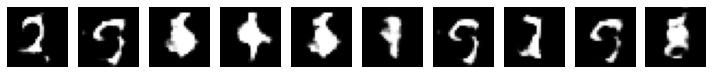

1300 [D loss: 0.043622, acc.: 98.44%] [G loss: 1.792601]
1301 [D loss: 0.049642, acc.: 97.66%] [G loss: 1.872673]
1302 [D loss: 0.072778, acc.: 96.88%] [G loss: 1.625951]
1303 [D loss: 0.094322, acc.: 96.88%] [G loss: 1.531880]
1304 [D loss: 0.076527, acc.: 98.44%] [G loss: 1.099217]
1305 [D loss: 0.050469, acc.: 99.22%] [G loss: 0.853026]
1306 [D loss: 0.065913, acc.: 98.44%] [G loss: 1.050347]
1307 [D loss: 0.098642, acc.: 98.44%] [G loss: 1.029905]
1308 [D loss: 0.052348, acc.: 98.44%] [G loss: 1.095021]
1309 [D loss: 0.095170, acc.: 95.31%] [G loss: 1.189868]
1310 [D loss: 0.096928, acc.: 96.09%] [G loss: 1.012778]
1311 [D loss: 0.055406, acc.: 100.00%] [G loss: 0.951721]
1312 [D loss: 0.123132, acc.: 93.75%] [G loss: 0.814360]
1313 [D loss: 0.026820, acc.: 99.22%] [G loss: 0.921923]
1314 [D loss: 0.094705, acc.: 96.88%] [G loss: 1.148624]
1315 [D loss: 0.052752, acc.: 98.44%] [G loss: 1.200781]
1316 [D loss: 0.075904, acc.: 96.88%] [G loss: 1.222634]
1317 [D loss: 0.025965, acc.: 

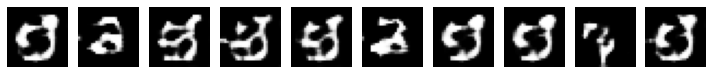

1400 [D loss: 0.061650, acc.: 97.66%] [G loss: 1.152827]
1401 [D loss: 0.052405, acc.: 97.66%] [G loss: 1.033808]
1402 [D loss: 0.116209, acc.: 96.09%] [G loss: 1.300203]
1403 [D loss: 0.108064, acc.: 97.66%] [G loss: 1.974589]
1404 [D loss: 0.187290, acc.: 95.31%] [G loss: 1.546715]
1405 [D loss: 0.139402, acc.: 93.75%] [G loss: 1.309466]
1406 [D loss: 0.073597, acc.: 96.88%] [G loss: 1.254314]
1407 [D loss: 0.078791, acc.: 96.09%] [G loss: 1.586407]
1408 [D loss: 0.070896, acc.: 98.44%] [G loss: 2.028540]
1409 [D loss: 0.072421, acc.: 98.44%] [G loss: 1.954487]
1410 [D loss: 0.037742, acc.: 99.22%] [G loss: 1.810472]
1411 [D loss: 0.077628, acc.: 96.88%] [G loss: 1.469911]
1412 [D loss: 0.070992, acc.: 97.66%] [G loss: 1.820377]
1413 [D loss: 0.073205, acc.: 96.88%] [G loss: 1.703559]
1414 [D loss: 0.036501, acc.: 99.22%] [G loss: 2.489789]
1415 [D loss: 0.029699, acc.: 99.22%] [G loss: 3.495092]
1416 [D loss: 0.044382, acc.: 97.66%] [G loss: 2.640361]
1417 [D loss: 0.122512, acc.: 9

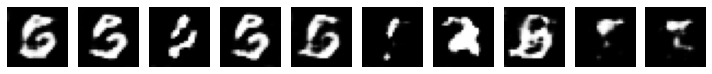

1500 [D loss: 0.029790, acc.: 99.22%] [G loss: 1.042230]
1501 [D loss: 0.062843, acc.: 98.44%] [G loss: 0.940231]
1502 [D loss: 0.055160, acc.: 98.44%] [G loss: 1.085577]
1503 [D loss: 0.021597, acc.: 99.22%] [G loss: 1.849673]
1504 [D loss: 0.108145, acc.: 95.31%] [G loss: 1.934580]
1505 [D loss: 0.082582, acc.: 98.44%] [G loss: 1.421616]
1506 [D loss: 0.110160, acc.: 95.31%] [G loss: 0.960932]
1507 [D loss: 0.119802, acc.: 94.53%] [G loss: 0.519852]
1508 [D loss: 0.070963, acc.: 96.88%] [G loss: 0.744584]
1509 [D loss: 0.086562, acc.: 96.88%] [G loss: 1.436937]
1510 [D loss: 0.077217, acc.: 96.09%] [G loss: 2.792870]
1511 [D loss: 0.111143, acc.: 95.31%] [G loss: 2.004656]
1512 [D loss: 0.177108, acc.: 94.53%] [G loss: 0.887615]
1513 [D loss: 0.172937, acc.: 94.53%] [G loss: 0.819311]
1514 [D loss: 0.055673, acc.: 96.88%] [G loss: 1.147669]
1515 [D loss: 0.025439, acc.: 99.22%] [G loss: 2.003898]
1516 [D loss: 0.026780, acc.: 100.00%] [G loss: 2.618259]
1517 [D loss: 0.016746, acc.: 

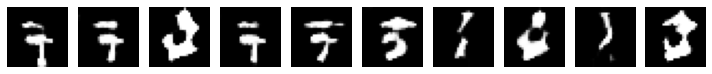

1600 [D loss: 0.046607, acc.: 98.44%] [G loss: 1.392464]
1601 [D loss: 0.048282, acc.: 97.66%] [G loss: 1.430157]
1602 [D loss: 0.099555, acc.: 95.31%] [G loss: 1.536822]
1603 [D loss: 0.064171, acc.: 97.66%] [G loss: 0.947018]
1604 [D loss: 0.071582, acc.: 96.88%] [G loss: 0.766923]
1605 [D loss: 0.040267, acc.: 98.44%] [G loss: 1.205884]
1606 [D loss: 0.019891, acc.: 100.00%] [G loss: 1.857839]
1607 [D loss: 0.040822, acc.: 98.44%] [G loss: 2.033677]
1608 [D loss: 0.084734, acc.: 98.44%] [G loss: 1.514959]
1609 [D loss: 0.043145, acc.: 99.22%] [G loss: 1.121057]
1610 [D loss: 0.033137, acc.: 99.22%] [G loss: 0.884873]
1611 [D loss: 0.062731, acc.: 97.66%] [G loss: 0.763156]
1612 [D loss: 0.097949, acc.: 96.09%] [G loss: 1.069558]
1613 [D loss: 0.120851, acc.: 95.31%] [G loss: 1.730252]
1614 [D loss: 0.049664, acc.: 98.44%] [G loss: 1.958351]
1615 [D loss: 0.083867, acc.: 96.88%] [G loss: 2.135163]
1616 [D loss: 0.244294, acc.: 93.75%] [G loss: 0.911439]
1617 [D loss: 0.070452, acc.: 

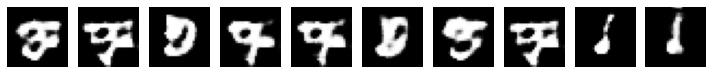

1700 [D loss: 0.121580, acc.: 96.88%] [G loss: 3.896691]
1701 [D loss: 0.089884, acc.: 96.88%] [G loss: 3.138649]
1702 [D loss: 0.161950, acc.: 96.09%] [G loss: 1.536855]
1703 [D loss: 0.052610, acc.: 97.66%] [G loss: 0.903426]
1704 [D loss: 0.031792, acc.: 99.22%] [G loss: 0.678697]
1705 [D loss: 0.108721, acc.: 96.88%] [G loss: 0.701276]
1706 [D loss: 0.161830, acc.: 92.97%] [G loss: 1.031563]
1707 [D loss: 0.043927, acc.: 98.44%] [G loss: 2.003022]
1708 [D loss: 0.110390, acc.: 96.09%] [G loss: 1.978762]
1709 [D loss: 0.297446, acc.: 93.75%] [G loss: 0.999482]
1710 [D loss: 0.132716, acc.: 95.31%] [G loss: 0.502988]
1711 [D loss: 0.324541, acc.: 86.72%] [G loss: 1.214850]
1712 [D loss: 0.051386, acc.: 98.44%] [G loss: 6.277317]
1713 [D loss: 0.312325, acc.: 92.97%] [G loss: 7.766610]
1714 [D loss: 0.379062, acc.: 84.38%] [G loss: 5.277344]
1715 [D loss: 0.347111, acc.: 87.50%] [G loss: 3.620911]
1716 [D loss: 0.410180, acc.: 85.16%] [G loss: 3.071194]
1717 [D loss: 0.066219, acc.: 9

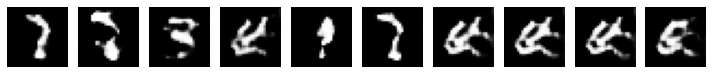

1800 [D loss: 0.088395, acc.: 96.88%] [G loss: 1.486946]
1801 [D loss: 0.116688, acc.: 96.09%] [G loss: 1.222903]
1802 [D loss: 0.107401, acc.: 96.09%] [G loss: 0.882889]
1803 [D loss: 0.095308, acc.: 97.66%] [G loss: 1.514194]
1804 [D loss: 0.009636, acc.: 100.00%] [G loss: 2.573407]
1805 [D loss: 0.068549, acc.: 98.44%] [G loss: 2.209882]
1806 [D loss: 0.176555, acc.: 94.53%] [G loss: 1.063768]
1807 [D loss: 0.123124, acc.: 94.53%] [G loss: 1.759748]
1808 [D loss: 0.014262, acc.: 100.00%] [G loss: 4.432976]
1809 [D loss: 0.129306, acc.: 90.62%] [G loss: 3.397478]
1810 [D loss: 0.157988, acc.: 93.75%] [G loss: 2.405334]
1811 [D loss: 0.052990, acc.: 97.66%] [G loss: 2.047035]
1812 [D loss: 0.080603, acc.: 96.09%] [G loss: 2.393262]
1813 [D loss: 0.047856, acc.: 98.44%] [G loss: 2.930132]
1814 [D loss: 0.141425, acc.: 95.31%] [G loss: 1.980840]
1815 [D loss: 0.049698, acc.: 97.66%] [G loss: 1.234406]
1816 [D loss: 0.025255, acc.: 99.22%] [G loss: 1.224718]
1817 [D loss: 0.062897, acc.:

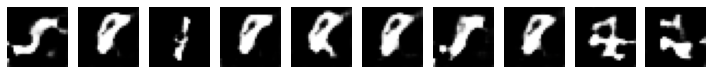

1900 [D loss: 0.072128, acc.: 96.09%] [G loss: 2.037318]
1901 [D loss: 0.027501, acc.: 100.00%] [G loss: 3.316873]
1902 [D loss: 0.069666, acc.: 97.66%] [G loss: 3.602358]
1903 [D loss: 0.062206, acc.: 97.66%] [G loss: 3.389565]
1904 [D loss: 0.029922, acc.: 98.44%] [G loss: 3.089653]
1905 [D loss: 0.162080, acc.: 94.53%] [G loss: 2.947568]
1906 [D loss: 0.050265, acc.: 98.44%] [G loss: 3.217503]
1907 [D loss: 0.054217, acc.: 96.88%] [G loss: 3.065125]
1908 [D loss: 0.053261, acc.: 98.44%] [G loss: 2.562031]
1909 [D loss: 0.057097, acc.: 98.44%] [G loss: 1.718144]
1910 [D loss: 0.078806, acc.: 97.66%] [G loss: 1.261948]
1911 [D loss: 0.063762, acc.: 96.88%] [G loss: 1.400983]
1912 [D loss: 0.054479, acc.: 97.66%] [G loss: 1.813361]
1913 [D loss: 0.057080, acc.: 96.88%] [G loss: 1.902676]
1914 [D loss: 0.043407, acc.: 98.44%] [G loss: 2.217261]
1915 [D loss: 0.068718, acc.: 97.66%] [G loss: 1.737569]
1916 [D loss: 0.056426, acc.: 99.22%] [G loss: 2.149823]
1917 [D loss: 0.025623, acc.: 

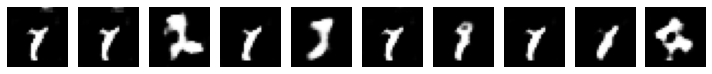

2000 [D loss: 0.040459, acc.: 99.22%] [G loss: 2.198358]
2001 [D loss: 0.027332, acc.: 99.22%] [G loss: 2.609832]
2002 [D loss: 0.038308, acc.: 99.22%] [G loss: 2.483886]
2003 [D loss: 0.018718, acc.: 100.00%] [G loss: 2.527387]
2004 [D loss: 0.073616, acc.: 98.44%] [G loss: 2.023869]
2005 [D loss: 0.033442, acc.: 99.22%] [G loss: 1.644437]
2006 [D loss: 0.048776, acc.: 98.44%] [G loss: 1.613448]
2007 [D loss: 0.099633, acc.: 95.31%] [G loss: 2.639257]
2008 [D loss: 0.058037, acc.: 97.66%] [G loss: 5.412104]
2009 [D loss: 0.088302, acc.: 96.88%] [G loss: 5.323793]
2010 [D loss: 0.073115, acc.: 96.09%] [G loss: 3.401180]
2011 [D loss: 0.048183, acc.: 98.44%] [G loss: 2.453346]
2012 [D loss: 0.110351, acc.: 96.09%] [G loss: 1.984614]
2013 [D loss: 0.021708, acc.: 100.00%] [G loss: 3.316206]
2014 [D loss: 0.041539, acc.: 97.66%] [G loss: 3.428718]
2015 [D loss: 0.057471, acc.: 96.88%] [G loss: 2.842052]
2016 [D loss: 0.094782, acc.: 96.09%] [G loss: 1.462130]
2017 [D loss: 0.176579, acc.:

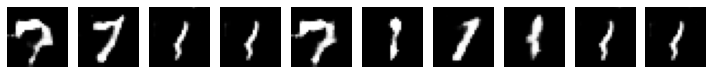

2100 [D loss: 0.047436, acc.: 99.22%] [G loss: 3.278015]
2101 [D loss: 0.069313, acc.: 99.22%] [G loss: 3.423398]
2102 [D loss: 0.028702, acc.: 98.44%] [G loss: 3.877300]
2103 [D loss: 0.079104, acc.: 95.31%] [G loss: 2.813321]
2104 [D loss: 0.174946, acc.: 95.31%] [G loss: 1.342094]
2105 [D loss: 0.164811, acc.: 92.19%] [G loss: 2.020401]
2106 [D loss: 0.021348, acc.: 99.22%] [G loss: 4.496661]
2107 [D loss: 0.075228, acc.: 96.88%] [G loss: 5.318422]
2108 [D loss: 0.295187, acc.: 94.53%] [G loss: 3.936597]
2109 [D loss: 0.086452, acc.: 97.66%] [G loss: 1.814895]
2110 [D loss: 0.138301, acc.: 94.53%] [G loss: 1.404597]
2111 [D loss: 0.099380, acc.: 97.66%] [G loss: 2.880019]
2112 [D loss: 0.064548, acc.: 96.09%] [G loss: 4.038689]
2113 [D loss: 0.084903, acc.: 98.44%] [G loss: 4.779540]
2114 [D loss: 0.064219, acc.: 96.88%] [G loss: 4.516250]
2115 [D loss: 0.074585, acc.: 97.66%] [G loss: 2.967032]
2116 [D loss: 0.094027, acc.: 97.66%] [G loss: 1.854437]
2117 [D loss: 0.164936, acc.: 9

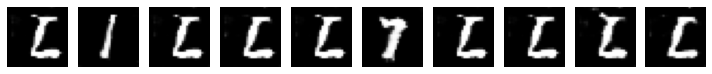

2200 [D loss: 0.116598, acc.: 96.09%] [G loss: 1.937148]
2201 [D loss: 0.110809, acc.: 94.53%] [G loss: 1.678908]
2202 [D loss: 0.056532, acc.: 97.66%] [G loss: 1.440774]
2203 [D loss: 0.051490, acc.: 97.66%] [G loss: 1.489178]
2204 [D loss: 0.118051, acc.: 93.75%] [G loss: 1.728773]
2205 [D loss: 0.076519, acc.: 96.88%] [G loss: 2.937068]
2206 [D loss: 0.044190, acc.: 98.44%] [G loss: 3.389100]
2207 [D loss: 0.140200, acc.: 94.53%] [G loss: 2.172104]
2208 [D loss: 0.160410, acc.: 92.97%] [G loss: 0.918324]
2209 [D loss: 0.107233, acc.: 95.31%] [G loss: 0.456102]
2210 [D loss: 0.067854, acc.: 99.22%] [G loss: 1.062065]
2211 [D loss: 0.038691, acc.: 99.22%] [G loss: 1.874165]
2212 [D loss: 0.082385, acc.: 97.66%] [G loss: 2.660543]
2213 [D loss: 0.140902, acc.: 92.97%] [G loss: 2.678302]
2214 [D loss: 0.046721, acc.: 99.22%] [G loss: 3.231117]
2215 [D loss: 0.080533, acc.: 96.09%] [G loss: 3.322736]
2216 [D loss: 0.021872, acc.: 99.22%] [G loss: 2.891384]
2217 [D loss: 0.054875, acc.: 9

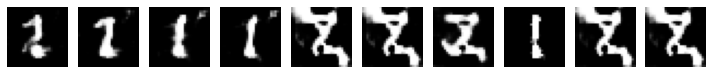

2300 [D loss: 0.225563, acc.: 92.19%] [G loss: 0.597266]
2301 [D loss: 0.024915, acc.: 98.44%] [G loss: 0.601357]
2302 [D loss: 0.024731, acc.: 99.22%] [G loss: 1.002230]
2303 [D loss: 0.042673, acc.: 98.44%] [G loss: 1.157119]
2304 [D loss: 0.136894, acc.: 97.66%] [G loss: 0.747682]
2305 [D loss: 0.056484, acc.: 98.44%] [G loss: 0.718416]
2306 [D loss: 0.025513, acc.: 99.22%] [G loss: 1.288998]
2307 [D loss: 0.024042, acc.: 99.22%] [G loss: 2.177140]
2308 [D loss: 0.050704, acc.: 98.44%] [G loss: 2.837872]
2309 [D loss: 0.055393, acc.: 97.66%] [G loss: 2.626833]
2310 [D loss: 0.108570, acc.: 96.09%] [G loss: 1.116631]
2311 [D loss: 0.103464, acc.: 95.31%] [G loss: 0.965764]
2312 [D loss: 0.066761, acc.: 96.88%] [G loss: 1.478074]
2313 [D loss: 0.064683, acc.: 96.88%] [G loss: 2.315484]
2314 [D loss: 0.234873, acc.: 93.75%] [G loss: 1.796175]
2315 [D loss: 0.018271, acc.: 99.22%] [G loss: 2.114362]
2316 [D loss: 0.052903, acc.: 97.66%] [G loss: 1.773329]
2317 [D loss: 0.070455, acc.: 9

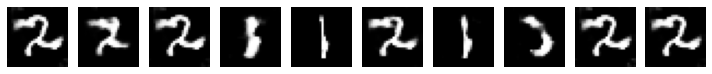

2400 [D loss: 0.011355, acc.: 100.00%] [G loss: 5.377155]
2401 [D loss: 0.163275, acc.: 93.75%] [G loss: 3.867765]
2402 [D loss: 0.041606, acc.: 97.66%] [G loss: 2.451850]
2403 [D loss: 0.103368, acc.: 96.09%] [G loss: 2.275971]
2404 [D loss: 0.068067, acc.: 97.66%] [G loss: 3.011503]
2405 [D loss: 0.015247, acc.: 100.00%] [G loss: 3.867368]
2406 [D loss: 0.053048, acc.: 99.22%] [G loss: 4.793421]
2407 [D loss: 0.072419, acc.: 96.88%] [G loss: 3.480259]
2408 [D loss: 0.027060, acc.: 99.22%] [G loss: 2.890390]
2409 [D loss: 0.041094, acc.: 98.44%] [G loss: 2.455718]
2410 [D loss: 0.110634, acc.: 96.88%] [G loss: 2.033307]
2411 [D loss: 0.043610, acc.: 98.44%] [G loss: 2.459711]
2412 [D loss: 0.035070, acc.: 98.44%] [G loss: 3.131582]
2413 [D loss: 0.061147, acc.: 97.66%] [G loss: 4.237420]
2414 [D loss: 0.028316, acc.: 98.44%] [G loss: 4.752734]
2415 [D loss: 0.036060, acc.: 98.44%] [G loss: 4.818085]
2416 [D loss: 0.039128, acc.: 97.66%] [G loss: 4.170264]
2417 [D loss: 0.046748, acc.:

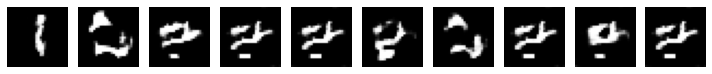

2500 [D loss: 0.018964, acc.: 99.22%] [G loss: 7.468525]
2501 [D loss: 0.092129, acc.: 96.09%] [G loss: 6.890903]
2502 [D loss: 0.044888, acc.: 98.44%] [G loss: 5.624322]
2503 [D loss: 0.092831, acc.: 96.88%] [G loss: 5.279725]
2504 [D loss: 0.082499, acc.: 96.88%] [G loss: 5.719444]
2505 [D loss: 0.040209, acc.: 98.44%] [G loss: 6.072253]
2506 [D loss: 0.037486, acc.: 98.44%] [G loss: 5.956402]
2507 [D loss: 0.062398, acc.: 96.88%] [G loss: 5.535725]
2508 [D loss: 0.078993, acc.: 97.66%] [G loss: 4.411276]
2509 [D loss: 0.174856, acc.: 96.09%] [G loss: 3.687385]
2510 [D loss: 0.092795, acc.: 97.66%] [G loss: 3.181621]
2511 [D loss: 0.054855, acc.: 97.66%] [G loss: 3.113183]
2512 [D loss: 0.038453, acc.: 98.44%] [G loss: 3.147040]
2513 [D loss: 0.038326, acc.: 98.44%] [G loss: 3.066390]
2514 [D loss: 0.019663, acc.: 98.44%] [G loss: 3.305822]
2515 [D loss: 0.023099, acc.: 98.44%] [G loss: 2.898105]
2516 [D loss: 0.026063, acc.: 100.00%] [G loss: 2.639604]
2517 [D loss: 0.035634, acc.: 

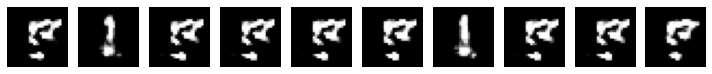

2600 [D loss: 0.072731, acc.: 97.66%] [G loss: 1.784796]
2601 [D loss: 0.055773, acc.: 97.66%] [G loss: 1.863472]
2602 [D loss: 0.041382, acc.: 96.88%] [G loss: 3.294331]
2603 [D loss: 0.039959, acc.: 98.44%] [G loss: 4.678053]
2604 [D loss: 0.168762, acc.: 93.75%] [G loss: 2.729621]
2605 [D loss: 0.190138, acc.: 92.97%] [G loss: 1.740649]
2606 [D loss: 0.096394, acc.: 95.31%] [G loss: 2.299971]
2607 [D loss: 0.215844, acc.: 93.75%] [G loss: 3.720371]
2608 [D loss: 0.023609, acc.: 98.44%] [G loss: 4.916475]
2609 [D loss: 0.068190, acc.: 96.88%] [G loss: 4.306855]
2610 [D loss: 0.145304, acc.: 95.31%] [G loss: 1.871302]
2611 [D loss: 0.076908, acc.: 96.88%] [G loss: 0.854150]
2612 [D loss: 0.107983, acc.: 96.09%] [G loss: 0.905466]
2613 [D loss: 0.038979, acc.: 99.22%] [G loss: 2.945150]
2614 [D loss: 0.058659, acc.: 97.66%] [G loss: 4.680513]
2615 [D loss: 0.034835, acc.: 98.44%] [G loss: 5.553758]
2616 [D loss: 0.106863, acc.: 96.88%] [G loss: 5.460597]
2617 [D loss: 0.073942, acc.: 9

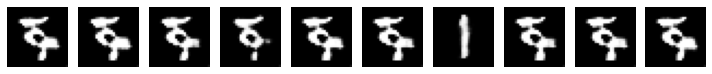

2700 [D loss: 0.078732, acc.: 96.88%] [G loss: 2.656779]
2701 [D loss: 0.067218, acc.: 97.66%] [G loss: 2.597872]
2702 [D loss: 0.059639, acc.: 97.66%] [G loss: 1.954641]
2703 [D loss: 0.062621, acc.: 97.66%] [G loss: 1.534133]
2704 [D loss: 0.078465, acc.: 96.09%] [G loss: 1.281749]
2705 [D loss: 0.051961, acc.: 98.44%] [G loss: 1.334160]
2706 [D loss: 0.079276, acc.: 96.88%] [G loss: 1.439923]
2707 [D loss: 0.104729, acc.: 96.09%] [G loss: 1.586884]
2708 [D loss: 0.033235, acc.: 100.00%] [G loss: 1.747783]
2709 [D loss: 0.052591, acc.: 98.44%] [G loss: 2.352251]
2710 [D loss: 0.089275, acc.: 97.66%] [G loss: 1.659444]
2711 [D loss: 0.034129, acc.: 98.44%] [G loss: 1.903376]
2712 [D loss: 0.039995, acc.: 99.22%] [G loss: 1.772053]
2713 [D loss: 0.042347, acc.: 98.44%] [G loss: 2.119032]
2714 [D loss: 0.021621, acc.: 99.22%] [G loss: 2.456385]
2715 [D loss: 0.098948, acc.: 96.88%] [G loss: 2.352936]
2716 [D loss: 0.062201, acc.: 97.66%] [G loss: 1.780257]
2717 [D loss: 0.068001, acc.: 

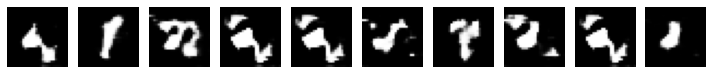

2800 [D loss: 0.081144, acc.: 97.66%] [G loss: 3.849708]
2801 [D loss: 0.035913, acc.: 99.22%] [G loss: 3.151726]
2802 [D loss: 0.049499, acc.: 98.44%] [G loss: 2.796306]
2803 [D loss: 0.041734, acc.: 99.22%] [G loss: 3.136051]
2804 [D loss: 0.017120, acc.: 100.00%] [G loss: 3.949629]
2805 [D loss: 0.025191, acc.: 99.22%] [G loss: 4.882862]
2806 [D loss: 0.062541, acc.: 98.44%] [G loss: 4.954586]
2807 [D loss: 0.038890, acc.: 98.44%] [G loss: 4.881872]
2808 [D loss: 0.023785, acc.: 98.44%] [G loss: 4.366095]
2809 [D loss: 0.025025, acc.: 100.00%] [G loss: 4.161003]
2810 [D loss: 0.075279, acc.: 97.66%] [G loss: 3.851573]
2811 [D loss: 0.052090, acc.: 96.88%] [G loss: 4.087871]
2812 [D loss: 0.024463, acc.: 99.22%] [G loss: 4.141582]
2813 [D loss: 0.080387, acc.: 99.22%] [G loss: 4.431459]
2814 [D loss: 0.044200, acc.: 98.44%] [G loss: 3.836445]
2815 [D loss: 0.024867, acc.: 100.00%] [G loss: 2.638193]
2816 [D loss: 0.039390, acc.: 97.66%] [G loss: 2.426536]
2817 [D loss: 0.031849, acc.

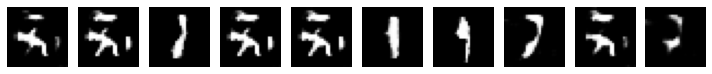

2900 [D loss: 0.070247, acc.: 97.66%] [G loss: 3.810030]
2901 [D loss: 0.054788, acc.: 97.66%] [G loss: 3.717848]
2902 [D loss: 0.039696, acc.: 98.44%] [G loss: 4.457770]
2903 [D loss: 0.033455, acc.: 99.22%] [G loss: 5.155778]
2904 [D loss: 0.086293, acc.: 97.66%] [G loss: 4.780920]
2905 [D loss: 0.069555, acc.: 97.66%] [G loss: 3.515300]
2906 [D loss: 0.093431, acc.: 96.88%] [G loss: 3.272836]
2907 [D loss: 0.038652, acc.: 100.00%] [G loss: 3.764862]
2908 [D loss: 0.025154, acc.: 99.22%] [G loss: 4.494141]
2909 [D loss: 0.039054, acc.: 99.22%] [G loss: 4.489968]
2910 [D loss: 0.091504, acc.: 96.88%] [G loss: 4.815469]
2911 [D loss: 0.029126, acc.: 99.22%] [G loss: 4.638139]
2912 [D loss: 0.074996, acc.: 97.66%] [G loss: 4.023798]
2913 [D loss: 0.036100, acc.: 98.44%] [G loss: 3.154402]
2914 [D loss: 0.027489, acc.: 99.22%] [G loss: 2.833662]
2915 [D loss: 0.023636, acc.: 100.00%] [G loss: 2.882000]
2916 [D loss: 0.062698, acc.: 97.66%] [G loss: 2.941206]
2917 [D loss: 0.112080, acc.:

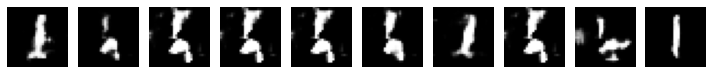

3000 [D loss: 0.034022, acc.: 99.22%] [G loss: 0.925353]
3001 [D loss: 0.083637, acc.: 96.09%] [G loss: 0.987583]
3002 [D loss: 0.038853, acc.: 99.22%] [G loss: 1.531427]
3003 [D loss: 0.067617, acc.: 97.66%] [G loss: 1.417946]
3004 [D loss: 0.057841, acc.: 96.88%] [G loss: 1.362590]
3005 [D loss: 0.069167, acc.: 96.88%] [G loss: 1.348264]
3006 [D loss: 0.135735, acc.: 94.53%] [G loss: 1.218090]
3007 [D loss: 0.039616, acc.: 99.22%] [G loss: 1.647099]
3008 [D loss: 0.028689, acc.: 99.22%] [G loss: 2.361660]
3009 [D loss: 0.083318, acc.: 97.66%] [G loss: 2.031723]
3010 [D loss: 0.021522, acc.: 98.44%] [G loss: 1.886348]
3011 [D loss: 0.071339, acc.: 97.66%] [G loss: 1.453584]
3012 [D loss: 0.045499, acc.: 98.44%] [G loss: 0.914437]
3013 [D loss: 0.062098, acc.: 96.88%] [G loss: 1.212118]
3014 [D loss: 0.030370, acc.: 99.22%] [G loss: 1.706177]
3015 [D loss: 0.054357, acc.: 99.22%] [G loss: 1.822147]
3016 [D loss: 0.064496, acc.: 97.66%] [G loss: 2.068881]
3017 [D loss: 0.024654, acc.: 9

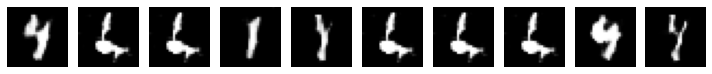

3100 [D loss: 0.092753, acc.: 96.09%] [G loss: 4.233669]
3101 [D loss: 0.120353, acc.: 97.66%] [G loss: 3.075579]
3102 [D loss: 0.114033, acc.: 94.53%] [G loss: 2.756325]
3103 [D loss: 0.100052, acc.: 97.66%] [G loss: 2.546639]
3104 [D loss: 0.084937, acc.: 96.88%] [G loss: 4.723637]
3105 [D loss: 0.036917, acc.: 98.44%] [G loss: 6.201224]
3106 [D loss: 0.011733, acc.: 100.00%] [G loss: 7.075063]
3107 [D loss: 0.126462, acc.: 96.09%] [G loss: 5.941129]
3108 [D loss: 0.080194, acc.: 96.88%] [G loss: 3.152549]
3109 [D loss: 0.082854, acc.: 96.88%] [G loss: 2.092560]
3110 [D loss: 0.023121, acc.: 99.22%] [G loss: 2.530128]
3111 [D loss: 0.037344, acc.: 98.44%] [G loss: 2.570411]
3112 [D loss: 0.064598, acc.: 96.88%] [G loss: 2.892927]
3113 [D loss: 0.045211, acc.: 97.66%] [G loss: 4.218614]
3114 [D loss: 0.061924, acc.: 97.66%] [G loss: 5.198359]
3115 [D loss: 0.005029, acc.: 100.00%] [G loss: 6.334404]
3116 [D loss: 0.136661, acc.: 95.31%] [G loss: 5.397078]
3117 [D loss: 0.084535, acc.:

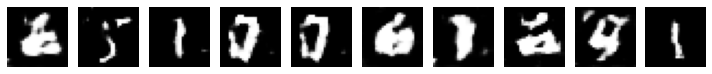

3200 [D loss: 0.111126, acc.: 96.09%] [G loss: 1.760650]
3201 [D loss: 0.037594, acc.: 99.22%] [G loss: 1.895188]
3202 [D loss: 0.005994, acc.: 100.00%] [G loss: 2.152434]
3203 [D loss: 0.067807, acc.: 98.44%] [G loss: 2.030693]
3204 [D loss: 0.085609, acc.: 96.88%] [G loss: 0.913854]
3205 [D loss: 0.041029, acc.: 99.22%] [G loss: 0.866986]
3206 [D loss: 0.074615, acc.: 97.66%] [G loss: 0.829737]
3207 [D loss: 0.149289, acc.: 93.75%] [G loss: 1.062557]
3208 [D loss: 0.039460, acc.: 98.44%] [G loss: 1.048870]
3209 [D loss: 0.049147, acc.: 96.88%] [G loss: 1.745246]
3210 [D loss: 0.042823, acc.: 99.22%] [G loss: 2.283625]
3211 [D loss: 0.023228, acc.: 100.00%] [G loss: 2.148683]
3212 [D loss: 0.032809, acc.: 98.44%] [G loss: 1.925502]
3213 [D loss: 0.019060, acc.: 99.22%] [G loss: 1.854430]
3214 [D loss: 0.022166, acc.: 99.22%] [G loss: 1.541197]
3215 [D loss: 0.020257, acc.: 99.22%] [G loss: 1.486976]
3216 [D loss: 0.058124, acc.: 99.22%] [G loss: 1.370546]
3217 [D loss: 0.053680, acc.:

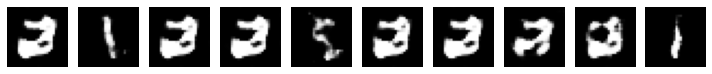

3300 [D loss: 0.040104, acc.: 97.66%] [G loss: 1.709085]
3301 [D loss: 0.054202, acc.: 98.44%] [G loss: 2.111779]
3302 [D loss: 0.038982, acc.: 98.44%] [G loss: 2.172492]
3303 [D loss: 0.057840, acc.: 98.44%] [G loss: 2.047250]
3304 [D loss: 0.099734, acc.: 96.09%] [G loss: 1.605855]
3305 [D loss: 0.077693, acc.: 97.66%] [G loss: 1.238824]
3306 [D loss: 0.059847, acc.: 96.88%] [G loss: 1.299790]
3307 [D loss: 0.049179, acc.: 98.44%] [G loss: 2.305039]
3308 [D loss: 0.043686, acc.: 96.88%] [G loss: 3.070290]
3309 [D loss: 0.011112, acc.: 100.00%] [G loss: 4.263951]
3310 [D loss: 0.111876, acc.: 95.31%] [G loss: 3.154949]
3311 [D loss: 0.067825, acc.: 96.09%] [G loss: 1.896036]
3312 [D loss: 0.053064, acc.: 97.66%] [G loss: 1.534682]
3313 [D loss: 0.039899, acc.: 98.44%] [G loss: 1.931535]
3314 [D loss: 0.034001, acc.: 98.44%] [G loss: 2.320735]
3315 [D loss: 0.035140, acc.: 99.22%] [G loss: 2.662531]
3316 [D loss: 0.023322, acc.: 99.22%] [G loss: 2.659100]
3317 [D loss: 0.055909, acc.: 

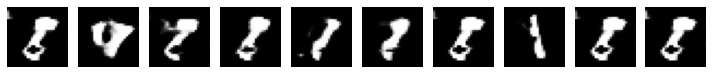

3400 [D loss: 0.075652, acc.: 96.09%] [G loss: 1.896925]
3401 [D loss: 0.072394, acc.: 96.09%] [G loss: 2.786001]
3402 [D loss: 0.021284, acc.: 98.44%] [G loss: 3.838987]
3403 [D loss: 0.054472, acc.: 98.44%] [G loss: 3.755615]
3404 [D loss: 0.045895, acc.: 98.44%] [G loss: 2.512413]
3405 [D loss: 0.044175, acc.: 98.44%] [G loss: 2.270246]
3406 [D loss: 0.236242, acc.: 92.19%] [G loss: 1.473678]
3407 [D loss: 0.025307, acc.: 100.00%] [G loss: 1.678135]
3408 [D loss: 0.044277, acc.: 98.44%] [G loss: 1.582293]
3409 [D loss: 0.098622, acc.: 96.09%] [G loss: 1.512993]
3410 [D loss: 0.076418, acc.: 96.88%] [G loss: 1.266371]
3411 [D loss: 0.065285, acc.: 98.44%] [G loss: 1.337550]
3412 [D loss: 0.028403, acc.: 98.44%] [G loss: 1.442964]
3413 [D loss: 0.062251, acc.: 97.66%] [G loss: 1.810191]
3414 [D loss: 0.019674, acc.: 99.22%] [G loss: 1.720730]
3415 [D loss: 0.040358, acc.: 98.44%] [G loss: 1.940241]
3416 [D loss: 0.096052, acc.: 95.31%] [G loss: 1.910024]
3417 [D loss: 0.020186, acc.: 

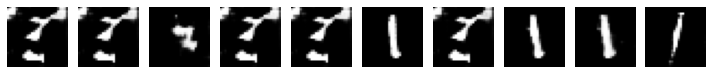

3500 [D loss: 0.073225, acc.: 96.09%] [G loss: 4.030507]
3501 [D loss: 0.058873, acc.: 97.66%] [G loss: 5.922673]
3502 [D loss: 0.077070, acc.: 96.88%] [G loss: 5.014429]
3503 [D loss: 0.078424, acc.: 97.66%] [G loss: 4.126191]
3504 [D loss: 0.036584, acc.: 97.66%] [G loss: 2.564775]
3505 [D loss: 0.048266, acc.: 98.44%] [G loss: 2.661354]
3506 [D loss: 0.042543, acc.: 98.44%] [G loss: 2.373085]
3507 [D loss: 0.052632, acc.: 97.66%] [G loss: 3.057251]
3508 [D loss: 0.090057, acc.: 97.66%] [G loss: 3.034547]
3509 [D loss: 0.050107, acc.: 98.44%] [G loss: 2.683723]
3510 [D loss: 0.070960, acc.: 97.66%] [G loss: 2.159869]
3511 [D loss: 0.074059, acc.: 97.66%] [G loss: 1.400110]
3512 [D loss: 0.053713, acc.: 98.44%] [G loss: 1.070797]
3513 [D loss: 0.086699, acc.: 96.88%] [G loss: 1.698000]
3514 [D loss: 0.053762, acc.: 97.66%] [G loss: 2.891536]
3515 [D loss: 0.037029, acc.: 99.22%] [G loss: 3.936898]
3516 [D loss: 0.018150, acc.: 99.22%] [G loss: 5.058082]
3517 [D loss: 0.183223, acc.: 9

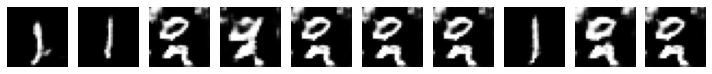

3600 [D loss: 0.126025, acc.: 93.75%] [G loss: 1.109430]
3601 [D loss: 0.156716, acc.: 93.75%] [G loss: 1.071495]
3602 [D loss: 0.034512, acc.: 97.66%] [G loss: 1.774201]
3603 [D loss: 0.041234, acc.: 97.66%] [G loss: 2.362945]
3604 [D loss: 0.147194, acc.: 96.09%] [G loss: 1.357099]
3605 [D loss: 0.085072, acc.: 96.88%] [G loss: 0.878806]
3606 [D loss: 0.088468, acc.: 95.31%] [G loss: 0.652628]
3607 [D loss: 0.069841, acc.: 96.88%] [G loss: 0.629299]
3608 [D loss: 0.019386, acc.: 99.22%] [G loss: 0.882559]
3609 [D loss: 0.025090, acc.: 99.22%] [G loss: 1.489985]
3610 [D loss: 0.060071, acc.: 98.44%] [G loss: 1.225527]
3611 [D loss: 0.057217, acc.: 98.44%] [G loss: 1.219164]
3612 [D loss: 0.090069, acc.: 96.88%] [G loss: 0.766100]
3613 [D loss: 0.060189, acc.: 97.66%] [G loss: 0.921238]
3614 [D loss: 0.058073, acc.: 97.66%] [G loss: 0.901301]
3615 [D loss: 0.085379, acc.: 95.31%] [G loss: 1.301264]
3616 [D loss: 0.007504, acc.: 100.00%] [G loss: 2.015055]
3617 [D loss: 0.042809, acc.: 

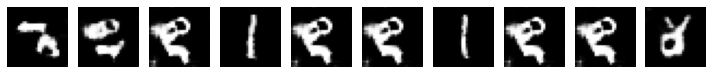

3700 [D loss: 0.049605, acc.: 98.44%] [G loss: 3.674983]
3701 [D loss: 0.049601, acc.: 97.66%] [G loss: 4.872683]
3702 [D loss: 0.037570, acc.: 98.44%] [G loss: 6.384469]
3703 [D loss: 0.059785, acc.: 98.44%] [G loss: 6.365516]
3704 [D loss: 0.013006, acc.: 100.00%] [G loss: 6.747213]
3705 [D loss: 0.055067, acc.: 97.66%] [G loss: 5.562192]
3706 [D loss: 0.067370, acc.: 97.66%] [G loss: 4.298172]
3707 [D loss: 0.075957, acc.: 95.31%] [G loss: 3.775347]
3708 [D loss: 0.069953, acc.: 97.66%] [G loss: 4.464354]
3709 [D loss: 0.037701, acc.: 98.44%] [G loss: 5.604504]
3710 [D loss: 0.029711, acc.: 98.44%] [G loss: 5.580287]
3711 [D loss: 0.049036, acc.: 96.88%] [G loss: 5.022673]
3712 [D loss: 0.039271, acc.: 98.44%] [G loss: 4.711978]
3713 [D loss: 0.025322, acc.: 98.44%] [G loss: 4.523145]
3714 [D loss: 0.017156, acc.: 99.22%] [G loss: 3.761366]
3715 [D loss: 0.065274, acc.: 97.66%] [G loss: 3.409682]
3716 [D loss: 0.054664, acc.: 98.44%] [G loss: 3.191785]
3717 [D loss: 0.064460, acc.: 

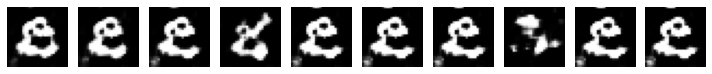

3800 [D loss: 0.046320, acc.: 99.22%] [G loss: 1.076446]
3801 [D loss: 0.012449, acc.: 100.00%] [G loss: 1.128942]
3802 [D loss: 0.027142, acc.: 99.22%] [G loss: 1.375285]
3803 [D loss: 0.025851, acc.: 98.44%] [G loss: 1.313777]
3804 [D loss: 0.027970, acc.: 99.22%] [G loss: 0.979156]
3805 [D loss: 0.039274, acc.: 98.44%] [G loss: 1.181619]
3806 [D loss: 0.010655, acc.: 100.00%] [G loss: 1.366125]
3807 [D loss: 0.068718, acc.: 98.44%] [G loss: 1.499544]
3808 [D loss: 0.015061, acc.: 99.22%] [G loss: 1.591732]
3809 [D loss: 0.032368, acc.: 98.44%] [G loss: 1.380050]
3810 [D loss: 0.030401, acc.: 98.44%] [G loss: 1.088628]
3811 [D loss: 0.094964, acc.: 96.09%] [G loss: 0.926936]
3812 [D loss: 0.050097, acc.: 98.44%] [G loss: 1.085648]
3813 [D loss: 0.058329, acc.: 97.66%] [G loss: 1.328679]
3814 [D loss: 0.043708, acc.: 98.44%] [G loss: 1.550946]
3815 [D loss: 0.060783, acc.: 98.44%] [G loss: 1.509974]
3816 [D loss: 0.024884, acc.: 99.22%] [G loss: 1.113097]
3817 [D loss: 0.046480, acc.:

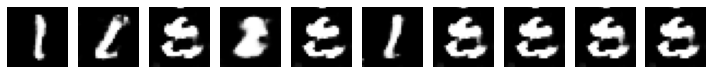

3900 [D loss: 0.029298, acc.: 99.22%] [G loss: 2.830472]
3901 [D loss: 0.013967, acc.: 100.00%] [G loss: 2.521449]
3902 [D loss: 0.061901, acc.: 97.66%] [G loss: 2.695639]
3903 [D loss: 0.038793, acc.: 99.22%] [G loss: 3.210051]
3904 [D loss: 0.043860, acc.: 98.44%] [G loss: 3.167344]
3905 [D loss: 0.049533, acc.: 97.66%] [G loss: 2.235614]
3906 [D loss: 0.067758, acc.: 98.44%] [G loss: 1.666094]
3907 [D loss: 0.049370, acc.: 97.66%] [G loss: 1.126922]
3908 [D loss: 0.070213, acc.: 96.88%] [G loss: 1.621393]
3909 [D loss: 0.078007, acc.: 95.31%] [G loss: 2.873308]
3910 [D loss: 0.019727, acc.: 99.22%] [G loss: 4.006757]
3911 [D loss: 0.056663, acc.: 98.44%] [G loss: 3.664052]
3912 [D loss: 0.053888, acc.: 98.44%] [G loss: 2.542258]
3913 [D loss: 0.046880, acc.: 98.44%] [G loss: 1.857690]
3914 [D loss: 0.174862, acc.: 94.53%] [G loss: 0.585262]
3915 [D loss: 0.105051, acc.: 96.88%] [G loss: 0.669852]
3916 [D loss: 0.052909, acc.: 98.44%] [G loss: 1.025487]
3917 [D loss: 0.130229, acc.: 

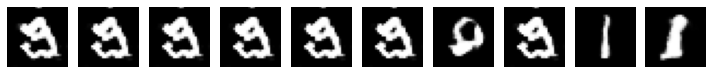

4000 [D loss: 0.067659, acc.: 97.66%] [G loss: 2.103505]
4001 [D loss: 0.017263, acc.: 100.00%] [G loss: 2.698491]
4002 [D loss: 0.086503, acc.: 98.44%] [G loss: 2.075619]
4003 [D loss: 0.025697, acc.: 99.22%] [G loss: 2.537000]
4004 [D loss: 0.015804, acc.: 98.44%] [G loss: 2.760287]
4005 [D loss: 0.047757, acc.: 98.44%] [G loss: 1.654838]
4006 [D loss: 0.008495, acc.: 100.00%] [G loss: 1.431334]
4007 [D loss: 0.024547, acc.: 99.22%] [G loss: 1.048738]
4008 [D loss: 0.032532, acc.: 99.22%] [G loss: 1.048820]
4009 [D loss: 0.028730, acc.: 100.00%] [G loss: 1.754123]
4010 [D loss: 0.016066, acc.: 99.22%] [G loss: 3.427217]
4011 [D loss: 0.035376, acc.: 99.22%] [G loss: 3.749462]
4012 [D loss: 0.072081, acc.: 97.66%] [G loss: 2.943730]
4013 [D loss: 0.046249, acc.: 97.66%] [G loss: 2.730947]
4014 [D loss: 0.021940, acc.: 100.00%] [G loss: 3.322473]
4015 [D loss: 0.012689, acc.: 100.00%] [G loss: 4.217029]
4016 [D loss: 0.120937, acc.: 96.88%] [G loss: 3.004364]
4017 [D loss: 0.017528, ac

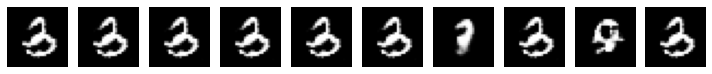

4100 [D loss: 0.043713, acc.: 99.22%] [G loss: 3.655843]
4101 [D loss: 0.025223, acc.: 99.22%] [G loss: 4.539263]
4102 [D loss: 0.031717, acc.: 99.22%] [G loss: 5.543972]
4103 [D loss: 0.025543, acc.: 98.44%] [G loss: 4.783672]
4104 [D loss: 0.050815, acc.: 98.44%] [G loss: 4.696950]
4105 [D loss: 0.012561, acc.: 99.22%] [G loss: 4.371047]
4106 [D loss: 0.029530, acc.: 99.22%] [G loss: 3.853734]
4107 [D loss: 0.121696, acc.: 96.09%] [G loss: 3.652741]
4108 [D loss: 0.016278, acc.: 100.00%] [G loss: 3.796122]
4109 [D loss: 0.136089, acc.: 95.31%] [G loss: 2.890570]
4110 [D loss: 0.017129, acc.: 100.00%] [G loss: 3.830026]
4111 [D loss: 0.036177, acc.: 99.22%] [G loss: 3.622404]
4112 [D loss: 0.078788, acc.: 96.88%] [G loss: 3.960284]
4113 [D loss: 0.056029, acc.: 97.66%] [G loss: 4.328525]
4114 [D loss: 0.063937, acc.: 96.88%] [G loss: 3.213169]
4115 [D loss: 0.054403, acc.: 97.66%] [G loss: 2.277359]
4116 [D loss: 0.070308, acc.: 96.09%] [G loss: 1.968053]
4117 [D loss: 0.024977, acc.:

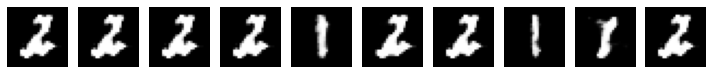

4200 [D loss: 0.185802, acc.: 92.97%] [G loss: 2.046798]
4201 [D loss: 0.059906, acc.: 96.09%] [G loss: 1.909363]
4202 [D loss: 0.059920, acc.: 97.66%] [G loss: 2.846413]
4203 [D loss: 0.010417, acc.: 100.00%] [G loss: 3.691149]
4204 [D loss: 0.153418, acc.: 94.53%] [G loss: 3.641986]
4205 [D loss: 0.052728, acc.: 97.66%] [G loss: 3.177285]
4206 [D loss: 0.063712, acc.: 96.88%] [G loss: 3.204048]
4207 [D loss: 0.048211, acc.: 99.22%] [G loss: 3.585297]
4208 [D loss: 0.093475, acc.: 96.09%] [G loss: 3.405623]
4209 [D loss: 0.054072, acc.: 97.66%] [G loss: 3.120798]
4210 [D loss: 0.041903, acc.: 98.44%] [G loss: 2.787191]
4211 [D loss: 0.068134, acc.: 98.44%] [G loss: 1.994082]
4212 [D loss: 0.054576, acc.: 98.44%] [G loss: 1.888011]
4213 [D loss: 0.079753, acc.: 99.22%] [G loss: 1.857384]
4214 [D loss: 0.105344, acc.: 98.44%] [G loss: 2.730079]
4215 [D loss: 0.081720, acc.: 97.66%] [G loss: 2.565611]
4216 [D loss: 0.038107, acc.: 99.22%] [G loss: 2.992918]
4217 [D loss: 0.039959, acc.: 

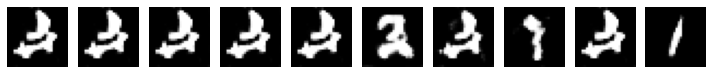

4300 [D loss: 0.029034, acc.: 98.44%] [G loss: 3.034868]
4301 [D loss: 0.079966, acc.: 96.88%] [G loss: 2.995869]
4302 [D loss: 0.073654, acc.: 96.88%] [G loss: 2.884753]
4303 [D loss: 0.092210, acc.: 94.53%] [G loss: 3.509444]
4304 [D loss: 0.031098, acc.: 99.22%] [G loss: 4.108656]
4305 [D loss: 0.177486, acc.: 94.53%] [G loss: 1.866640]
4306 [D loss: 0.035900, acc.: 98.44%] [G loss: 1.252567]
4307 [D loss: 0.089597, acc.: 96.88%] [G loss: 2.385891]
4308 [D loss: 0.063017, acc.: 96.88%] [G loss: 4.472803]
4309 [D loss: 0.092576, acc.: 98.44%] [G loss: 5.412962]
4310 [D loss: 0.012615, acc.: 100.00%] [G loss: 7.063640]
4311 [D loss: 0.224397, acc.: 96.09%] [G loss: 6.502379]
4312 [D loss: 0.031845, acc.: 98.44%] [G loss: 6.050597]
4313 [D loss: 0.112201, acc.: 95.31%] [G loss: 5.624543]
4314 [D loss: 0.041668, acc.: 98.44%] [G loss: 5.079898]
4315 [D loss: 0.052086, acc.: 98.44%] [G loss: 4.757947]
4316 [D loss: 0.058501, acc.: 97.66%] [G loss: 4.764418]
4317 [D loss: 0.052512, acc.: 

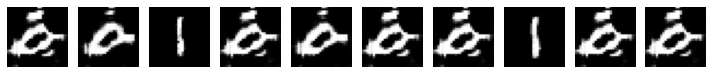

4400 [D loss: 0.026413, acc.: 98.44%] [G loss: 2.303914]
4401 [D loss: 0.023385, acc.: 100.00%] [G loss: 2.509240]
4402 [D loss: 0.045544, acc.: 97.66%] [G loss: 2.270810]
4403 [D loss: 0.077812, acc.: 96.09%] [G loss: 1.203587]
4404 [D loss: 0.054230, acc.: 98.44%] [G loss: 0.574031]
4405 [D loss: 0.055413, acc.: 96.09%] [G loss: 0.562925]
4406 [D loss: 0.040431, acc.: 98.44%] [G loss: 0.681809]
4407 [D loss: 0.024167, acc.: 99.22%] [G loss: 0.983584]
4408 [D loss: 0.069419, acc.: 95.31%] [G loss: 0.897483]
4409 [D loss: 0.101215, acc.: 95.31%] [G loss: 0.661472]
4410 [D loss: 0.102263, acc.: 96.09%] [G loss: 0.674702]
4411 [D loss: 0.060904, acc.: 97.66%] [G loss: 0.947728]
4412 [D loss: 0.032675, acc.: 97.66%] [G loss: 1.799329]
4413 [D loss: 0.022425, acc.: 99.22%] [G loss: 2.410335]
4414 [D loss: 0.064110, acc.: 96.09%] [G loss: 2.180703]
4415 [D loss: 0.062911, acc.: 97.66%] [G loss: 1.145285]
4416 [D loss: 0.042181, acc.: 97.66%] [G loss: 1.589347]
4417 [D loss: 0.015093, acc.: 

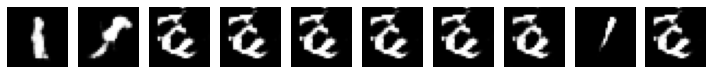

4500 [D loss: 0.051884, acc.: 99.22%] [G loss: 5.876939]
4501 [D loss: 0.070697, acc.: 97.66%] [G loss: 4.876805]
4502 [D loss: 0.056129, acc.: 97.66%] [G loss: 5.263420]
4503 [D loss: 0.030655, acc.: 99.22%] [G loss: 5.693212]
4504 [D loss: 0.056155, acc.: 96.88%] [G loss: 6.138074]
4505 [D loss: 0.020838, acc.: 99.22%] [G loss: 5.495453]
4506 [D loss: 0.021187, acc.: 99.22%] [G loss: 5.258472]
4507 [D loss: 0.075845, acc.: 98.44%] [G loss: 4.183041]
4508 [D loss: 0.039451, acc.: 97.66%] [G loss: 4.401805]
4509 [D loss: 0.025770, acc.: 99.22%] [G loss: 6.415317]
4510 [D loss: 0.046744, acc.: 97.66%] [G loss: 6.656692]
4511 [D loss: 0.027748, acc.: 99.22%] [G loss: 7.798220]
4512 [D loss: 0.142793, acc.: 94.53%] [G loss: 6.378271]
4513 [D loss: 0.046312, acc.: 98.44%] [G loss: 5.928806]
4514 [D loss: 0.063152, acc.: 96.88%] [G loss: 6.065264]
4515 [D loss: 0.041168, acc.: 98.44%] [G loss: 6.913623]
4516 [D loss: 0.004888, acc.: 100.00%] [G loss: 7.309729]
4517 [D loss: 0.131363, acc.: 

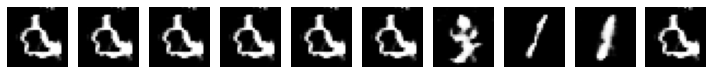

4600 [D loss: 0.068511, acc.: 97.66%] [G loss: 5.923567]
4601 [D loss: 0.082770, acc.: 97.66%] [G loss: 6.951899]
4602 [D loss: 0.018003, acc.: 100.00%] [G loss: 7.510278]
4603 [D loss: 0.043659, acc.: 97.66%] [G loss: 6.828034]
4604 [D loss: 0.063097, acc.: 96.88%] [G loss: 5.688357]
4605 [D loss: 0.031034, acc.: 99.22%] [G loss: 4.751723]
4606 [D loss: 0.028141, acc.: 98.44%] [G loss: 3.964209]
4607 [D loss: 0.046112, acc.: 99.22%] [G loss: 3.935631]
4608 [D loss: 0.031810, acc.: 98.44%] [G loss: 4.046533]
4609 [D loss: 0.024958, acc.: 99.22%] [G loss: 5.104375]
4610 [D loss: 0.059709, acc.: 96.88%] [G loss: 4.540298]
4611 [D loss: 0.064057, acc.: 97.66%] [G loss: 3.963934]
4612 [D loss: 0.033270, acc.: 99.22%] [G loss: 3.735452]
4613 [D loss: 0.052865, acc.: 96.88%] [G loss: 3.875024]
4614 [D loss: 0.049091, acc.: 98.44%] [G loss: 4.019035]
4615 [D loss: 0.011744, acc.: 100.00%] [G loss: 3.964357]
4616 [D loss: 0.057915, acc.: 97.66%] [G loss: 3.725370]
4617 [D loss: 0.017438, acc.:

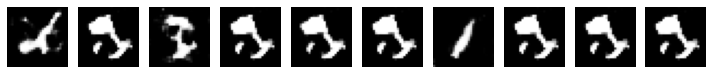

4700 [D loss: 0.017368, acc.: 100.00%] [G loss: 1.650757]
4701 [D loss: 0.013815, acc.: 99.22%] [G loss: 2.282942]
4702 [D loss: 0.129673, acc.: 95.31%] [G loss: 1.208453]
4703 [D loss: 0.045722, acc.: 98.44%] [G loss: 0.489406]
4704 [D loss: 0.049510, acc.: 97.66%] [G loss: 0.549647]
4705 [D loss: 0.032858, acc.: 98.44%] [G loss: 0.701221]
4706 [D loss: 0.025408, acc.: 99.22%] [G loss: 0.984034]
4707 [D loss: 0.019856, acc.: 99.22%] [G loss: 1.043069]
4708 [D loss: 0.054859, acc.: 97.66%] [G loss: 1.015088]
4709 [D loss: 0.059085, acc.: 96.88%] [G loss: 0.651866]
4710 [D loss: 0.062536, acc.: 97.66%] [G loss: 0.636166]
4711 [D loss: 0.032882, acc.: 97.66%] [G loss: 0.509973]
4712 [D loss: 0.027250, acc.: 99.22%] [G loss: 0.979297]
4713 [D loss: 0.011608, acc.: 100.00%] [G loss: 1.969519]
4714 [D loss: 0.078604, acc.: 96.88%] [G loss: 1.730300]
4715 [D loss: 0.069072, acc.: 96.09%] [G loss: 1.185388]
4716 [D loss: 0.053327, acc.: 96.88%] [G loss: 1.337973]
4717 [D loss: 0.031659, acc.:

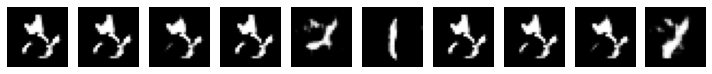

4800 [D loss: 0.081286, acc.: 97.66%] [G loss: 3.491636]
4801 [D loss: 0.005330, acc.: 100.00%] [G loss: 3.734991]
4802 [D loss: 0.060758, acc.: 97.66%] [G loss: 2.907244]
4803 [D loss: 0.031438, acc.: 99.22%] [G loss: 2.406084]
4804 [D loss: 0.042233, acc.: 98.44%] [G loss: 1.602867]
4805 [D loss: 0.026493, acc.: 99.22%] [G loss: 1.550476]
4806 [D loss: 0.052765, acc.: 96.88%] [G loss: 2.113036]
4807 [D loss: 0.009630, acc.: 100.00%] [G loss: 3.849195]
4808 [D loss: 0.006915, acc.: 100.00%] [G loss: 6.455468]
4809 [D loss: 0.062170, acc.: 98.44%] [G loss: 5.939887]
4810 [D loss: 0.050407, acc.: 98.44%] [G loss: 4.053479]
4811 [D loss: 0.006438, acc.: 100.00%] [G loss: 3.350036]
4812 [D loss: 0.089087, acc.: 96.88%] [G loss: 2.294126]
4813 [D loss: 0.035609, acc.: 98.44%] [G loss: 3.313051]
4814 [D loss: 0.025644, acc.: 99.22%] [G loss: 4.734624]
4815 [D loss: 0.054460, acc.: 96.88%] [G loss: 4.421365]
4816 [D loss: 0.029168, acc.: 99.22%] [G loss: 3.470168]
4817 [D loss: 0.064853, acc

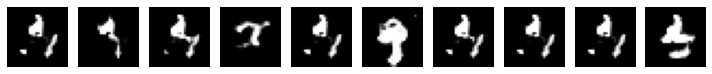

4900 [D loss: 0.054840, acc.: 96.88%] [G loss: 4.129746]
4901 [D loss: 0.016520, acc.: 100.00%] [G loss: 4.719507]
4902 [D loss: 0.022384, acc.: 99.22%] [G loss: 4.943644]
4903 [D loss: 0.022149, acc.: 99.22%] [G loss: 5.487016]
4904 [D loss: 0.066032, acc.: 97.66%] [G loss: 5.806506]
4905 [D loss: 0.013153, acc.: 99.22%] [G loss: 6.048151]
4906 [D loss: 0.044065, acc.: 98.44%] [G loss: 5.685458]
4907 [D loss: 0.030461, acc.: 99.22%] [G loss: 5.553028]
4908 [D loss: 0.021282, acc.: 100.00%] [G loss: 5.028325]
4909 [D loss: 0.018007, acc.: 99.22%] [G loss: 4.928224]
4910 [D loss: 0.064191, acc.: 98.44%] [G loss: 4.805465]
4911 [D loss: 0.063347, acc.: 97.66%] [G loss: 4.654107]
4912 [D loss: 0.101120, acc.: 96.88%] [G loss: 3.682091]
4913 [D loss: 0.087167, acc.: 96.09%] [G loss: 4.068058]
4914 [D loss: 0.158192, acc.: 95.31%] [G loss: 4.639320]
4915 [D loss: 0.036120, acc.: 98.44%] [G loss: 5.075429]
4916 [D loss: 0.025990, acc.: 99.22%] [G loss: 5.553136]
4917 [D loss: 0.077940, acc.:

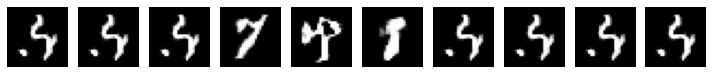

5000 [D loss: 0.008351, acc.: 100.00%] [G loss: 4.786657]
5001 [D loss: 0.013368, acc.: 99.22%] [G loss: 5.578844]
5002 [D loss: 0.079295, acc.: 96.09%] [G loss: 5.357377]
5003 [D loss: 0.024775, acc.: 99.22%] [G loss: 5.846442]
5004 [D loss: 0.097912, acc.: 95.31%] [G loss: 4.325244]
5005 [D loss: 0.061806, acc.: 96.88%] [G loss: 4.359698]
5006 [D loss: 0.064578, acc.: 98.44%] [G loss: 5.922276]
5007 [D loss: 0.017550, acc.: 99.22%] [G loss: 7.610138]
5008 [D loss: 0.058395, acc.: 96.88%] [G loss: 6.724043]
5009 [D loss: 0.097199, acc.: 96.88%] [G loss: 6.358654]
5010 [D loss: 0.022562, acc.: 99.22%] [G loss: 5.634218]
5011 [D loss: 0.029421, acc.: 98.44%] [G loss: 5.952105]
5012 [D loss: 0.063012, acc.: 96.09%] [G loss: 6.434500]
5013 [D loss: 0.040824, acc.: 97.66%] [G loss: 7.564941]
5014 [D loss: 0.091192, acc.: 96.09%] [G loss: 6.950050]
5015 [D loss: 0.086733, acc.: 96.09%] [G loss: 5.467434]
5016 [D loss: 0.072317, acc.: 96.88%] [G loss: 4.520942]
5017 [D loss: 0.037317, acc.: 

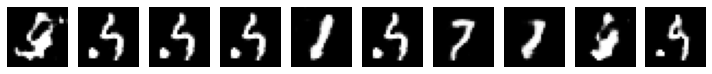

5100 [D loss: 0.026764, acc.: 99.22%] [G loss: 6.908360]
5101 [D loss: 0.039464, acc.: 98.44%] [G loss: 7.853076]
5102 [D loss: 0.026812, acc.: 98.44%] [G loss: 7.838747]
5103 [D loss: 0.079857, acc.: 96.09%] [G loss: 7.536444]
5104 [D loss: 0.025838, acc.: 99.22%] [G loss: 7.601915]
5105 [D loss: 0.125895, acc.: 96.88%] [G loss: 6.024776]
5106 [D loss: 0.093303, acc.: 94.53%] [G loss: 5.050123]
5107 [D loss: 0.119036, acc.: 96.09%] [G loss: 6.193687]
5108 [D loss: 0.058644, acc.: 97.66%] [G loss: 7.263286]
5109 [D loss: 0.043228, acc.: 98.44%] [G loss: 8.539023]
5110 [D loss: 0.078072, acc.: 96.88%] [G loss: 8.621111]
5111 [D loss: 0.120479, acc.: 95.31%] [G loss: 6.887902]
5112 [D loss: 0.037321, acc.: 98.44%] [G loss: 6.214112]
5113 [D loss: 0.092624, acc.: 96.09%] [G loss: 5.327606]
5114 [D loss: 0.033298, acc.: 98.44%] [G loss: 6.489596]
5115 [D loss: 0.014201, acc.: 100.00%] [G loss: 6.754670]
5116 [D loss: 0.061669, acc.: 96.88%] [G loss: 6.769665]
5117 [D loss: 0.058273, acc.: 

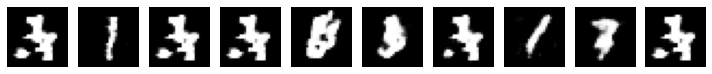

5200 [D loss: 0.034617, acc.: 99.22%] [G loss: 2.731196]
5201 [D loss: 0.030355, acc.: 98.44%] [G loss: 3.087687]
5202 [D loss: 0.063904, acc.: 97.66%] [G loss: 3.072754]
5203 [D loss: 0.028948, acc.: 99.22%] [G loss: 2.211676]
5204 [D loss: 0.015589, acc.: 100.00%] [G loss: 1.816488]
5205 [D loss: 0.041708, acc.: 98.44%] [G loss: 1.381295]
5206 [D loss: 0.055401, acc.: 97.66%] [G loss: 1.114770]
5207 [D loss: 0.030472, acc.: 99.22%] [G loss: 1.235947]
5208 [D loss: 0.022108, acc.: 99.22%] [G loss: 1.423670]
5209 [D loss: 0.046358, acc.: 98.44%] [G loss: 1.235862]
5210 [D loss: 0.015724, acc.: 100.00%] [G loss: 1.235940]
5211 [D loss: 0.096437, acc.: 96.88%] [G loss: 1.793094]
5212 [D loss: 0.064008, acc.: 97.66%] [G loss: 1.976014]
5213 [D loss: 0.044776, acc.: 98.44%] [G loss: 2.231448]
5214 [D loss: 0.011472, acc.: 99.22%] [G loss: 2.172171]
5215 [D loss: 0.025448, acc.: 99.22%] [G loss: 2.250476]
5216 [D loss: 0.010217, acc.: 100.00%] [G loss: 1.661558]
5217 [D loss: 0.047904, acc.

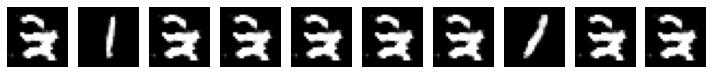

5300 [D loss: 0.059226, acc.: 98.44%] [G loss: 2.472181]
5301 [D loss: 0.025735, acc.: 99.22%] [G loss: 1.956922]
5302 [D loss: 0.041248, acc.: 99.22%] [G loss: 1.139043]
5303 [D loss: 0.033446, acc.: 97.66%] [G loss: 1.107432]
5304 [D loss: 0.063996, acc.: 97.66%] [G loss: 1.108236]
5305 [D loss: 0.085072, acc.: 96.09%] [G loss: 1.787134]
5306 [D loss: 0.029042, acc.: 98.44%] [G loss: 3.960067]
5307 [D loss: 0.043064, acc.: 99.22%] [G loss: 4.874540]
5308 [D loss: 0.007928, acc.: 100.00%] [G loss: 5.095237]
5309 [D loss: 0.080012, acc.: 97.66%] [G loss: 4.680430]
5310 [D loss: 0.058309, acc.: 97.66%] [G loss: 2.880033]
5311 [D loss: 0.008671, acc.: 100.00%] [G loss: 2.067267]
5312 [D loss: 0.063212, acc.: 97.66%] [G loss: 1.102129]
5313 [D loss: 0.055545, acc.: 97.66%] [G loss: 0.817458]
5314 [D loss: 0.041525, acc.: 98.44%] [G loss: 0.877426]
5315 [D loss: 0.033108, acc.: 98.44%] [G loss: 0.953684]
5316 [D loss: 0.020083, acc.: 100.00%] [G loss: 1.173146]
5317 [D loss: 0.077918, acc.

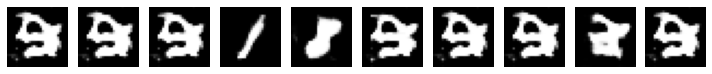

5400 [D loss: 0.039836, acc.: 97.66%] [G loss: 3.586704]
5401 [D loss: 0.063195, acc.: 96.88%] [G loss: 3.542271]
5402 [D loss: 0.118386, acc.: 93.75%] [G loss: 2.176704]
5403 [D loss: 0.046818, acc.: 97.66%] [G loss: 1.310858]
5404 [D loss: 0.326297, acc.: 92.19%] [G loss: 1.532469]
5405 [D loss: 0.024344, acc.: 99.22%] [G loss: 4.695301]
5406 [D loss: 0.080019, acc.: 96.88%] [G loss: 5.923613]
5407 [D loss: 0.143681, acc.: 93.75%] [G loss: 4.251227]
5408 [D loss: 0.122818, acc.: 95.31%] [G loss: 3.046703]
5409 [D loss: 0.081444, acc.: 96.88%] [G loss: 2.289361]
5410 [D loss: 0.076408, acc.: 96.88%] [G loss: 2.296055]
5411 [D loss: 0.079668, acc.: 98.44%] [G loss: 3.662039]
5412 [D loss: 0.053616, acc.: 98.44%] [G loss: 4.542152]
5413 [D loss: 0.075664, acc.: 97.66%] [G loss: 4.140790]
5414 [D loss: 0.004821, acc.: 100.00%] [G loss: 3.660450]
5415 [D loss: 0.063216, acc.: 97.66%] [G loss: 2.614151]
5416 [D loss: 0.049972, acc.: 97.66%] [G loss: 1.500571]
5417 [D loss: 0.049773, acc.: 

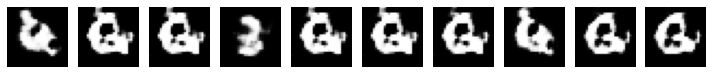

5500 [D loss: 0.059788, acc.: 97.66%] [G loss: 0.987479]
5501 [D loss: 0.056509, acc.: 98.44%] [G loss: 0.732911]
5502 [D loss: 0.014920, acc.: 100.00%] [G loss: 0.709059]
5503 [D loss: 0.034952, acc.: 98.44%] [G loss: 0.658666]
5504 [D loss: 0.057897, acc.: 97.66%] [G loss: 0.391762]
5505 [D loss: 0.024255, acc.: 98.44%] [G loss: 0.623702]
5506 [D loss: 0.061926, acc.: 96.88%] [G loss: 0.828218]
5507 [D loss: 0.026893, acc.: 98.44%] [G loss: 1.640772]
5508 [D loss: 0.032781, acc.: 99.22%] [G loss: 2.134503]
5509 [D loss: 0.022745, acc.: 97.66%] [G loss: 1.849161]
5510 [D loss: 0.002133, acc.: 100.00%] [G loss: 1.771075]
5511 [D loss: 0.054714, acc.: 96.88%] [G loss: 0.987326]
5512 [D loss: 0.076484, acc.: 97.66%] [G loss: 0.608653]
5513 [D loss: 0.086001, acc.: 96.09%] [G loss: 0.625261]
5514 [D loss: 0.031321, acc.: 98.44%] [G loss: 0.962955]
5515 [D loss: 0.034090, acc.: 99.22%] [G loss: 1.421717]
5516 [D loss: 0.033110, acc.: 99.22%] [G loss: 1.153077]
5517 [D loss: 0.036711, acc.:

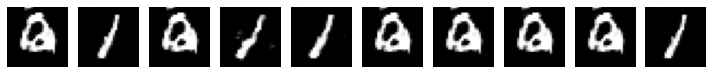

5600 [D loss: 0.035361, acc.: 98.44%] [G loss: 1.778247]
5601 [D loss: 0.105540, acc.: 98.44%] [G loss: 1.410610]
5602 [D loss: 0.009573, acc.: 99.22%] [G loss: 1.650820]
5603 [D loss: 0.079373, acc.: 96.09%] [G loss: 1.329463]
5604 [D loss: 0.027753, acc.: 99.22%] [G loss: 1.681033]
5605 [D loss: 0.069830, acc.: 96.09%] [G loss: 1.993367]
5606 [D loss: 0.051030, acc.: 97.66%] [G loss: 2.554581]
5607 [D loss: 0.042545, acc.: 97.66%] [G loss: 3.185217]
5608 [D loss: 0.026396, acc.: 98.44%] [G loss: 4.600309]
5609 [D loss: 0.138077, acc.: 92.97%] [G loss: 1.577510]
5610 [D loss: 0.037647, acc.: 99.22%] [G loss: 0.739918]
5611 [D loss: 0.096561, acc.: 94.53%] [G loss: 0.999663]
5612 [D loss: 0.050224, acc.: 98.44%] [G loss: 2.907969]
5613 [D loss: 0.047504, acc.: 96.88%] [G loss: 4.469711]
5614 [D loss: 0.031393, acc.: 99.22%] [G loss: 5.239585]
5615 [D loss: 0.037590, acc.: 98.44%] [G loss: 4.967408]
5616 [D loss: 0.065419, acc.: 99.22%] [G loss: 3.101235]
5617 [D loss: 0.018934, acc.: 1

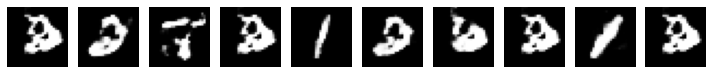

5700 [D loss: 0.050210, acc.: 98.44%] [G loss: 1.956367]
5701 [D loss: 0.030276, acc.: 99.22%] [G loss: 2.458658]
5702 [D loss: 0.111580, acc.: 96.09%] [G loss: 1.522859]
5703 [D loss: 0.028560, acc.: 99.22%] [G loss: 1.489763]
5704 [D loss: 0.065066, acc.: 96.88%] [G loss: 1.624529]
5705 [D loss: 0.039605, acc.: 99.22%] [G loss: 2.293491]
5706 [D loss: 0.081043, acc.: 96.88%] [G loss: 2.434947]
5707 [D loss: 0.049998, acc.: 98.44%] [G loss: 2.812100]
5708 [D loss: 0.081760, acc.: 96.09%] [G loss: 1.982819]
5709 [D loss: 0.032053, acc.: 98.44%] [G loss: 2.286031]
5710 [D loss: 0.091572, acc.: 96.09%] [G loss: 2.327548]
5711 [D loss: 0.023690, acc.: 99.22%] [G loss: 3.195916]
5712 [D loss: 0.057528, acc.: 97.66%] [G loss: 3.506595]
5713 [D loss: 0.104201, acc.: 96.09%] [G loss: 1.154806]
5714 [D loss: 0.069402, acc.: 96.88%] [G loss: 0.619939]
5715 [D loss: 0.059935, acc.: 96.88%] [G loss: 1.090663]
5716 [D loss: 0.011171, acc.: 99.22%] [G loss: 2.303900]
5717 [D loss: 0.036456, acc.: 9

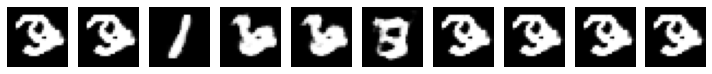

5800 [D loss: 0.007182, acc.: 100.00%] [G loss: 4.749213]
5801 [D loss: 0.005394, acc.: 100.00%] [G loss: 4.842339]
5802 [D loss: 0.148974, acc.: 96.09%] [G loss: 4.009806]
5803 [D loss: 0.028052, acc.: 98.44%] [G loss: 3.625118]
5804 [D loss: 0.010314, acc.: 100.00%] [G loss: 3.213691]
5805 [D loss: 0.044022, acc.: 97.66%] [G loss: 3.306396]
5806 [D loss: 0.077951, acc.: 97.66%] [G loss: 3.613545]
5807 [D loss: 0.011731, acc.: 100.00%] [G loss: 4.763856]
5808 [D loss: 0.046597, acc.: 98.44%] [G loss: 4.810347]
5809 [D loss: 0.035253, acc.: 99.22%] [G loss: 4.527864]
5810 [D loss: 0.027713, acc.: 98.44%] [G loss: 5.441956]
5811 [D loss: 0.005888, acc.: 100.00%] [G loss: 5.684232]
5812 [D loss: 0.061279, acc.: 98.44%] [G loss: 5.577643]
5813 [D loss: 0.050757, acc.: 98.44%] [G loss: 3.870269]
5814 [D loss: 0.018379, acc.: 99.22%] [G loss: 2.388083]
5815 [D loss: 0.067551, acc.: 96.88%] [G loss: 1.346443]
5816 [D loss: 0.086422, acc.: 96.88%] [G loss: 2.985702]
5817 [D loss: 0.044060, ac

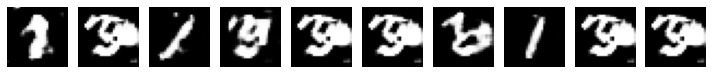

5900 [D loss: 0.018942, acc.: 100.00%] [G loss: 3.380310]
5901 [D loss: 0.028523, acc.: 99.22%] [G loss: 2.971237]
5902 [D loss: 0.027022, acc.: 99.22%] [G loss: 3.377976]
5903 [D loss: 0.042488, acc.: 97.66%] [G loss: 3.556037]
5904 [D loss: 0.016558, acc.: 100.00%] [G loss: 2.065263]
5905 [D loss: 0.028559, acc.: 99.22%] [G loss: 1.538013]
5906 [D loss: 0.044994, acc.: 97.66%] [G loss: 2.335183]
5907 [D loss: 0.037510, acc.: 99.22%] [G loss: 3.748270]
5908 [D loss: 0.042962, acc.: 98.44%] [G loss: 3.020010]
5909 [D loss: 0.098910, acc.: 96.88%] [G loss: 2.652786]
5910 [D loss: 0.054184, acc.: 96.88%] [G loss: 1.740650]
5911 [D loss: 0.099611, acc.: 94.53%] [G loss: 1.054538]
5912 [D loss: 0.017761, acc.: 100.00%] [G loss: 1.653260]
5913 [D loss: 0.090636, acc.: 97.66%] [G loss: 1.721820]
5914 [D loss: 0.004231, acc.: 100.00%] [G loss: 2.329615]
5915 [D loss: 0.014577, acc.: 99.22%] [G loss: 2.900447]
5916 [D loss: 0.093593, acc.: 97.66%] [G loss: 2.291291]
5917 [D loss: 0.068788, acc

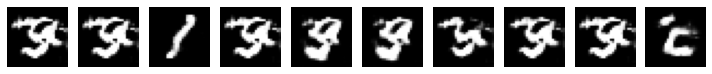

6000 [D loss: 0.042409, acc.: 97.66%] [G loss: 2.775307]
6001 [D loss: 0.048461, acc.: 97.66%] [G loss: 2.894906]
6002 [D loss: 0.083010, acc.: 95.31%] [G loss: 2.078271]
6003 [D loss: 0.016317, acc.: 100.00%] [G loss: 2.588290]
6004 [D loss: 0.117644, acc.: 94.53%] [G loss: 2.513797]
6005 [D loss: 0.021667, acc.: 99.22%] [G loss: 2.750956]
6006 [D loss: 0.043716, acc.: 97.66%] [G loss: 2.927666]
6007 [D loss: 0.018507, acc.: 100.00%] [G loss: 3.509954]
6008 [D loss: 0.082373, acc.: 97.66%] [G loss: 3.748585]
6009 [D loss: 0.056657, acc.: 97.66%] [G loss: 3.328059]
6010 [D loss: 0.054567, acc.: 96.88%] [G loss: 3.656127]
6011 [D loss: 0.032139, acc.: 98.44%] [G loss: 4.560954]
6012 [D loss: 0.090007, acc.: 97.66%] [G loss: 4.022214]
6013 [D loss: 0.022217, acc.: 100.00%] [G loss: 3.498705]
6014 [D loss: 0.042746, acc.: 98.44%] [G loss: 2.668089]
6015 [D loss: 0.108166, acc.: 93.75%] [G loss: 1.390539]
6016 [D loss: 0.053872, acc.: 96.88%] [G loss: 1.810974]
6017 [D loss: 0.064833, acc.

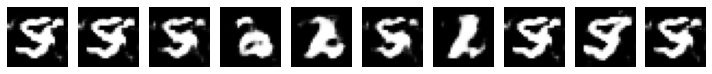

6100 [D loss: 0.059167, acc.: 98.44%] [G loss: 2.125730]
6101 [D loss: 0.019522, acc.: 98.44%] [G loss: 2.283402]
6102 [D loss: 0.058646, acc.: 97.66%] [G loss: 1.770423]
6103 [D loss: 0.046479, acc.: 96.88%] [G loss: 1.814136]
6104 [D loss: 0.033361, acc.: 99.22%] [G loss: 2.570693]
6105 [D loss: 0.025823, acc.: 99.22%] [G loss: 3.370762]
6106 [D loss: 0.089177, acc.: 96.88%] [G loss: 2.657322]
6107 [D loss: 0.028313, acc.: 98.44%] [G loss: 2.191843]
6108 [D loss: 0.047595, acc.: 97.66%] [G loss: 1.328526]
6109 [D loss: 0.071999, acc.: 97.66%] [G loss: 1.040570]
6110 [D loss: 0.059164, acc.: 96.88%] [G loss: 1.730469]
6111 [D loss: 0.065401, acc.: 98.44%] [G loss: 3.067123]
6112 [D loss: 0.061639, acc.: 98.44%] [G loss: 3.966959]
6113 [D loss: 0.087886, acc.: 97.66%] [G loss: 3.925986]
6114 [D loss: 0.012755, acc.: 99.22%] [G loss: 3.971594]
6115 [D loss: 0.135186, acc.: 96.88%] [G loss: 2.042139]
6116 [D loss: 0.055191, acc.: 96.88%] [G loss: 1.427758]
6117 [D loss: 0.051777, acc.: 9

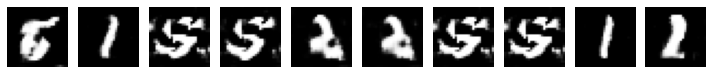

6200 [D loss: 0.021171, acc.: 98.44%] [G loss: 2.430502]
6201 [D loss: 0.006200, acc.: 100.00%] [G loss: 3.270764]
6202 [D loss: 0.007049, acc.: 100.00%] [G loss: 3.136275]
6203 [D loss: 0.050757, acc.: 98.44%] [G loss: 2.522089]
6204 [D loss: 0.008624, acc.: 100.00%] [G loss: 1.673141]
6205 [D loss: 0.004808, acc.: 100.00%] [G loss: 1.353497]
6206 [D loss: 0.024635, acc.: 98.44%] [G loss: 1.508222]
6207 [D loss: 0.011189, acc.: 100.00%] [G loss: 2.532088]
6208 [D loss: 0.006824, acc.: 100.00%] [G loss: 3.425361]
6209 [D loss: 0.007263, acc.: 100.00%] [G loss: 4.704871]
6210 [D loss: 0.043759, acc.: 98.44%] [G loss: 4.037905]
6211 [D loss: 0.051731, acc.: 97.66%] [G loss: 1.928275]
6212 [D loss: 0.036451, acc.: 98.44%] [G loss: 1.164099]
6213 [D loss: 0.070827, acc.: 96.88%] [G loss: 1.318720]
6214 [D loss: 0.083243, acc.: 97.66%] [G loss: 3.708124]
6215 [D loss: 0.006161, acc.: 100.00%] [G loss: 7.729267]
6216 [D loss: 0.134837, acc.: 94.53%] [G loss: 4.720757]
6217 [D loss: 0.041113,

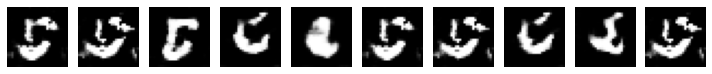

6300 [D loss: 0.020012, acc.: 100.00%] [G loss: 1.755025]
6301 [D loss: 0.037031, acc.: 97.66%] [G loss: 1.363936]
6302 [D loss: 0.055847, acc.: 97.66%] [G loss: 1.640494]
6303 [D loss: 0.052133, acc.: 97.66%] [G loss: 2.242071]
6304 [D loss: 0.001789, acc.: 100.00%] [G loss: 3.513393]
6305 [D loss: 0.085869, acc.: 97.66%] [G loss: 3.762600]
6306 [D loss: 0.108107, acc.: 96.09%] [G loss: 1.789065]
6307 [D loss: 0.063034, acc.: 99.22%] [G loss: 1.313849]
6308 [D loss: 0.056326, acc.: 98.44%] [G loss: 2.382370]
6309 [D loss: 0.004586, acc.: 100.00%] [G loss: 4.008434]
6310 [D loss: 0.071240, acc.: 97.66%] [G loss: 4.261963]
6311 [D loss: 0.006636, acc.: 100.00%] [G loss: 3.789845]
6312 [D loss: 0.107426, acc.: 96.09%] [G loss: 2.762057]
6313 [D loss: 0.082189, acc.: 96.88%] [G loss: 1.305177]
6314 [D loss: 0.016312, acc.: 100.00%] [G loss: 1.408849]
6315 [D loss: 0.044918, acc.: 98.44%] [G loss: 2.583418]
6316 [D loss: 0.068182, acc.: 96.88%] [G loss: 3.523056]
6317 [D loss: 0.055732, ac

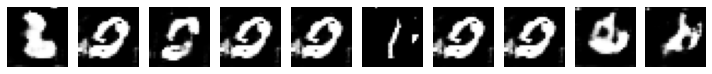

6400 [D loss: 0.019484, acc.: 99.22%] [G loss: 0.790102]
6401 [D loss: 0.013883, acc.: 100.00%] [G loss: 1.677449]
6402 [D loss: 0.030775, acc.: 99.22%] [G loss: 2.249076]
6403 [D loss: 0.052679, acc.: 97.66%] [G loss: 2.707076]
6404 [D loss: 0.003228, acc.: 100.00%] [G loss: 3.283610]
6405 [D loss: 0.031476, acc.: 98.44%] [G loss: 3.528441]
6406 [D loss: 0.019680, acc.: 99.22%] [G loss: 2.582041]
6407 [D loss: 0.015193, acc.: 99.22%] [G loss: 2.873483]
6408 [D loss: 0.027513, acc.: 99.22%] [G loss: 2.932020]
6409 [D loss: 0.021373, acc.: 99.22%] [G loss: 2.310745]
6410 [D loss: 0.011105, acc.: 100.00%] [G loss: 2.084886]
6411 [D loss: 0.002062, acc.: 100.00%] [G loss: 1.657206]
6412 [D loss: 0.006125, acc.: 100.00%] [G loss: 1.317117]
6413 [D loss: 0.012914, acc.: 99.22%] [G loss: 1.334311]
6414 [D loss: 0.011664, acc.: 100.00%] [G loss: 0.981598]
6415 [D loss: 0.007295, acc.: 100.00%] [G loss: 1.258064]
6416 [D loss: 0.011417, acc.: 100.00%] [G loss: 1.196232]
6417 [D loss: 0.008964,

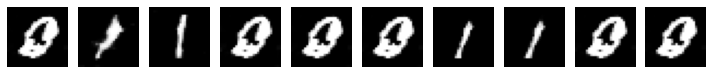

6500 [D loss: 0.031632, acc.: 98.44%] [G loss: 1.890820]
6501 [D loss: 0.027621, acc.: 99.22%] [G loss: 2.914948]
6502 [D loss: 0.123336, acc.: 97.66%] [G loss: 4.068325]
6503 [D loss: 0.071588, acc.: 98.44%] [G loss: 3.999636]
6504 [D loss: 0.042304, acc.: 98.44%] [G loss: 2.898563]
6505 [D loss: 0.019614, acc.: 99.22%] [G loss: 2.110440]
6506 [D loss: 0.023693, acc.: 98.44%] [G loss: 2.116817]
6507 [D loss: 0.013033, acc.: 100.00%] [G loss: 2.729900]
6508 [D loss: 0.010773, acc.: 100.00%] [G loss: 2.882559]
6509 [D loss: 0.005293, acc.: 100.00%] [G loss: 3.133229]
6510 [D loss: 0.046124, acc.: 97.66%] [G loss: 3.059059]
6511 [D loss: 0.021189, acc.: 99.22%] [G loss: 3.118415]
6512 [D loss: 0.062040, acc.: 97.66%] [G loss: 3.227323]
6513 [D loss: 0.050547, acc.: 98.44%] [G loss: 1.991041]
6514 [D loss: 0.087345, acc.: 96.09%] [G loss: 1.874315]
6515 [D loss: 0.052604, acc.: 98.44%] [G loss: 1.769468]
6516 [D loss: 0.046629, acc.: 98.44%] [G loss: 2.824650]
6517 [D loss: 0.043246, acc.

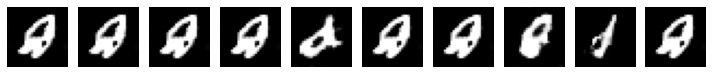

6600 [D loss: 0.024428, acc.: 99.22%] [G loss: 1.778902]
6601 [D loss: 0.005038, acc.: 100.00%] [G loss: 1.614028]
6602 [D loss: 0.051568, acc.: 97.66%] [G loss: 0.652981]
6603 [D loss: 0.065044, acc.: 97.66%] [G loss: 1.140722]
6604 [D loss: 0.025327, acc.: 99.22%] [G loss: 2.365896]
6605 [D loss: 0.009388, acc.: 99.22%] [G loss: 3.115720]
6606 [D loss: 0.007449, acc.: 100.00%] [G loss: 4.568274]
6607 [D loss: 0.041024, acc.: 98.44%] [G loss: 4.225604]
6608 [D loss: 0.032372, acc.: 98.44%] [G loss: 4.014258]
6609 [D loss: 0.027828, acc.: 98.44%] [G loss: 3.457798]
6610 [D loss: 0.091655, acc.: 93.75%] [G loss: 2.516808]
6611 [D loss: 0.019738, acc.: 100.00%] [G loss: 3.288492]
6612 [D loss: 0.051550, acc.: 98.44%] [G loss: 2.559230]
6613 [D loss: 0.046278, acc.: 98.44%] [G loss: 2.492970]
6614 [D loss: 0.054165, acc.: 98.44%] [G loss: 3.401980]
6615 [D loss: 0.014178, acc.: 99.22%] [G loss: 3.699884]
6616 [D loss: 0.012169, acc.: 99.22%] [G loss: 3.867709]
6617 [D loss: 0.068075, acc.

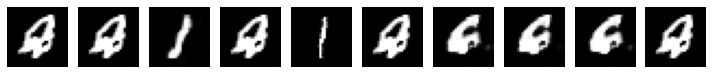

6700 [D loss: 0.029983, acc.: 99.22%] [G loss: 4.306371]
6701 [D loss: 0.043104, acc.: 98.44%] [G loss: 3.787978]
6702 [D loss: 0.018747, acc.: 100.00%] [G loss: 3.917822]
6703 [D loss: 0.054029, acc.: 97.66%] [G loss: 3.398458]
6704 [D loss: 0.054874, acc.: 97.66%] [G loss: 2.535402]
6705 [D loss: 0.022683, acc.: 100.00%] [G loss: 3.247067]
6706 [D loss: 0.026584, acc.: 99.22%] [G loss: 4.064646]
6707 [D loss: 0.014788, acc.: 99.22%] [G loss: 4.538366]
6708 [D loss: 0.101194, acc.: 96.09%] [G loss: 4.314331]
6709 [D loss: 0.038195, acc.: 99.22%] [G loss: 3.380765]
6710 [D loss: 0.044698, acc.: 99.22%] [G loss: 3.089033]
6711 [D loss: 0.072970, acc.: 96.88%] [G loss: 3.797977]
6712 [D loss: 0.038745, acc.: 98.44%] [G loss: 4.458853]
6713 [D loss: 0.022471, acc.: 100.00%] [G loss: 5.494801]
6714 [D loss: 0.038682, acc.: 97.66%] [G loss: 5.743237]
6715 [D loss: 0.007702, acc.: 100.00%] [G loss: 5.701966]
6716 [D loss: 0.019550, acc.: 98.44%] [G loss: 4.675133]
6717 [D loss: 0.083834, acc

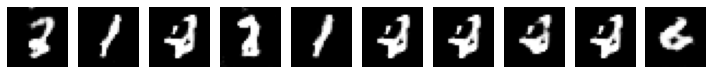

6800 [D loss: 0.021038, acc.: 99.22%] [G loss: 7.184232]
6801 [D loss: 0.064035, acc.: 96.88%] [G loss: 6.340511]
6802 [D loss: 0.018238, acc.: 99.22%] [G loss: 5.998469]
6803 [D loss: 0.021958, acc.: 99.22%] [G loss: 4.799558]
6804 [D loss: 0.079147, acc.: 96.09%] [G loss: 5.810283]
6805 [D loss: 0.003361, acc.: 100.00%] [G loss: 7.621046]
6806 [D loss: 0.084448, acc.: 97.66%] [G loss: 7.385624]
6807 [D loss: 0.006630, acc.: 100.00%] [G loss: 6.644723]
6808 [D loss: 0.009611, acc.: 99.22%] [G loss: 6.117073]
6809 [D loss: 0.010556, acc.: 99.22%] [G loss: 5.008637]
6810 [D loss: 0.024003, acc.: 99.22%] [G loss: 3.991527]
6811 [D loss: 0.034819, acc.: 98.44%] [G loss: 4.066682]
6812 [D loss: 0.012218, acc.: 99.22%] [G loss: 5.424441]
6813 [D loss: 0.047625, acc.: 99.22%] [G loss: 6.112688]
6814 [D loss: 0.032598, acc.: 99.22%] [G loss: 6.404595]
6815 [D loss: 0.010779, acc.: 100.00%] [G loss: 6.486391]
6816 [D loss: 0.093156, acc.: 96.88%] [G loss: 5.566668]
6817 [D loss: 0.049023, acc.

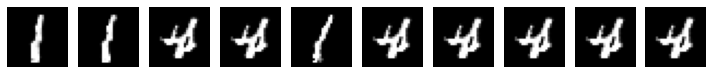

6900 [D loss: 0.067211, acc.: 97.66%] [G loss: 7.915081]
6901 [D loss: 0.074606, acc.: 96.09%] [G loss: 6.940722]
6902 [D loss: 0.033860, acc.: 98.44%] [G loss: 6.706159]
6903 [D loss: 0.062260, acc.: 99.22%] [G loss: 5.995072]
6904 [D loss: 0.009393, acc.: 100.00%] [G loss: 5.974577]
6905 [D loss: 0.062728, acc.: 97.66%] [G loss: 6.670821]
6906 [D loss: 0.046220, acc.: 99.22%] [G loss: 7.166242]
6907 [D loss: 0.112885, acc.: 96.09%] [G loss: 5.621668]
6908 [D loss: 0.091979, acc.: 96.88%] [G loss: 4.436989]
6909 [D loss: 0.040005, acc.: 98.44%] [G loss: 3.188284]
6910 [D loss: 0.042445, acc.: 98.44%] [G loss: 2.700941]
6911 [D loss: 0.015185, acc.: 100.00%] [G loss: 2.581632]
6912 [D loss: 0.039008, acc.: 98.44%] [G loss: 2.262771]
6913 [D loss: 0.047284, acc.: 97.66%] [G loss: 2.514453]
6914 [D loss: 0.037955, acc.: 98.44%] [G loss: 2.402369]
6915 [D loss: 0.039750, acc.: 99.22%] [G loss: 2.405628]
6916 [D loss: 0.042603, acc.: 98.44%] [G loss: 2.144978]
6917 [D loss: 0.056807, acc.:

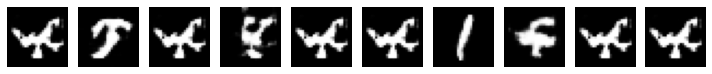

7000 [D loss: 0.053561, acc.: 98.44%] [G loss: 3.532738]
7001 [D loss: 0.060088, acc.: 97.66%] [G loss: 3.295888]
7002 [D loss: 0.051573, acc.: 98.44%] [G loss: 2.019722]
7003 [D loss: 0.068948, acc.: 98.44%] [G loss: 0.802491]
7004 [D loss: 0.098998, acc.: 95.31%] [G loss: 0.533197]
7005 [D loss: 0.054497, acc.: 98.44%] [G loss: 1.111508]
7006 [D loss: 0.027251, acc.: 99.22%] [G loss: 1.502011]
7007 [D loss: 0.003427, acc.: 100.00%] [G loss: 2.557987]
7008 [D loss: 0.020782, acc.: 98.44%] [G loss: 2.921082]
7009 [D loss: 0.007525, acc.: 100.00%] [G loss: 2.561744]
7010 [D loss: 0.019045, acc.: 99.22%] [G loss: 2.704189]
7011 [D loss: 0.004488, acc.: 100.00%] [G loss: 2.047912]
7012 [D loss: 0.022180, acc.: 99.22%] [G loss: 1.782349]
7013 [D loss: 0.034397, acc.: 98.44%] [G loss: 1.026467]
7014 [D loss: 0.047413, acc.: 98.44%] [G loss: 0.803605]
7015 [D loss: 0.034020, acc.: 98.44%] [G loss: 0.781278]
7016 [D loss: 0.055225, acc.: 97.66%] [G loss: 1.207843]
7017 [D loss: 0.037219, acc.

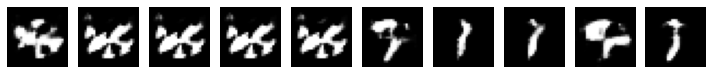

7100 [D loss: 0.022481, acc.: 98.44%] [G loss: 2.449358]
7101 [D loss: 0.048301, acc.: 97.66%] [G loss: 2.508118]
7102 [D loss: 0.061049, acc.: 96.09%] [G loss: 1.833230]
7103 [D loss: 0.041043, acc.: 97.66%] [G loss: 1.787646]
7104 [D loss: 0.041578, acc.: 98.44%] [G loss: 2.452960]
7105 [D loss: 0.013301, acc.: 99.22%] [G loss: 2.385569]
7106 [D loss: 0.014424, acc.: 100.00%] [G loss: 1.975798]
7107 [D loss: 0.011048, acc.: 99.22%] [G loss: 2.195791]
7108 [D loss: 0.057419, acc.: 98.44%] [G loss: 1.876793]
7109 [D loss: 0.023496, acc.: 100.00%] [G loss: 1.249927]
7110 [D loss: 0.011556, acc.: 99.22%] [G loss: 1.086798]
7111 [D loss: 0.022739, acc.: 99.22%] [G loss: 1.275934]
7112 [D loss: 0.027949, acc.: 99.22%] [G loss: 1.282512]
7113 [D loss: 0.050465, acc.: 98.44%] [G loss: 1.547416]
7114 [D loss: 0.026901, acc.: 99.22%] [G loss: 2.021959]
7115 [D loss: 0.051662, acc.: 97.66%] [G loss: 1.902399]
7116 [D loss: 0.040929, acc.: 98.44%] [G loss: 2.505001]
7117 [D loss: 0.005079, acc.:

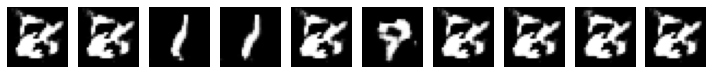

7200 [D loss: 0.020274, acc.: 99.22%] [G loss: 4.067702]
7201 [D loss: 0.019587, acc.: 99.22%] [G loss: 3.589408]
7202 [D loss: 0.003529, acc.: 100.00%] [G loss: 4.498453]
7203 [D loss: 0.003326, acc.: 100.00%] [G loss: 3.944054]
7204 [D loss: 0.007427, acc.: 100.00%] [G loss: 4.196399]
7205 [D loss: 0.029882, acc.: 99.22%] [G loss: 3.595734]
7206 [D loss: 0.004331, acc.: 100.00%] [G loss: 3.064139]
7207 [D loss: 0.044608, acc.: 98.44%] [G loss: 3.199839]
7208 [D loss: 0.018448, acc.: 100.00%] [G loss: 2.808431]
7209 [D loss: 0.008616, acc.: 100.00%] [G loss: 3.109031]
7210 [D loss: 0.009878, acc.: 100.00%] [G loss: 4.242325]
7211 [D loss: 0.007454, acc.: 100.00%] [G loss: 4.275235]
7212 [D loss: 0.004750, acc.: 100.00%] [G loss: 4.997456]
7213 [D loss: 0.072727, acc.: 98.44%] [G loss: 3.069267]
7214 [D loss: 0.042920, acc.: 98.44%] [G loss: 1.721524]
7215 [D loss: 0.050604, acc.: 97.66%] [G loss: 2.904828]
7216 [D loss: 0.011316, acc.: 99.22%] [G loss: 7.362113]
7217 [D loss: 0.001999

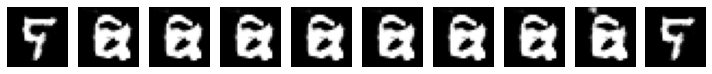

7300 [D loss: 0.001279, acc.: 100.00%] [G loss: 3.843403]
7301 [D loss: 0.028234, acc.: 98.44%] [G loss: 3.482891]
7302 [D loss: 0.181915, acc.: 94.53%] [G loss: 1.418583]
7303 [D loss: 0.065295, acc.: 96.09%] [G loss: 2.760611]
7304 [D loss: 0.033088, acc.: 98.44%] [G loss: 8.240427]
7305 [D loss: 0.007647, acc.: 100.00%] [G loss: 11.818407]
7306 [D loss: 0.151091, acc.: 96.88%] [G loss: 12.805445]
7307 [D loss: 0.113488, acc.: 96.09%] [G loss: 12.176974]
7308 [D loss: 0.036699, acc.: 98.44%] [G loss: 10.901012]
7309 [D loss: 0.028367, acc.: 99.22%] [G loss: 9.332426]
7310 [D loss: 0.047749, acc.: 98.44%] [G loss: 10.073296]
7311 [D loss: 0.079080, acc.: 96.88%] [G loss: 9.548727]
7312 [D loss: 0.143499, acc.: 94.53%] [G loss: 8.333091]
7313 [D loss: 0.046642, acc.: 98.44%] [G loss: 6.829083]
7314 [D loss: 0.030093, acc.: 99.22%] [G loss: 5.891972]
7315 [D loss: 0.037251, acc.: 97.66%] [G loss: 4.618123]
7316 [D loss: 0.007721, acc.: 100.00%] [G loss: 3.371036]
7317 [D loss: 0.020994,

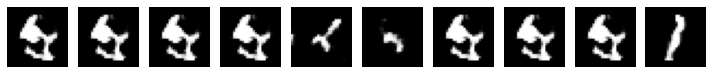

7400 [D loss: 0.035556, acc.: 98.44%] [G loss: 1.150799]
7401 [D loss: 0.006681, acc.: 100.00%] [G loss: 1.674805]
7402 [D loss: 0.018470, acc.: 100.00%] [G loss: 1.933528]
7403 [D loss: 0.004149, acc.: 100.00%] [G loss: 2.623276]
7404 [D loss: 0.026106, acc.: 98.44%] [G loss: 2.767069]
7405 [D loss: 0.027168, acc.: 99.22%] [G loss: 3.236928]
7406 [D loss: 0.128048, acc.: 98.44%] [G loss: 2.981777]
7407 [D loss: 0.035548, acc.: 98.44%] [G loss: 2.290692]
7408 [D loss: 0.011204, acc.: 100.00%] [G loss: 2.133545]
7409 [D loss: 0.033018, acc.: 99.22%] [G loss: 1.992214]
7410 [D loss: 0.036540, acc.: 99.22%] [G loss: 1.759890]
7411 [D loss: 0.003080, acc.: 100.00%] [G loss: 1.960053]
7412 [D loss: 0.035304, acc.: 99.22%] [G loss: 2.049854]
7413 [D loss: 0.038311, acc.: 98.44%] [G loss: 1.238398]
7414 [D loss: 0.033761, acc.: 99.22%] [G loss: 1.823409]
7415 [D loss: 0.019787, acc.: 99.22%] [G loss: 2.041651]
7416 [D loss: 0.014227, acc.: 99.22%] [G loss: 2.372644]
7417 [D loss: 0.004693, ac

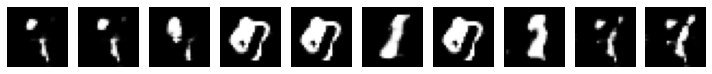

7500 [D loss: 0.028706, acc.: 98.44%] [G loss: 3.754431]
7501 [D loss: 0.036976, acc.: 98.44%] [G loss: 3.692477]
7502 [D loss: 0.058874, acc.: 96.09%] [G loss: 1.778185]
7503 [D loss: 0.149090, acc.: 94.53%] [G loss: 3.187563]
7504 [D loss: 0.049966, acc.: 96.88%] [G loss: 7.599635]
7505 [D loss: 0.025644, acc.: 98.44%] [G loss: 10.468270]
7506 [D loss: 0.039870, acc.: 98.44%] [G loss: 12.092663]
7507 [D loss: 0.043100, acc.: 99.22%] [G loss: 13.643730]
7508 [D loss: 0.025480, acc.: 99.22%] [G loss: 13.755980]
7509 [D loss: 0.091217, acc.: 96.88%] [G loss: 12.911575]
7510 [D loss: 0.022399, acc.: 100.00%] [G loss: 12.768717]
7511 [D loss: 0.019320, acc.: 99.22%] [G loss: 12.614862]
7512 [D loss: 0.039268, acc.: 99.22%] [G loss: 13.184107]
7513 [D loss: 0.058056, acc.: 98.44%] [G loss: 13.105019]
7514 [D loss: 0.108570, acc.: 96.88%] [G loss: 13.274725]
7515 [D loss: 0.087220, acc.: 96.09%] [G loss: 11.550845]
7516 [D loss: 0.034612, acc.: 98.44%] [G loss: 10.975118]
7517 [D loss: 0.00

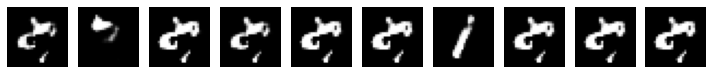

7600 [D loss: 0.027018, acc.: 98.44%] [G loss: 4.521110]
7601 [D loss: 0.031099, acc.: 98.44%] [G loss: 4.001258]
7602 [D loss: 0.076773, acc.: 98.44%] [G loss: 4.812755]
7603 [D loss: 0.038038, acc.: 99.22%] [G loss: 6.883997]
7604 [D loss: 0.091429, acc.: 96.88%] [G loss: 6.335223]
7605 [D loss: 0.016472, acc.: 99.22%] [G loss: 5.429803]
7606 [D loss: 0.015144, acc.: 99.22%] [G loss: 4.899764]
7607 [D loss: 0.012704, acc.: 100.00%] [G loss: 5.084352]
7608 [D loss: 0.017277, acc.: 99.22%] [G loss: 6.242677]
7609 [D loss: 0.005734, acc.: 100.00%] [G loss: 7.763200]
7610 [D loss: 0.066547, acc.: 97.66%] [G loss: 4.238266]
7611 [D loss: 0.021600, acc.: 100.00%] [G loss: 3.693686]
7612 [D loss: 0.012794, acc.: 99.22%] [G loss: 4.253830]
7613 [D loss: 0.011403, acc.: 99.22%] [G loss: 4.150796]
7614 [D loss: 0.009753, acc.: 100.00%] [G loss: 4.580397]
7615 [D loss: 0.043083, acc.: 98.44%] [G loss: 4.634832]
7616 [D loss: 0.028264, acc.: 98.44%] [G loss: 6.306672]
7617 [D loss: 0.029656, acc

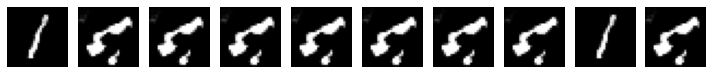

7700 [D loss: 0.039428, acc.: 98.44%] [G loss: 2.273556]
7701 [D loss: 0.042303, acc.: 98.44%] [G loss: 2.841192]
7702 [D loss: 0.045325, acc.: 98.44%] [G loss: 4.150015]
7703 [D loss: 0.013416, acc.: 100.00%] [G loss: 5.946332]
7704 [D loss: 0.092064, acc.: 97.66%] [G loss: 6.718964]
7705 [D loss: 0.030198, acc.: 98.44%] [G loss: 6.909580]
7706 [D loss: 0.020193, acc.: 99.22%] [G loss: 6.737230]
7707 [D loss: 0.009591, acc.: 100.00%] [G loss: 6.028267]
7708 [D loss: 0.184812, acc.: 94.53%] [G loss: 5.090992]
7709 [D loss: 0.067393, acc.: 97.66%] [G loss: 5.180665]
7710 [D loss: 0.021047, acc.: 99.22%] [G loss: 6.465613]
7711 [D loss: 0.005138, acc.: 100.00%] [G loss: 7.343671]
7712 [D loss: 0.001772, acc.: 100.00%] [G loss: 7.742029]
7713 [D loss: 0.109935, acc.: 96.09%] [G loss: 6.596025]
7714 [D loss: 0.025704, acc.: 99.22%] [G loss: 5.861549]
7715 [D loss: 0.056126, acc.: 98.44%] [G loss: 4.539987]
7716 [D loss: 0.004073, acc.: 100.00%] [G loss: 3.641690]
7717 [D loss: 0.071981, ac

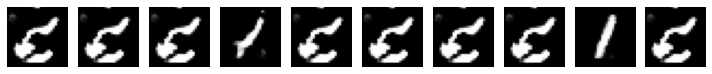

7800 [D loss: 0.013409, acc.: 100.00%] [G loss: 3.172744]
7801 [D loss: 0.018575, acc.: 99.22%] [G loss: 2.260560]
7802 [D loss: 0.127780, acc.: 97.66%] [G loss: 1.457455]
7803 [D loss: 0.048959, acc.: 97.66%] [G loss: 1.497321]
7804 [D loss: 0.016714, acc.: 100.00%] [G loss: 1.767714]
7805 [D loss: 0.030493, acc.: 99.22%] [G loss: 2.684589]
7806 [D loss: 0.039816, acc.: 98.44%] [G loss: 2.382611]
7807 [D loss: 0.026901, acc.: 99.22%] [G loss: 2.574930]
7808 [D loss: 0.051723, acc.: 98.44%] [G loss: 3.026192]
7809 [D loss: 0.006123, acc.: 100.00%] [G loss: 3.847565]
7810 [D loss: 0.012376, acc.: 100.00%] [G loss: 4.648914]
7811 [D loss: 0.033509, acc.: 97.66%] [G loss: 4.736750]
7812 [D loss: 0.019395, acc.: 99.22%] [G loss: 3.980840]
7813 [D loss: 0.027012, acc.: 99.22%] [G loss: 3.561226]
7814 [D loss: 0.044551, acc.: 98.44%] [G loss: 2.233997]
7815 [D loss: 0.012294, acc.: 99.22%] [G loss: 2.211195]
7816 [D loss: 0.057841, acc.: 98.44%] [G loss: 1.821192]
7817 [D loss: 0.037123, acc

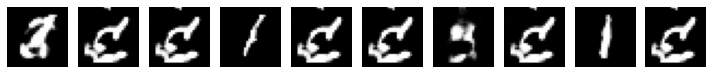

7900 [D loss: 0.094683, acc.: 97.66%] [G loss: 1.173124]
7901 [D loss: 0.033187, acc.: 99.22%] [G loss: 1.216571]
7902 [D loss: 0.079729, acc.: 96.09%] [G loss: 1.561553]
7903 [D loss: 0.015694, acc.: 99.22%] [G loss: 1.868120]
7904 [D loss: 0.067674, acc.: 97.66%] [G loss: 2.896381]
7905 [D loss: 0.009193, acc.: 99.22%] [G loss: 3.048487]
7906 [D loss: 0.042745, acc.: 99.22%] [G loss: 2.806468]
7907 [D loss: 0.055311, acc.: 97.66%] [G loss: 2.166055]
7908 [D loss: 0.013162, acc.: 99.22%] [G loss: 1.328476]
7909 [D loss: 0.033300, acc.: 98.44%] [G loss: 1.150080]
7910 [D loss: 0.055187, acc.: 97.66%] [G loss: 1.527583]
7911 [D loss: 0.019707, acc.: 98.44%] [G loss: 3.400303]
7912 [D loss: 0.039495, acc.: 99.22%] [G loss: 4.488832]
7913 [D loss: 0.090914, acc.: 96.09%] [G loss: 3.333710]
7914 [D loss: 0.050596, acc.: 97.66%] [G loss: 2.204663]
7915 [D loss: 0.023203, acc.: 99.22%] [G loss: 1.138515]
7916 [D loss: 0.059680, acc.: 96.88%] [G loss: 0.648708]
7917 [D loss: 0.127817, acc.: 9

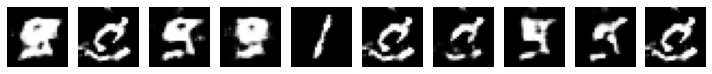

8000 [D loss: 0.039509, acc.: 97.66%] [G loss: 1.678717]
8001 [D loss: 0.043010, acc.: 97.66%] [G loss: 2.377772]
8002 [D loss: 0.040753, acc.: 99.22%] [G loss: 2.266423]
8003 [D loss: 0.065850, acc.: 97.66%] [G loss: 1.371961]
8004 [D loss: 0.042187, acc.: 98.44%] [G loss: 0.946866]
8005 [D loss: 0.056770, acc.: 98.44%] [G loss: 0.719763]
8006 [D loss: 0.039129, acc.: 98.44%] [G loss: 1.109863]
8007 [D loss: 0.027744, acc.: 99.22%] [G loss: 2.507512]
8008 [D loss: 0.036706, acc.: 98.44%] [G loss: 3.230875]
8009 [D loss: 0.011842, acc.: 100.00%] [G loss: 3.080482]
8010 [D loss: 0.064097, acc.: 97.66%] [G loss: 2.922977]
8011 [D loss: 0.031952, acc.: 98.44%] [G loss: 2.199828]
8012 [D loss: 0.037286, acc.: 97.66%] [G loss: 2.301039]
8013 [D loss: 0.044083, acc.: 98.44%] [G loss: 1.882732]
8014 [D loss: 0.029736, acc.: 99.22%] [G loss: 2.050727]
8015 [D loss: 0.028816, acc.: 98.44%] [G loss: 2.604637]
8016 [D loss: 0.055904, acc.: 97.66%] [G loss: 2.183446]
8017 [D loss: 0.058171, acc.: 

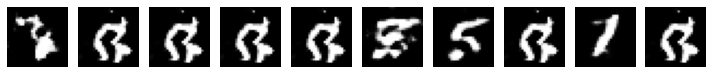

8100 [D loss: 0.016396, acc.: 99.22%] [G loss: 3.191253]
8101 [D loss: 0.014847, acc.: 99.22%] [G loss: 3.163384]
8102 [D loss: 0.014232, acc.: 100.00%] [G loss: 2.283513]
8103 [D loss: 0.090089, acc.: 95.31%] [G loss: 1.491403]
8104 [D loss: 0.020668, acc.: 100.00%] [G loss: 1.461915]
8105 [D loss: 0.027092, acc.: 98.44%] [G loss: 2.406110]
8106 [D loss: 0.028144, acc.: 98.44%] [G loss: 4.216597]
8107 [D loss: 0.012486, acc.: 99.22%] [G loss: 4.582148]
8108 [D loss: 0.031124, acc.: 98.44%] [G loss: 4.672306]
8109 [D loss: 0.085763, acc.: 99.22%] [G loss: 4.034944]
8110 [D loss: 0.067511, acc.: 96.88%] [G loss: 3.579034]
8111 [D loss: 0.061228, acc.: 98.44%] [G loss: 3.725652]
8112 [D loss: 0.033519, acc.: 99.22%] [G loss: 3.737634]
8113 [D loss: 0.007835, acc.: 100.00%] [G loss: 3.502963]
8114 [D loss: 0.020330, acc.: 99.22%] [G loss: 3.281262]
8115 [D loss: 0.009063, acc.: 100.00%] [G loss: 3.312712]
8116 [D loss: 0.005152, acc.: 100.00%] [G loss: 3.595447]
8117 [D loss: 0.016273, ac

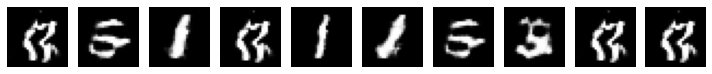

8200 [D loss: 0.025588, acc.: 98.44%] [G loss: 2.592906]
8201 [D loss: 0.004418, acc.: 100.00%] [G loss: 2.289468]
8202 [D loss: 0.016723, acc.: 99.22%] [G loss: 2.814903]
8203 [D loss: 0.014976, acc.: 99.22%] [G loss: 2.875653]
8204 [D loss: 0.056434, acc.: 97.66%] [G loss: 2.573709]
8205 [D loss: 0.002520, acc.: 100.00%] [G loss: 3.402316]
8206 [D loss: 0.014189, acc.: 99.22%] [G loss: 3.005770]
8207 [D loss: 0.032138, acc.: 99.22%] [G loss: 3.410481]
8208 [D loss: 0.021101, acc.: 99.22%] [G loss: 2.451830]
8209 [D loss: 0.017174, acc.: 99.22%] [G loss: 1.956941]
8210 [D loss: 0.053306, acc.: 98.44%] [G loss: 2.299102]
8211 [D loss: 0.037021, acc.: 98.44%] [G loss: 4.171478]
8212 [D loss: 0.005414, acc.: 100.00%] [G loss: 5.286475]
8213 [D loss: 0.001510, acc.: 100.00%] [G loss: 7.011170]
8214 [D loss: 0.069032, acc.: 98.44%] [G loss: 6.610198]
8215 [D loss: 0.027294, acc.: 98.44%] [G loss: 5.686538]
8216 [D loss: 0.028356, acc.: 99.22%] [G loss: 4.796155]
8217 [D loss: 0.027633, acc

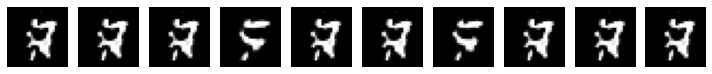

8300 [D loss: 0.012251, acc.: 100.00%] [G loss: 5.133462]
8301 [D loss: 0.041390, acc.: 98.44%] [G loss: 5.050448]
8302 [D loss: 0.004735, acc.: 100.00%] [G loss: 5.212618]
8303 [D loss: 0.074221, acc.: 97.66%] [G loss: 5.295235]
8304 [D loss: 0.031705, acc.: 99.22%] [G loss: 4.828133]
8305 [D loss: 0.017336, acc.: 99.22%] [G loss: 5.462366]
8306 [D loss: 0.009699, acc.: 100.00%] [G loss: 4.613464]
8307 [D loss: 0.024518, acc.: 99.22%] [G loss: 4.511833]
8308 [D loss: 0.036792, acc.: 98.44%] [G loss: 2.324091]
8309 [D loss: 0.038249, acc.: 98.44%] [G loss: 1.702941]
8310 [D loss: 0.045842, acc.: 97.66%] [G loss: 2.217598]
8311 [D loss: 0.006849, acc.: 100.00%] [G loss: 2.546186]
8312 [D loss: 0.048487, acc.: 98.44%] [G loss: 3.507659]
8313 [D loss: 0.077591, acc.: 98.44%] [G loss: 3.732367]
8314 [D loss: 0.050711, acc.: 98.44%] [G loss: 3.135609]
8315 [D loss: 0.033945, acc.: 99.22%] [G loss: 2.358954]
8316 [D loss: 0.026028, acc.: 99.22%] [G loss: 3.691392]
8317 [D loss: 0.053969, acc

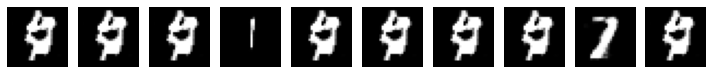

8400 [D loss: 0.047682, acc.: 97.66%] [G loss: 4.223518]
8401 [D loss: 0.032521, acc.: 98.44%] [G loss: 5.158632]
8402 [D loss: 0.039858, acc.: 98.44%] [G loss: 6.312461]
8403 [D loss: 0.013637, acc.: 99.22%] [G loss: 5.540715]
8404 [D loss: 0.035722, acc.: 98.44%] [G loss: 5.634062]
8405 [D loss: 0.065827, acc.: 97.66%] [G loss: 3.780410]
8406 [D loss: 0.004232, acc.: 100.00%] [G loss: 2.479390]
8407 [D loss: 0.050132, acc.: 96.88%] [G loss: 3.064219]
8408 [D loss: 0.018626, acc.: 100.00%] [G loss: 4.123821]
8409 [D loss: 0.006924, acc.: 100.00%] [G loss: 5.838108]
8410 [D loss: 0.032650, acc.: 98.44%] [G loss: 6.765056]
8411 [D loss: 0.018634, acc.: 99.22%] [G loss: 5.947101]
8412 [D loss: 0.012432, acc.: 100.00%] [G loss: 6.561499]
8413 [D loss: 0.003397, acc.: 100.00%] [G loss: 6.589059]
8414 [D loss: 0.017260, acc.: 99.22%] [G loss: 6.288607]
8415 [D loss: 0.007701, acc.: 100.00%] [G loss: 7.020589]
8416 [D loss: 0.037482, acc.: 99.22%] [G loss: 6.552856]
8417 [D loss: 0.009979, a

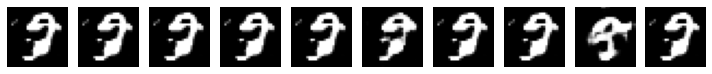

8500 [D loss: 0.006601, acc.: 100.00%] [G loss: 3.631850]
8501 [D loss: 0.007327, acc.: 99.22%] [G loss: 3.905032]
8502 [D loss: 0.029780, acc.: 99.22%] [G loss: 3.209412]
8503 [D loss: 0.010004, acc.: 100.00%] [G loss: 2.693188]
8504 [D loss: 0.028768, acc.: 99.22%] [G loss: 2.335690]
8505 [D loss: 0.069224, acc.: 97.66%] [G loss: 2.911615]
8506 [D loss: 0.008636, acc.: 100.00%] [G loss: 3.692454]
8507 [D loss: 0.016834, acc.: 99.22%] [G loss: 3.826737]
8508 [D loss: 0.037809, acc.: 98.44%] [G loss: 3.685667]
8509 [D loss: 0.033569, acc.: 99.22%] [G loss: 3.098598]
8510 [D loss: 0.001686, acc.: 100.00%] [G loss: 2.902034]
8511 [D loss: 0.014149, acc.: 99.22%] [G loss: 2.676275]
8512 [D loss: 0.032434, acc.: 97.66%] [G loss: 2.410614]
8513 [D loss: 0.003255, acc.: 100.00%] [G loss: 4.232450]
8514 [D loss: 0.065836, acc.: 98.44%] [G loss: 4.122803]
8515 [D loss: 0.013649, acc.: 99.22%] [G loss: 3.611900]
8516 [D loss: 0.066925, acc.: 98.44%] [G loss: 3.518402]
8517 [D loss: 0.004479, ac

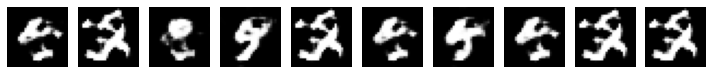

8600 [D loss: 0.002779, acc.: 100.00%] [G loss: 2.970294]
8601 [D loss: 0.004293, acc.: 100.00%] [G loss: 3.836176]
8602 [D loss: 0.062590, acc.: 98.44%] [G loss: 1.779311]
8603 [D loss: 0.006598, acc.: 100.00%] [G loss: 1.311043]
8604 [D loss: 0.006519, acc.: 100.00%] [G loss: 0.963806]
8605 [D loss: 0.052452, acc.: 97.66%] [G loss: 1.156312]
8606 [D loss: 0.001138, acc.: 100.00%] [G loss: 1.875273]
8607 [D loss: 0.008369, acc.: 100.00%] [G loss: 1.434375]
8608 [D loss: 0.012195, acc.: 100.00%] [G loss: 1.380278]
8609 [D loss: 0.007673, acc.: 100.00%] [G loss: 0.969898]
8610 [D loss: 0.003691, acc.: 100.00%] [G loss: 0.829058]
8611 [D loss: 0.009680, acc.: 99.22%] [G loss: 0.749100]
8612 [D loss: 0.002125, acc.: 100.00%] [G loss: 0.610917]
8613 [D loss: 0.007760, acc.: 100.00%] [G loss: 0.694947]
8614 [D loss: 0.004928, acc.: 100.00%] [G loss: 0.791216]
8615 [D loss: 0.018952, acc.: 99.22%] [G loss: 0.890631]
8616 [D loss: 0.021292, acc.: 98.44%] [G loss: 1.117934]
8617 [D loss: 0.040

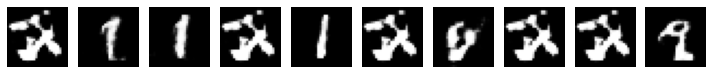

8700 [D loss: 0.061370, acc.: 98.44%] [G loss: 1.355369]
8701 [D loss: 0.015943, acc.: 99.22%] [G loss: 1.551967]
8702 [D loss: 0.022553, acc.: 98.44%] [G loss: 1.090774]
8703 [D loss: 0.046018, acc.: 99.22%] [G loss: 0.625778]
8704 [D loss: 0.003028, acc.: 100.00%] [G loss: 0.604019]
8705 [D loss: 0.020674, acc.: 99.22%] [G loss: 0.379559]
8706 [D loss: 0.018358, acc.: 100.00%] [G loss: 0.248098]
8707 [D loss: 0.010968, acc.: 100.00%] [G loss: 0.410384]
8708 [D loss: 0.007244, acc.: 100.00%] [G loss: 0.379610]
8709 [D loss: 0.001890, acc.: 100.00%] [G loss: 0.480831]
8710 [D loss: 0.002446, acc.: 100.00%] [G loss: 0.264855]
8711 [D loss: 0.012757, acc.: 99.22%] [G loss: 0.552438]
8712 [D loss: 0.022742, acc.: 98.44%] [G loss: 0.557124]
8713 [D loss: 0.014182, acc.: 99.22%] [G loss: 0.890249]
8714 [D loss: 0.017045, acc.: 99.22%] [G loss: 0.500323]
8715 [D loss: 0.037181, acc.: 97.66%] [G loss: 0.718761]
8716 [D loss: 0.024211, acc.: 99.22%] [G loss: 0.643054]
8717 [D loss: 0.038678, a

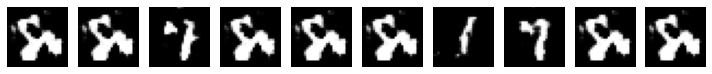

8800 [D loss: 0.010461, acc.: 100.00%] [G loss: 3.377535]
8801 [D loss: 0.053571, acc.: 98.44%] [G loss: 2.380728]
8802 [D loss: 0.006906, acc.: 100.00%] [G loss: 2.058948]
8803 [D loss: 0.049739, acc.: 98.44%] [G loss: 0.668324]
8804 [D loss: 0.005366, acc.: 100.00%] [G loss: 0.405389]
8805 [D loss: 0.035335, acc.: 98.44%] [G loss: 0.573164]
8806 [D loss: 0.028961, acc.: 99.22%] [G loss: 1.077625]
8807 [D loss: 0.009120, acc.: 99.22%] [G loss: 1.296057]
8808 [D loss: 0.036705, acc.: 97.66%] [G loss: 1.321913]
8809 [D loss: 0.001150, acc.: 100.00%] [G loss: 1.448707]
8810 [D loss: 0.003273, acc.: 100.00%] [G loss: 1.548610]
8811 [D loss: 0.002956, acc.: 100.00%] [G loss: 1.594403]
8812 [D loss: 0.029072, acc.: 99.22%] [G loss: 1.025700]
8813 [D loss: 0.034574, acc.: 98.44%] [G loss: 0.618317]
8814 [D loss: 0.003911, acc.: 100.00%] [G loss: 1.071851]
8815 [D loss: 0.005687, acc.: 100.00%] [G loss: 1.418738]
8816 [D loss: 0.001564, acc.: 100.00%] [G loss: 2.056126]
8817 [D loss: 0.002847

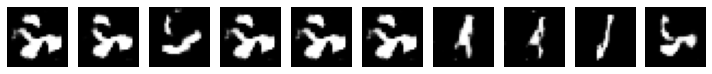

8900 [D loss: 0.007036, acc.: 100.00%] [G loss: 1.917563]
8901 [D loss: 0.000544, acc.: 100.00%] [G loss: 3.103262]
8902 [D loss: 0.000484, acc.: 100.00%] [G loss: 3.483435]
8903 [D loss: 0.000831, acc.: 100.00%] [G loss: 3.973909]
8904 [D loss: 0.036195, acc.: 98.44%] [G loss: 3.666906]
8905 [D loss: 0.032826, acc.: 99.22%] [G loss: 2.288285]
8906 [D loss: 0.002775, acc.: 100.00%] [G loss: 1.504459]
8907 [D loss: 0.029691, acc.: 99.22%] [G loss: 1.582621]
8908 [D loss: 0.012613, acc.: 99.22%] [G loss: 2.585631]
8909 [D loss: 0.002387, acc.: 100.00%] [G loss: 2.843289]
8910 [D loss: 0.020310, acc.: 98.44%] [G loss: 2.833208]
8911 [D loss: 0.000466, acc.: 100.00%] [G loss: 3.378686]
8912 [D loss: 0.023810, acc.: 98.44%] [G loss: 2.593405]
8913 [D loss: 0.006490, acc.: 100.00%] [G loss: 2.737652]
8914 [D loss: 0.033549, acc.: 99.22%] [G loss: 3.102716]
8915 [D loss: 0.003904, acc.: 100.00%] [G loss: 2.975410]
8916 [D loss: 0.004406, acc.: 100.00%] [G loss: 2.786300]
8917 [D loss: 0.00097

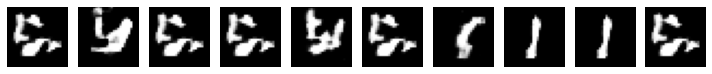

9000 [D loss: 0.000623, acc.: 100.00%] [G loss: 4.786819]
9001 [D loss: 0.003790, acc.: 100.00%] [G loss: 4.957643]
9002 [D loss: 0.090301, acc.: 98.44%] [G loss: 4.016692]
9003 [D loss: 0.005825, acc.: 100.00%] [G loss: 2.375858]
9004 [D loss: 0.011594, acc.: 99.22%] [G loss: 1.448812]
9005 [D loss: 0.062698, acc.: 98.44%] [G loss: 1.249483]
9006 [D loss: 0.055659, acc.: 97.66%] [G loss: 0.994927]
9007 [D loss: 0.018035, acc.: 100.00%] [G loss: 0.771049]
9008 [D loss: 0.025279, acc.: 98.44%] [G loss: 1.215656]
9009 [D loss: 0.017286, acc.: 99.22%] [G loss: 1.418122]
9010 [D loss: 0.004211, acc.: 100.00%] [G loss: 1.417067]
9011 [D loss: 0.004598, acc.: 100.00%] [G loss: 1.868897]
9012 [D loss: 0.065323, acc.: 98.44%] [G loss: 0.841883]
9013 [D loss: 0.095344, acc.: 96.88%] [G loss: 0.370992]
9014 [D loss: 0.061332, acc.: 96.09%] [G loss: 0.420174]
9015 [D loss: 0.003776, acc.: 100.00%] [G loss: 1.214797]
9016 [D loss: 0.000957, acc.: 100.00%] [G loss: 2.302437]
9017 [D loss: 0.012202,

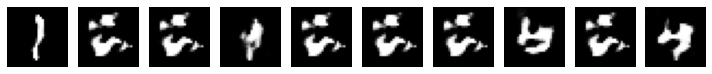

9100 [D loss: 0.021084, acc.: 99.22%] [G loss: 1.062247]
9101 [D loss: 0.048782, acc.: 98.44%] [G loss: 0.496738]
9102 [D loss: 0.045194, acc.: 97.66%] [G loss: 1.150822]
9103 [D loss: 0.001586, acc.: 100.00%] [G loss: 3.938366]
9104 [D loss: 0.007053, acc.: 100.00%] [G loss: 6.751657]
9105 [D loss: 0.015004, acc.: 99.22%] [G loss: 6.958240]
9106 [D loss: 0.012504, acc.: 99.22%] [G loss: 7.054761]
9107 [D loss: 0.028217, acc.: 98.44%] [G loss: 5.627413]
9108 [D loss: 0.009959, acc.: 99.22%] [G loss: 3.987284]
9109 [D loss: 0.004539, acc.: 100.00%] [G loss: 3.185558]
9110 [D loss: 0.011664, acc.: 99.22%] [G loss: 1.924177]
9111 [D loss: 0.017325, acc.: 99.22%] [G loss: 1.836349]
9112 [D loss: 0.025442, acc.: 99.22%] [G loss: 3.105657]
9113 [D loss: 0.001537, acc.: 100.00%] [G loss: 4.806111]
9114 [D loss: 0.043854, acc.: 98.44%] [G loss: 4.449319]
9115 [D loss: 0.013009, acc.: 99.22%] [G loss: 2.794984]
9116 [D loss: 0.003283, acc.: 100.00%] [G loss: 1.776248]
9117 [D loss: 0.005212, ac

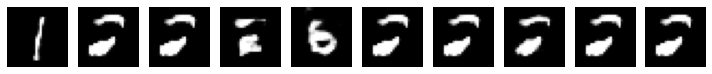

9200 [D loss: 0.105214, acc.: 96.88%] [G loss: 3.977929]
9201 [D loss: 0.060738, acc.: 97.66%] [G loss: 1.600968]
9202 [D loss: 0.130923, acc.: 96.88%] [G loss: 2.685379]
9203 [D loss: 0.005217, acc.: 100.00%] [G loss: 7.346484]
9204 [D loss: 0.013103, acc.: 99.22%] [G loss: 9.999573]
9205 [D loss: 0.018536, acc.: 98.44%] [G loss: 12.214453]
9206 [D loss: 0.108479, acc.: 96.09%] [G loss: 11.448068]
9207 [D loss: 0.246198, acc.: 92.97%] [G loss: 9.498642]
9208 [D loss: 0.005712, acc.: 100.00%] [G loss: 9.326962]
9209 [D loss: 0.094493, acc.: 98.44%] [G loss: 8.163829]
9210 [D loss: 0.005924, acc.: 100.00%] [G loss: 6.832121]
9211 [D loss: 0.057097, acc.: 99.22%] [G loss: 5.591079]
9212 [D loss: 0.009754, acc.: 100.00%] [G loss: 4.311560]
9213 [D loss: 0.002269, acc.: 100.00%] [G loss: 3.188211]
9214 [D loss: 0.005832, acc.: 100.00%] [G loss: 2.270099]
9215 [D loss: 0.028434, acc.: 99.22%] [G loss: 1.567170]
9216 [D loss: 0.048354, acc.: 98.44%] [G loss: 1.271024]
9217 [D loss: 0.011869,

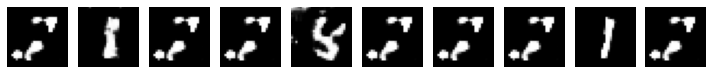

9300 [D loss: 0.007797, acc.: 99.22%] [G loss: 1.747509]
9301 [D loss: 0.035977, acc.: 98.44%] [G loss: 1.255438]
9302 [D loss: 0.007683, acc.: 99.22%] [G loss: 1.534237]
9303 [D loss: 0.023698, acc.: 99.22%] [G loss: 2.287389]
9304 [D loss: 0.005467, acc.: 100.00%] [G loss: 3.150445]
9305 [D loss: 0.024081, acc.: 99.22%] [G loss: 4.271052]
9306 [D loss: 0.002826, acc.: 100.00%] [G loss: 5.000847]
9307 [D loss: 0.008520, acc.: 100.00%] [G loss: 4.512205]
9308 [D loss: 0.008659, acc.: 100.00%] [G loss: 3.998035]
9309 [D loss: 0.002102, acc.: 100.00%] [G loss: 3.805832]
9310 [D loss: 0.044930, acc.: 97.66%] [G loss: 4.240269]
9311 [D loss: 0.004951, acc.: 100.00%] [G loss: 5.386534]
9312 [D loss: 0.090901, acc.: 99.22%] [G loss: 4.483876]
9313 [D loss: 0.033538, acc.: 99.22%] [G loss: 2.456036]
9314 [D loss: 0.001138, acc.: 100.00%] [G loss: 2.085042]
9315 [D loss: 0.002205, acc.: 100.00%] [G loss: 1.256779]
9316 [D loss: 0.061245, acc.: 97.66%] [G loss: 0.786723]
9317 [D loss: 0.017135,

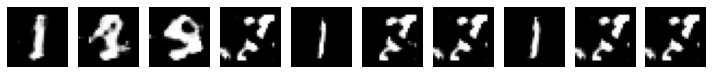

9400 [D loss: 0.021700, acc.: 98.44%] [G loss: 0.750673]
9401 [D loss: 0.008320, acc.: 99.22%] [G loss: 0.977434]
9402 [D loss: 0.000694, acc.: 100.00%] [G loss: 1.417724]
9403 [D loss: 0.034803, acc.: 99.22%] [G loss: 0.895418]
9404 [D loss: 0.040880, acc.: 98.44%] [G loss: 1.103794]
9405 [D loss: 0.027610, acc.: 98.44%] [G loss: 0.499077]
9406 [D loss: 0.010957, acc.: 99.22%] [G loss: 0.560680]
9407 [D loss: 0.005408, acc.: 100.00%] [G loss: 1.024564]
9408 [D loss: 0.043712, acc.: 97.66%] [G loss: 1.015495]
9409 [D loss: 0.002404, acc.: 100.00%] [G loss: 1.796985]
9410 [D loss: 0.004681, acc.: 100.00%] [G loss: 2.327801]
9411 [D loss: 0.008137, acc.: 100.00%] [G loss: 2.715413]
9412 [D loss: 0.018161, acc.: 99.22%] [G loss: 2.031456]
9413 [D loss: 0.004258, acc.: 100.00%] [G loss: 1.382948]
9414 [D loss: 0.026146, acc.: 98.44%] [G loss: 0.898660]
9415 [D loss: 0.006899, acc.: 100.00%] [G loss: 0.710364]
9416 [D loss: 0.004951, acc.: 100.00%] [G loss: 1.010567]
9417 [D loss: 0.010683,

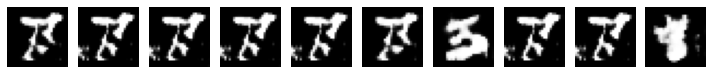

9500 [D loss: 0.014195, acc.: 99.22%] [G loss: 2.109561]
9501 [D loss: 0.005615, acc.: 100.00%] [G loss: 3.337078]
9502 [D loss: 0.001547, acc.: 100.00%] [G loss: 3.693918]
9503 [D loss: 0.025524, acc.: 99.22%] [G loss: 3.681602]
9504 [D loss: 0.005616, acc.: 100.00%] [G loss: 3.544600]
9505 [D loss: 0.001494, acc.: 100.00%] [G loss: 3.887241]
9506 [D loss: 0.031948, acc.: 99.22%] [G loss: 2.703363]
9507 [D loss: 0.084880, acc.: 97.66%] [G loss: 2.353854]
9508 [D loss: 0.025357, acc.: 99.22%] [G loss: 1.928056]
9509 [D loss: 0.007732, acc.: 100.00%] [G loss: 1.949923]
9510 [D loss: 0.007539, acc.: 100.00%] [G loss: 2.701141]
9511 [D loss: 0.008959, acc.: 100.00%] [G loss: 2.682014]
9512 [D loss: 0.101693, acc.: 97.66%] [G loss: 2.276761]
9513 [D loss: 0.001478, acc.: 100.00%] [G loss: 1.548787]
9514 [D loss: 0.019887, acc.: 99.22%] [G loss: 1.074965]
9515 [D loss: 0.027831, acc.: 98.44%] [G loss: 0.775200]
9516 [D loss: 0.035744, acc.: 98.44%] [G loss: 0.562531]
9517 [D loss: 0.015528,

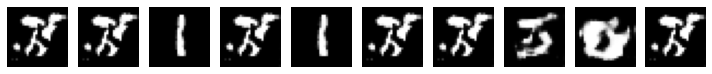

9600 [D loss: 0.000577, acc.: 100.00%] [G loss: 3.225095]
9601 [D loss: 0.001588, acc.: 100.00%] [G loss: 4.079200]
9602 [D loss: 0.000096, acc.: 100.00%] [G loss: 4.834647]
9603 [D loss: 0.047815, acc.: 99.22%] [G loss: 4.957297]
9604 [D loss: 0.072818, acc.: 98.44%] [G loss: 2.358401]
9605 [D loss: 0.002983, acc.: 100.00%] [G loss: 0.952844]
9606 [D loss: 0.018037, acc.: 99.22%] [G loss: 1.331309]
9607 [D loss: 0.003567, acc.: 100.00%] [G loss: 1.997605]
9608 [D loss: 0.015940, acc.: 99.22%] [G loss: 3.704754]
9609 [D loss: 0.001190, acc.: 100.00%] [G loss: 5.581106]
9610 [D loss: 0.002153, acc.: 100.00%] [G loss: 7.002398]
9611 [D loss: 0.026618, acc.: 99.22%] [G loss: 6.523991]
9612 [D loss: 0.015903, acc.: 99.22%] [G loss: 4.154607]
9613 [D loss: 0.103711, acc.: 96.88%] [G loss: 1.047074]
9614 [D loss: 0.030013, acc.: 98.44%] [G loss: 0.639488]
9615 [D loss: 0.031045, acc.: 99.22%] [G loss: 1.418373]
9616 [D loss: 0.003539, acc.: 100.00%] [G loss: 2.175696]
9617 [D loss: 0.004862,

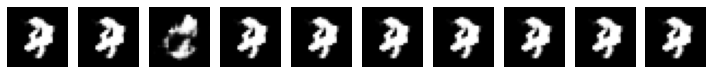

9700 [D loss: 0.003744, acc.: 100.00%] [G loss: 3.907025]
9701 [D loss: 0.076364, acc.: 97.66%] [G loss: 3.586773]
9702 [D loss: 0.098204, acc.: 96.88%] [G loss: 2.303061]
9703 [D loss: 0.021246, acc.: 99.22%] [G loss: 2.131801]
9704 [D loss: 0.023178, acc.: 99.22%] [G loss: 2.433722]
9705 [D loss: 0.047380, acc.: 99.22%] [G loss: 2.567345]
9706 [D loss: 0.004250, acc.: 100.00%] [G loss: 2.495940]
9707 [D loss: 0.012036, acc.: 99.22%] [G loss: 2.674868]
9708 [D loss: 0.038980, acc.: 98.44%] [G loss: 2.371106]
9709 [D loss: 0.010831, acc.: 100.00%] [G loss: 1.973146]
9710 [D loss: 0.071439, acc.: 97.66%] [G loss: 1.940387]
9711 [D loss: 0.006236, acc.: 100.00%] [G loss: 2.381466]
9712 [D loss: 0.008118, acc.: 100.00%] [G loss: 3.492392]
9713 [D loss: 0.024453, acc.: 99.22%] [G loss: 3.044159]
9714 [D loss: 0.014011, acc.: 99.22%] [G loss: 2.424718]
9715 [D loss: 0.002623, acc.: 100.00%] [G loss: 1.774843]
9716 [D loss: 0.015775, acc.: 99.22%] [G loss: 1.416532]
9717 [D loss: 0.019072, a

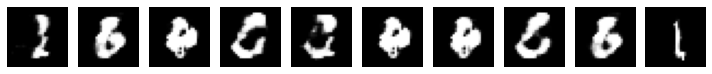

9800 [D loss: 0.002095, acc.: 100.00%] [G loss: 2.559999]
9801 [D loss: 0.004351, acc.: 100.00%] [G loss: 3.224581]
9802 [D loss: 0.003291, acc.: 100.00%] [G loss: 3.531678]
9803 [D loss: 0.000941, acc.: 100.00%] [G loss: 4.070636]
9804 [D loss: 0.015397, acc.: 99.22%] [G loss: 3.564366]
9805 [D loss: 0.003026, acc.: 100.00%] [G loss: 3.510760]
9806 [D loss: 0.005085, acc.: 100.00%] [G loss: 3.097996]
9807 [D loss: 0.026778, acc.: 99.22%] [G loss: 3.800487]
9808 [D loss: 0.025973, acc.: 99.22%] [G loss: 4.102641]
9809 [D loss: 0.110397, acc.: 98.44%] [G loss: 2.979491]
9810 [D loss: 0.008961, acc.: 100.00%] [G loss: 2.392830]
9811 [D loss: 0.003705, acc.: 100.00%] [G loss: 2.291305]
9812 [D loss: 0.007758, acc.: 100.00%] [G loss: 2.237137]
9813 [D loss: 0.006845, acc.: 100.00%] [G loss: 2.727576]
9814 [D loss: 0.007999, acc.: 100.00%] [G loss: 2.954658]
9815 [D loss: 0.021050, acc.: 99.22%] [G loss: 4.077097]
9816 [D loss: 0.000983, acc.: 100.00%] [G loss: 5.356666]
9817 [D loss: 0.057

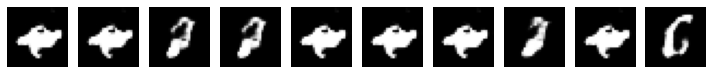

9900 [D loss: 0.041117, acc.: 98.44%] [G loss: 2.298992]
9901 [D loss: 0.002264, acc.: 100.00%] [G loss: 3.282475]
9902 [D loss: 0.055998, acc.: 97.66%] [G loss: 3.739238]
9903 [D loss: 0.034746, acc.: 98.44%] [G loss: 3.210989]
9904 [D loss: 0.001664, acc.: 100.00%] [G loss: 2.293701]
9905 [D loss: 0.002060, acc.: 100.00%] [G loss: 2.158567]
9906 [D loss: 0.005987, acc.: 100.00%] [G loss: 1.975770]
9907 [D loss: 0.016459, acc.: 99.22%] [G loss: 2.133443]
9908 [D loss: 0.022442, acc.: 98.44%] [G loss: 2.615554]
9909 [D loss: 0.107052, acc.: 96.88%] [G loss: 2.041234]
9910 [D loss: 0.093942, acc.: 98.44%] [G loss: 1.925232]
9911 [D loss: 0.077727, acc.: 97.66%] [G loss: 0.959127]
9912 [D loss: 0.041942, acc.: 98.44%] [G loss: 1.108668]
9913 [D loss: 0.010135, acc.: 100.00%] [G loss: 1.594852]
9914 [D loss: 0.061293, acc.: 97.66%] [G loss: 1.791244]
9915 [D loss: 0.004814, acc.: 100.00%] [G loss: 2.039834]
9916 [D loss: 0.016070, acc.: 99.22%] [G loss: 2.180029]
9917 [D loss: 0.032015, a

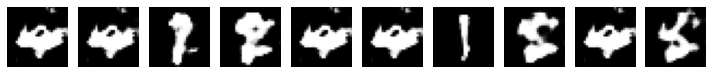

10000 [D loss: 0.017306, acc.: 99.22%] [G loss: 8.546193]
10001 [D loss: 0.028716, acc.: 98.44%] [G loss: 8.551788]
10002 [D loss: 0.004021, acc.: 100.00%] [G loss: 7.802637]
10003 [D loss: 0.000106, acc.: 100.00%] [G loss: 9.402490]
10004 [D loss: 0.022412, acc.: 99.22%] [G loss: 8.257401]
10005 [D loss: 0.039883, acc.: 97.66%] [G loss: 7.146945]
10006 [D loss: 0.008022, acc.: 100.00%] [G loss: 6.570612]
10007 [D loss: 0.002509, acc.: 100.00%] [G loss: 5.719092]
10008 [D loss: 0.028416, acc.: 97.66%] [G loss: 2.696664]
10009 [D loss: 0.024246, acc.: 98.44%] [G loss: 1.492136]
10010 [D loss: 0.070753, acc.: 96.88%] [G loss: 1.199287]
10011 [D loss: 0.011572, acc.: 100.00%] [G loss: 1.707435]
10012 [D loss: 0.000867, acc.: 100.00%] [G loss: 3.714718]
10013 [D loss: 0.001023, acc.: 100.00%] [G loss: 5.039193]
10014 [D loss: 0.008557, acc.: 100.00%] [G loss: 5.587983]
10015 [D loss: 0.000148, acc.: 100.00%] [G loss: 7.032088]
10016 [D loss: 0.000235, acc.: 100.00%] [G loss: 6.235025]
1001

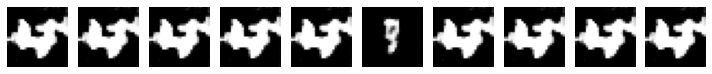

10100 [D loss: 0.011519, acc.: 99.22%] [G loss: 1.335825]
10101 [D loss: 0.002254, acc.: 100.00%] [G loss: 1.033656]
10102 [D loss: 0.000589, acc.: 100.00%] [G loss: 1.315551]
10103 [D loss: 0.007947, acc.: 100.00%] [G loss: 1.375956]
10104 [D loss: 0.003795, acc.: 100.00%] [G loss: 0.993701]
10105 [D loss: 0.032945, acc.: 99.22%] [G loss: 1.273981]
10106 [D loss: 0.005005, acc.: 100.00%] [G loss: 1.687871]
10107 [D loss: 0.005827, acc.: 100.00%] [G loss: 1.518731]
10108 [D loss: 0.000752, acc.: 100.00%] [G loss: 1.803099]
10109 [D loss: 0.030931, acc.: 99.22%] [G loss: 1.846443]
10110 [D loss: 0.005943, acc.: 100.00%] [G loss: 1.583051]
10111 [D loss: 0.002406, acc.: 100.00%] [G loss: 1.480109]
10112 [D loss: 0.007423, acc.: 100.00%] [G loss: 1.109842]
10113 [D loss: 0.004557, acc.: 100.00%] [G loss: 1.063417]
10114 [D loss: 0.046998, acc.: 99.22%] [G loss: 0.795144]
10115 [D loss: 0.001952, acc.: 100.00%] [G loss: 0.711211]
10116 [D loss: 0.020622, acc.: 98.44%] [G loss: 0.962265]
10

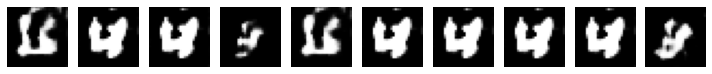

10200 [D loss: 0.001117, acc.: 100.00%] [G loss: 5.022984]
10201 [D loss: 0.001629, acc.: 100.00%] [G loss: 5.973233]
10202 [D loss: 0.026972, acc.: 99.22%] [G loss: 6.422854]
10203 [D loss: 0.018373, acc.: 99.22%] [G loss: 5.561296]
10204 [D loss: 0.001718, acc.: 100.00%] [G loss: 4.947167]
10205 [D loss: 0.002747, acc.: 100.00%] [G loss: 4.433875]
10206 [D loss: 0.032848, acc.: 97.66%] [G loss: 4.612760]
10207 [D loss: 0.001490, acc.: 100.00%] [G loss: 5.112761]
10208 [D loss: 0.000190, acc.: 100.00%] [G loss: 5.452739]
10209 [D loss: 0.059955, acc.: 97.66%] [G loss: 3.922340]
10210 [D loss: 0.030918, acc.: 99.22%] [G loss: 2.053766]
10211 [D loss: 0.026566, acc.: 98.44%] [G loss: 2.185721]
10212 [D loss: 0.001579, acc.: 100.00%] [G loss: 2.821018]
10213 [D loss: 0.000468, acc.: 100.00%] [G loss: 3.302791]
10214 [D loss: 0.002842, acc.: 100.00%] [G loss: 3.299677]
10215 [D loss: 0.005715, acc.: 99.22%] [G loss: 3.792169]
10216 [D loss: 0.001031, acc.: 100.00%] [G loss: 3.125788]
1021

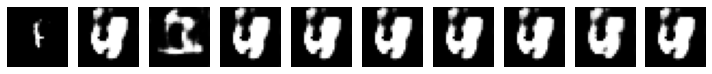

10300 [D loss: 0.000408, acc.: 100.00%] [G loss: 1.846258]
10301 [D loss: 0.003806, acc.: 100.00%] [G loss: 1.594386]
10302 [D loss: 0.000634, acc.: 100.00%] [G loss: 1.423186]
10303 [D loss: 0.001577, acc.: 100.00%] [G loss: 1.663769]
10304 [D loss: 0.007990, acc.: 100.00%] [G loss: 1.296969]
10305 [D loss: 0.013377, acc.: 99.22%] [G loss: 0.717642]
10306 [D loss: 0.022114, acc.: 99.22%] [G loss: 1.122527]
10307 [D loss: 0.001839, acc.: 100.00%] [G loss: 1.783646]
10308 [D loss: 0.036351, acc.: 99.22%] [G loss: 2.565291]
10309 [D loss: 0.000252, acc.: 100.00%] [G loss: 2.408626]
10310 [D loss: 0.003403, acc.: 100.00%] [G loss: 1.677452]
10311 [D loss: 0.007574, acc.: 99.22%] [G loss: 1.271879]
10312 [D loss: 0.025640, acc.: 99.22%] [G loss: 0.901698]
10313 [D loss: 0.002415, acc.: 100.00%] [G loss: 0.691361]
10314 [D loss: 0.019778, acc.: 99.22%] [G loss: 0.739867]
10315 [D loss: 0.002852, acc.: 100.00%] [G loss: 0.739073]
10316 [D loss: 0.002915, acc.: 100.00%] [G loss: 1.008117]
103

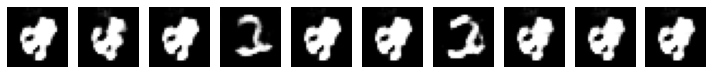

10400 [D loss: 0.093811, acc.: 96.88%] [G loss: 0.530978]
10401 [D loss: 0.000593, acc.: 100.00%] [G loss: 2.108425]
10402 [D loss: 0.001069, acc.: 100.00%] [G loss: 4.059116]
10403 [D loss: 0.098689, acc.: 97.66%] [G loss: 3.636091]
10404 [D loss: 0.033944, acc.: 98.44%] [G loss: 2.361879]
10405 [D loss: 0.082629, acc.: 97.66%] [G loss: 0.828723]
10406 [D loss: 0.037652, acc.: 99.22%] [G loss: 0.368682]
10407 [D loss: 0.043951, acc.: 99.22%] [G loss: 0.458475]
10408 [D loss: 0.010425, acc.: 99.22%] [G loss: 0.505027]
10409 [D loss: 0.004833, acc.: 100.00%] [G loss: 1.200920]
10410 [D loss: 0.007077, acc.: 100.00%] [G loss: 1.242867]
10411 [D loss: 0.028885, acc.: 98.44%] [G loss: 1.520916]
10412 [D loss: 0.006507, acc.: 100.00%] [G loss: 1.209717]
10413 [D loss: 0.001896, acc.: 100.00%] [G loss: 1.054134]
10414 [D loss: 0.025725, acc.: 99.22%] [G loss: 0.914917]
10415 [D loss: 0.000321, acc.: 100.00%] [G loss: 1.068241]
10416 [D loss: 0.007993, acc.: 99.22%] [G loss: 1.062253]
10417 [

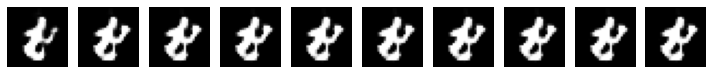

10500 [D loss: 0.009183, acc.: 99.22%] [G loss: 3.447260]
10501 [D loss: 0.007333, acc.: 100.00%] [G loss: 2.927550]
10502 [D loss: 0.025688, acc.: 99.22%] [G loss: 2.862487]
10503 [D loss: 0.000168, acc.: 100.00%] [G loss: 3.455197]
10504 [D loss: 0.008245, acc.: 100.00%] [G loss: 3.731496]
10505 [D loss: 0.019289, acc.: 99.22%] [G loss: 3.349287]
10506 [D loss: 0.031685, acc.: 97.66%] [G loss: 2.404514]
10507 [D loss: 0.020193, acc.: 98.44%] [G loss: 2.298450]
10508 [D loss: 0.042455, acc.: 98.44%] [G loss: 2.000464]
10509 [D loss: 0.010539, acc.: 99.22%] [G loss: 2.159756]
10510 [D loss: 0.000646, acc.: 100.00%] [G loss: 3.301095]
10511 [D loss: 0.000720, acc.: 100.00%] [G loss: 3.522706]
10512 [D loss: 0.000253, acc.: 100.00%] [G loss: 3.805510]
10513 [D loss: 0.105603, acc.: 99.22%] [G loss: 3.724088]
10514 [D loss: 0.025315, acc.: 99.22%] [G loss: 2.754018]
10515 [D loss: 0.017965, acc.: 99.22%] [G loss: 2.523486]
10516 [D loss: 0.003163, acc.: 100.00%] [G loss: 2.552673]
10517 [

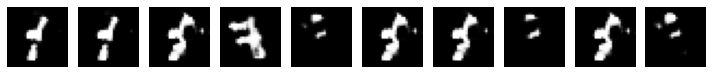

10600 [D loss: 0.002186, acc.: 100.00%] [G loss: 3.769803]
10601 [D loss: 0.018371, acc.: 98.44%] [G loss: 2.684416]
10602 [D loss: 0.002899, acc.: 100.00%] [G loss: 2.540070]
10603 [D loss: 0.007207, acc.: 100.00%] [G loss: 2.448668]
10604 [D loss: 0.005113, acc.: 100.00%] [G loss: 2.283909]
10605 [D loss: 0.002219, acc.: 100.00%] [G loss: 2.644039]
10606 [D loss: 0.004946, acc.: 100.00%] [G loss: 3.081111]
10607 [D loss: 0.003611, acc.: 100.00%] [G loss: 3.030711]
10608 [D loss: 0.000379, acc.: 100.00%] [G loss: 2.829471]
10609 [D loss: 0.017406, acc.: 99.22%] [G loss: 3.203638]
10610 [D loss: 0.005150, acc.: 100.00%] [G loss: 2.469888]
10611 [D loss: 0.014737, acc.: 99.22%] [G loss: 2.147017]
10612 [D loss: 0.003779, acc.: 100.00%] [G loss: 2.724121]
10613 [D loss: 0.028639, acc.: 99.22%] [G loss: 3.003896]
10614 [D loss: 0.001418, acc.: 100.00%] [G loss: 2.637138]
10615 [D loss: 0.001873, acc.: 100.00%] [G loss: 3.043244]
10616 [D loss: 0.012425, acc.: 99.22%] [G loss: 2.777766]
10

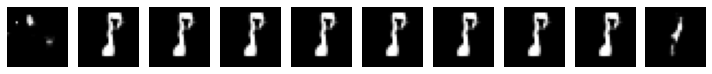

10700 [D loss: 0.002406, acc.: 100.00%] [G loss: 3.801441]
10701 [D loss: 0.005226, acc.: 100.00%] [G loss: 4.674287]
10702 [D loss: 0.000883, acc.: 100.00%] [G loss: 3.261166]
10703 [D loss: 0.025251, acc.: 99.22%] [G loss: 2.913474]
10704 [D loss: 0.005157, acc.: 100.00%] [G loss: 2.900145]
10705 [D loss: 0.002507, acc.: 100.00%] [G loss: 4.234304]
10706 [D loss: 0.002114, acc.: 100.00%] [G loss: 3.138682]
10707 [D loss: 0.012558, acc.: 99.22%] [G loss: 4.043858]
10708 [D loss: 0.003450, acc.: 100.00%] [G loss: 3.462549]
10709 [D loss: 0.000380, acc.: 100.00%] [G loss: 2.723240]
10710 [D loss: 0.045489, acc.: 99.22%] [G loss: 2.190419]
10711 [D loss: 0.051425, acc.: 98.44%] [G loss: 2.583522]
10712 [D loss: 0.024094, acc.: 99.22%] [G loss: 2.974288]
10713 [D loss: 0.009530, acc.: 99.22%] [G loss: 3.300493]
10714 [D loss: 0.000555, acc.: 100.00%] [G loss: 2.879900]
10715 [D loss: 0.039398, acc.: 99.22%] [G loss: 2.301539]
10716 [D loss: 0.024481, acc.: 98.44%] [G loss: 2.104150]
10717

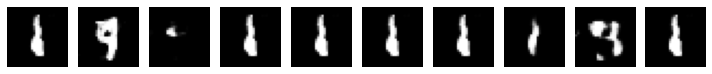

10800 [D loss: 0.011484, acc.: 99.22%] [G loss: 4.244438]
10801 [D loss: 0.003108, acc.: 100.00%] [G loss: 5.310886]
10802 [D loss: 0.020698, acc.: 99.22%] [G loss: 4.136097]
10803 [D loss: 0.014146, acc.: 99.22%] [G loss: 3.253179]
10804 [D loss: 0.001313, acc.: 100.00%] [G loss: 3.016883]
10805 [D loss: 0.002792, acc.: 100.00%] [G loss: 2.646677]
10806 [D loss: 0.015137, acc.: 100.00%] [G loss: 1.600782]
10807 [D loss: 0.048834, acc.: 97.66%] [G loss: 2.713956]
10808 [D loss: 0.017906, acc.: 99.22%] [G loss: 3.277870]
10809 [D loss: 0.000937, acc.: 100.00%] [G loss: 3.993426]
10810 [D loss: 0.008088, acc.: 100.00%] [G loss: 3.623877]
10811 [D loss: 0.116912, acc.: 98.44%] [G loss: 2.810554]
10812 [D loss: 0.002548, acc.: 100.00%] [G loss: 2.221037]
10813 [D loss: 0.010846, acc.: 100.00%] [G loss: 2.369092]
10814 [D loss: 0.007943, acc.: 100.00%] [G loss: 2.966679]
10815 [D loss: 0.004771, acc.: 100.00%] [G loss: 3.721889]
10816 [D loss: 0.001738, acc.: 100.00%] [G loss: 3.965384]
108

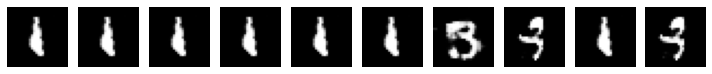

10900 [D loss: 0.000607, acc.: 100.00%] [G loss: 8.721654]
10901 [D loss: 0.003173, acc.: 100.00%] [G loss: 7.957172]
10902 [D loss: 0.038193, acc.: 99.22%] [G loss: 6.214062]
10903 [D loss: 0.000870, acc.: 100.00%] [G loss: 6.377512]
10904 [D loss: 0.001859, acc.: 100.00%] [G loss: 4.505747]
10905 [D loss: 0.012084, acc.: 100.00%] [G loss: 4.596828]
10906 [D loss: 0.002725, acc.: 100.00%] [G loss: 5.178660]
10907 [D loss: 0.001094, acc.: 100.00%] [G loss: 6.055898]
10908 [D loss: 0.001797, acc.: 100.00%] [G loss: 6.577512]
10909 [D loss: 0.001597, acc.: 100.00%] [G loss: 6.467082]
10910 [D loss: 0.075476, acc.: 98.44%] [G loss: 5.491679]
10911 [D loss: 0.017592, acc.: 99.22%] [G loss: 4.811155]
10912 [D loss: 0.014535, acc.: 99.22%] [G loss: 5.071258]
10913 [D loss: 0.019071, acc.: 99.22%] [G loss: 6.240165]
10914 [D loss: 0.006573, acc.: 100.00%] [G loss: 7.194230]
10915 [D loss: 0.037031, acc.: 99.22%] [G loss: 7.187743]
10916 [D loss: 0.022630, acc.: 99.22%] [G loss: 6.000300]
1091

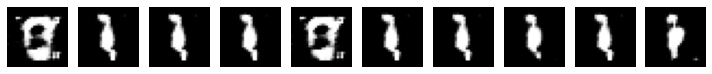

11000 [D loss: 0.011556, acc.: 99.22%] [G loss: 3.713339]
11001 [D loss: 0.006588, acc.: 100.00%] [G loss: 3.876431]
11002 [D loss: 0.006481, acc.: 100.00%] [G loss: 5.047614]
11003 [D loss: 0.003856, acc.: 100.00%] [G loss: 6.612710]
11004 [D loss: 0.001256, acc.: 100.00%] [G loss: 7.452417]
11005 [D loss: 0.027026, acc.: 98.44%] [G loss: 7.517813]
11006 [D loss: 0.036231, acc.: 99.22%] [G loss: 5.896116]
11007 [D loss: 0.000491, acc.: 100.00%] [G loss: 4.982278]
11008 [D loss: 0.000858, acc.: 100.00%] [G loss: 4.661542]
11009 [D loss: 0.001621, acc.: 100.00%] [G loss: 3.319288]
11010 [D loss: 0.006675, acc.: 100.00%] [G loss: 2.738202]
11011 [D loss: 0.017744, acc.: 99.22%] [G loss: 4.172262]
11012 [D loss: 0.016542, acc.: 99.22%] [G loss: 6.010384]
11013 [D loss: 0.094734, acc.: 99.22%] [G loss: 5.356606]
11014 [D loss: 0.001124, acc.: 100.00%] [G loss: 6.247770]
11015 [D loss: 0.066102, acc.: 99.22%] [G loss: 6.037283]
11016 [D loss: 0.011744, acc.: 99.22%] [G loss: 5.007183]
11017

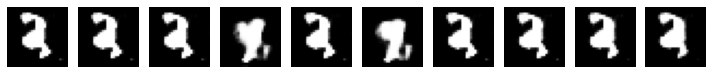

11100 [D loss: 0.001155, acc.: 100.00%] [G loss: 3.959285]
11101 [D loss: 0.020349, acc.: 98.44%] [G loss: 5.773999]
11102 [D loss: 0.001953, acc.: 100.00%] [G loss: 7.501420]
11103 [D loss: 0.010780, acc.: 99.22%] [G loss: 7.798748]
11104 [D loss: 0.056060, acc.: 97.66%] [G loss: 7.546906]
11105 [D loss: 0.000164, acc.: 100.00%] [G loss: 7.653380]
11106 [D loss: 0.001025, acc.: 100.00%] [G loss: 7.098158]
11107 [D loss: 0.011796, acc.: 100.00%] [G loss: 7.133285]
11108 [D loss: 0.001312, acc.: 100.00%] [G loss: 8.929028]
11109 [D loss: 0.002373, acc.: 100.00%] [G loss: 8.531298]
11110 [D loss: 0.005640, acc.: 100.00%] [G loss: 7.659169]
11111 [D loss: 0.001843, acc.: 100.00%] [G loss: 6.091787]
11112 [D loss: 0.026868, acc.: 98.44%] [G loss: 4.135395]
11113 [D loss: 0.023183, acc.: 99.22%] [G loss: 2.863149]
11114 [D loss: 0.011609, acc.: 100.00%] [G loss: 2.952350]
11115 [D loss: 0.019467, acc.: 99.22%] [G loss: 3.964258]
11116 [D loss: 0.001842, acc.: 100.00%] [G loss: 4.734581]
111

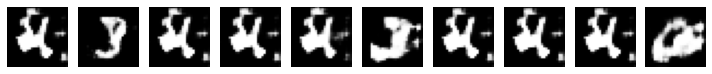

11200 [D loss: 0.006466, acc.: 99.22%] [G loss: 2.234292]
11201 [D loss: 0.005909, acc.: 100.00%] [G loss: 2.311405]
11202 [D loss: 0.037862, acc.: 99.22%] [G loss: 1.308278]
11203 [D loss: 0.013784, acc.: 100.00%] [G loss: 0.800954]
11204 [D loss: 0.006344, acc.: 100.00%] [G loss: 1.051594]
11205 [D loss: 0.030241, acc.: 98.44%] [G loss: 1.678740]
11206 [D loss: 0.004540, acc.: 100.00%] [G loss: 2.616584]
11207 [D loss: 0.000222, acc.: 100.00%] [G loss: 4.221708]
11208 [D loss: 0.009624, acc.: 100.00%] [G loss: 4.110578]
11209 [D loss: 0.014843, acc.: 99.22%] [G loss: 3.447756]
11210 [D loss: 0.016299, acc.: 98.44%] [G loss: 2.530748]
11211 [D loss: 0.005858, acc.: 100.00%] [G loss: 2.009243]
11212 [D loss: 0.002678, acc.: 100.00%] [G loss: 1.944534]
11213 [D loss: 0.012369, acc.: 99.22%] [G loss: 2.112794]
11214 [D loss: 0.008894, acc.: 99.22%] [G loss: 3.841603]
11215 [D loss: 0.002268, acc.: 100.00%] [G loss: 5.555194]
11216 [D loss: 0.002232, acc.: 100.00%] [G loss: 5.980204]
1121

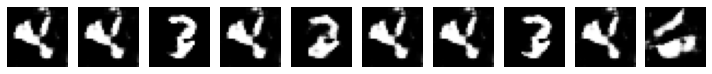

11300 [D loss: 0.006317, acc.: 100.00%] [G loss: 1.339246]
11301 [D loss: 0.005084, acc.: 100.00%] [G loss: 1.881713]
11302 [D loss: 0.000864, acc.: 100.00%] [G loss: 2.396122]
11303 [D loss: 0.000930, acc.: 100.00%] [G loss: 3.562135]
11304 [D loss: 0.000074, acc.: 100.00%] [G loss: 4.476904]
11305 [D loss: 0.107902, acc.: 96.09%] [G loss: 1.535287]
11306 [D loss: 0.037595, acc.: 98.44%] [G loss: 0.873740]
11307 [D loss: 0.213772, acc.: 96.09%] [G loss: 4.945252]
11308 [D loss: 0.061506, acc.: 97.66%] [G loss: 8.712389]
11309 [D loss: 0.157725, acc.: 98.44%] [G loss: 8.175857]
11310 [D loss: 0.001619, acc.: 100.00%] [G loss: 7.263546]
11311 [D loss: 0.055167, acc.: 97.66%] [G loss: 4.223302]
11312 [D loss: 0.100195, acc.: 96.88%] [G loss: 2.524203]
11313 [D loss: 0.003400, acc.: 100.00%] [G loss: 2.657139]
11314 [D loss: 0.010332, acc.: 99.22%] [G loss: 1.784337]
11315 [D loss: 0.026977, acc.: 98.44%] [G loss: 2.771928]
11316 [D loss: 0.030295, acc.: 98.44%] [G loss: 4.606080]
11317 [

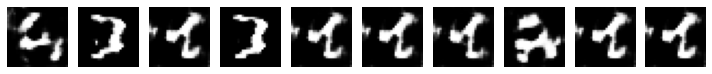

11400 [D loss: 0.006535, acc.: 99.22%] [G loss: 2.651170]
11401 [D loss: 0.042881, acc.: 99.22%] [G loss: 1.892519]
11402 [D loss: 0.013347, acc.: 99.22%] [G loss: 2.085852]
11403 [D loss: 0.015351, acc.: 99.22%] [G loss: 1.812958]
11404 [D loss: 0.011140, acc.: 99.22%] [G loss: 1.214551]
11405 [D loss: 0.021663, acc.: 99.22%] [G loss: 0.954703]
11406 [D loss: 0.057032, acc.: 97.66%] [G loss: 1.003280]
11407 [D loss: 0.025498, acc.: 98.44%] [G loss: 1.874366]
11408 [D loss: 0.006194, acc.: 100.00%] [G loss: 3.849152]
11409 [D loss: 0.013190, acc.: 99.22%] [G loss: 5.608629]
11410 [D loss: 0.001065, acc.: 100.00%] [G loss: 7.131963]
11411 [D loss: 0.100506, acc.: 96.09%] [G loss: 3.339165]
11412 [D loss: 0.034038, acc.: 99.22%] [G loss: 1.501395]
11413 [D loss: 0.014957, acc.: 100.00%] [G loss: 2.030106]
11414 [D loss: 0.001875, acc.: 100.00%] [G loss: 2.724113]
11415 [D loss: 0.000520, acc.: 100.00%] [G loss: 2.488388]
11416 [D loss: 0.010364, acc.: 99.22%] [G loss: 2.622170]
11417 [D 

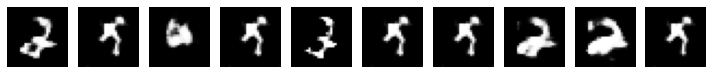

11500 [D loss: 0.064681, acc.: 96.88%] [G loss: 2.903547]
11501 [D loss: 0.014363, acc.: 99.22%] [G loss: 2.059241]
11502 [D loss: 0.017855, acc.: 99.22%] [G loss: 2.421407]
11503 [D loss: 0.008553, acc.: 100.00%] [G loss: 3.854327]
11504 [D loss: 0.005612, acc.: 100.00%] [G loss: 4.651399]
11505 [D loss: 0.033345, acc.: 98.44%] [G loss: 4.532185]
11506 [D loss: 0.016025, acc.: 99.22%] [G loss: 4.157318]
11507 [D loss: 0.096282, acc.: 96.88%] [G loss: 2.327891]
11508 [D loss: 0.054724, acc.: 99.22%] [G loss: 1.296837]
11509 [D loss: 0.062433, acc.: 99.22%] [G loss: 1.730206]
11510 [D loss: 0.010269, acc.: 99.22%] [G loss: 3.082216]
11511 [D loss: 0.002774, acc.: 100.00%] [G loss: 4.804933]
11512 [D loss: 0.012582, acc.: 99.22%] [G loss: 5.698684]
11513 [D loss: 0.000943, acc.: 100.00%] [G loss: 6.458079]
11514 [D loss: 0.000342, acc.: 100.00%] [G loss: 6.626842]
11515 [D loss: 0.004919, acc.: 100.00%] [G loss: 6.917786]
11516 [D loss: 0.006698, acc.: 99.22%] [G loss: 6.678071]
11517 [D

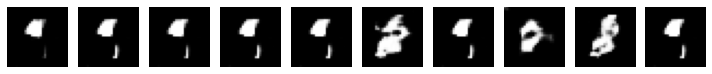

11600 [D loss: 0.045875, acc.: 98.44%] [G loss: 5.557412]
11601 [D loss: 0.006136, acc.: 100.00%] [G loss: 6.415774]
11602 [D loss: 0.016716, acc.: 99.22%] [G loss: 5.885876]
11603 [D loss: 0.004026, acc.: 100.00%] [G loss: 5.801769]
11604 [D loss: 0.001361, acc.: 100.00%] [G loss: 5.385241]
11605 [D loss: 0.004058, acc.: 100.00%] [G loss: 5.219525]
11606 [D loss: 0.001679, acc.: 100.00%] [G loss: 5.252534]
11607 [D loss: 0.009488, acc.: 100.00%] [G loss: 5.257823]
11608 [D loss: 0.018954, acc.: 99.22%] [G loss: 4.927998]
11609 [D loss: 0.001859, acc.: 100.00%] [G loss: 5.678764]
11610 [D loss: 0.000444, acc.: 100.00%] [G loss: 5.634248]
11611 [D loss: 0.000763, acc.: 100.00%] [G loss: 5.624886]
11612 [D loss: 0.017415, acc.: 99.22%] [G loss: 5.244735]
11613 [D loss: 0.002724, acc.: 100.00%] [G loss: 4.926476]
11614 [D loss: 0.001252, acc.: 100.00%] [G loss: 4.323296]
11615 [D loss: 0.022817, acc.: 99.22%] [G loss: 4.210299]
11616 [D loss: 0.004286, acc.: 100.00%] [G loss: 5.090384]
11

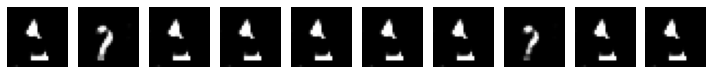

11700 [D loss: 0.038855, acc.: 98.44%] [G loss: 7.517095]
11701 [D loss: 0.014901, acc.: 99.22%] [G loss: 6.118937]
11702 [D loss: 0.009331, acc.: 99.22%] [G loss: 4.466630]
11703 [D loss: 0.003507, acc.: 100.00%] [G loss: 3.059595]
11704 [D loss: 0.010563, acc.: 99.22%] [G loss: 2.892848]
11705 [D loss: 0.002182, acc.: 100.00%] [G loss: 3.372828]
11706 [D loss: 0.045639, acc.: 98.44%] [G loss: 2.075583]
11707 [D loss: 0.014964, acc.: 99.22%] [G loss: 2.520562]
11708 [D loss: 0.001026, acc.: 100.00%] [G loss: 2.894995]
11709 [D loss: 0.014528, acc.: 99.22%] [G loss: 2.758807]
11710 [D loss: 0.002145, acc.: 100.00%] [G loss: 2.726663]
11711 [D loss: 0.011596, acc.: 100.00%] [G loss: 2.928922]
11712 [D loss: 0.001579, acc.: 100.00%] [G loss: 3.518693]
11713 [D loss: 0.000646, acc.: 100.00%] [G loss: 3.464139]
11714 [D loss: 0.027070, acc.: 99.22%] [G loss: 3.428878]
11715 [D loss: 0.001503, acc.: 100.00%] [G loss: 3.384398]
11716 [D loss: 0.001886, acc.: 100.00%] [G loss: 3.079865]
11717

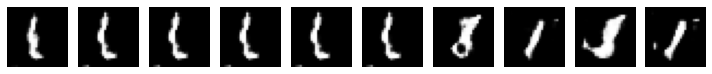

11800 [D loss: 0.003202, acc.: 100.00%] [G loss: 2.346807]
11801 [D loss: 0.001386, acc.: 100.00%] [G loss: 2.793256]
11802 [D loss: 0.006275, acc.: 100.00%] [G loss: 2.470546]
11803 [D loss: 0.015204, acc.: 99.22%] [G loss: 1.992518]
11804 [D loss: 0.008606, acc.: 100.00%] [G loss: 1.621074]
11805 [D loss: 0.009259, acc.: 100.00%] [G loss: 1.950959]
11806 [D loss: 0.002019, acc.: 100.00%] [G loss: 2.918550]
11807 [D loss: 0.006291, acc.: 100.00%] [G loss: 3.696249]
11808 [D loss: 0.001301, acc.: 100.00%] [G loss: 4.512373]
11809 [D loss: 0.029418, acc.: 99.22%] [G loss: 4.594192]
11810 [D loss: 0.003457, acc.: 100.00%] [G loss: 4.115197]
11811 [D loss: 0.020588, acc.: 99.22%] [G loss: 4.962577]
11812 [D loss: 0.027935, acc.: 99.22%] [G loss: 4.675854]
11813 [D loss: 0.000985, acc.: 100.00%] [G loss: 4.997234]
11814 [D loss: 0.007253, acc.: 100.00%] [G loss: 4.600060]
11815 [D loss: 0.011775, acc.: 100.00%] [G loss: 4.876973]
11816 [D loss: 0.003825, acc.: 100.00%] [G loss: 4.141957]
1

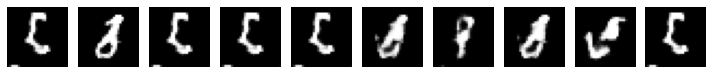

11900 [D loss: 0.003123, acc.: 100.00%] [G loss: 2.054378]
11901 [D loss: 0.022066, acc.: 99.22%] [G loss: 1.841962]
11902 [D loss: 0.001286, acc.: 100.00%] [G loss: 2.431221]
11903 [D loss: 0.022160, acc.: 99.22%] [G loss: 2.412156]
11904 [D loss: 0.013088, acc.: 99.22%] [G loss: 1.965879]
11905 [D loss: 0.018974, acc.: 99.22%] [G loss: 1.584042]
11906 [D loss: 0.005757, acc.: 100.00%] [G loss: 1.531584]
11907 [D loss: 0.000539, acc.: 100.00%] [G loss: 1.681122]
11908 [D loss: 0.026984, acc.: 99.22%] [G loss: 1.422433]
11909 [D loss: 0.018154, acc.: 98.44%] [G loss: 1.644154]
11910 [D loss: 0.005413, acc.: 100.00%] [G loss: 2.429758]
11911 [D loss: 0.001944, acc.: 100.00%] [G loss: 2.532273]
11912 [D loss: 0.009098, acc.: 99.22%] [G loss: 2.703241]
11913 [D loss: 0.026117, acc.: 99.22%] [G loss: 2.087289]
11914 [D loss: 0.006231, acc.: 100.00%] [G loss: 1.487111]
11915 [D loss: 0.005825, acc.: 100.00%] [G loss: 1.537048]
11916 [D loss: 0.002507, acc.: 100.00%] [G loss: 1.168023]
11917

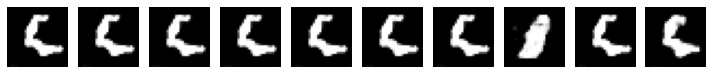

12000 [D loss: 0.000327, acc.: 100.00%] [G loss: 1.537713]
12001 [D loss: 0.036008, acc.: 99.22%] [G loss: 1.319225]
12002 [D loss: 0.006312, acc.: 100.00%] [G loss: 1.248633]
12003 [D loss: 0.018516, acc.: 98.44%] [G loss: 1.167936]
12004 [D loss: 0.001410, acc.: 100.00%] [G loss: 1.372617]
12005 [D loss: 0.002699, acc.: 100.00%] [G loss: 2.142291]
12006 [D loss: 0.031294, acc.: 99.22%] [G loss: 2.024681]
12007 [D loss: 0.001288, acc.: 100.00%] [G loss: 2.078823]
12008 [D loss: 0.016544, acc.: 99.22%] [G loss: 2.163479]
12009 [D loss: 0.004868, acc.: 100.00%] [G loss: 2.242033]
12010 [D loss: 0.022730, acc.: 99.22%] [G loss: 1.987667]
12011 [D loss: 0.002562, acc.: 100.00%] [G loss: 1.380921]
12012 [D loss: 0.007969, acc.: 100.00%] [G loss: 0.974792]
12013 [D loss: 0.006724, acc.: 100.00%] [G loss: 1.156474]
12014 [D loss: 0.002050, acc.: 100.00%] [G loss: 1.505749]
12015 [D loss: 0.002533, acc.: 100.00%] [G loss: 1.728917]
12016 [D loss: 0.050764, acc.: 98.44%] [G loss: 1.203375]
120

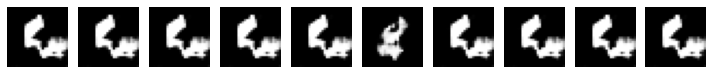

12100 [D loss: 0.002726, acc.: 100.00%] [G loss: 2.808718]
12101 [D loss: 0.034379, acc.: 99.22%] [G loss: 2.452493]
12102 [D loss: 0.028923, acc.: 97.66%] [G loss: 1.818364]
12103 [D loss: 0.005275, acc.: 100.00%] [G loss: 3.205178]
12104 [D loss: 0.008704, acc.: 100.00%] [G loss: 4.102767]
12105 [D loss: 0.015726, acc.: 99.22%] [G loss: 5.488490]
12106 [D loss: 0.003065, acc.: 100.00%] [G loss: 6.704149]
12107 [D loss: 0.000340, acc.: 100.00%] [G loss: 7.440495]
12108 [D loss: 0.000954, acc.: 100.00%] [G loss: 7.550964]
12109 [D loss: 0.036834, acc.: 98.44%] [G loss: 7.213597]
12110 [D loss: 0.000662, acc.: 100.00%] [G loss: 6.695579]
12111 [D loss: 0.061039, acc.: 98.44%] [G loss: 5.066903]
12112 [D loss: 0.001905, acc.: 100.00%] [G loss: 4.018046]
12113 [D loss: 0.062493, acc.: 98.44%] [G loss: 4.020788]
12114 [D loss: 0.006120, acc.: 100.00%] [G loss: 4.340279]
12115 [D loss: 0.003220, acc.: 100.00%] [G loss: 5.283386]
12116 [D loss: 0.000141, acc.: 100.00%] [G loss: 6.162164]
121

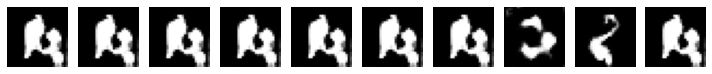

12200 [D loss: 0.007284, acc.: 100.00%] [G loss: 0.973562]
12201 [D loss: 0.011501, acc.: 99.22%] [G loss: 1.144733]
12202 [D loss: 0.002992, acc.: 100.00%] [G loss: 1.885234]
12203 [D loss: 0.000399, acc.: 100.00%] [G loss: 2.332003]
12204 [D loss: 0.004658, acc.: 100.00%] [G loss: 2.611804]
12205 [D loss: 0.003017, acc.: 100.00%] [G loss: 2.592211]
12206 [D loss: 0.003755, acc.: 100.00%] [G loss: 2.415176]
12207 [D loss: 0.000972, acc.: 100.00%] [G loss: 2.468388]
12208 [D loss: 0.002462, acc.: 100.00%] [G loss: 2.606311]
12209 [D loss: 0.006642, acc.: 99.22%] [G loss: 2.336630]
12210 [D loss: 0.001058, acc.: 100.00%] [G loss: 2.140084]
12211 [D loss: 0.004094, acc.: 100.00%] [G loss: 2.090406]
12212 [D loss: 0.013031, acc.: 99.22%] [G loss: 2.950763]
12213 [D loss: 0.000339, acc.: 100.00%] [G loss: 4.575675]
12214 [D loss: 0.000448, acc.: 100.00%] [G loss: 4.985849]
12215 [D loss: 0.000631, acc.: 100.00%] [G loss: 6.061295]
12216 [D loss: 0.001063, acc.: 100.00%] [G loss: 7.139146]


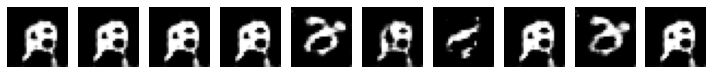

12300 [D loss: 0.000322, acc.: 100.00%] [G loss: 3.206132]
12301 [D loss: 0.025585, acc.: 99.22%] [G loss: 1.986955]
12302 [D loss: 0.017578, acc.: 99.22%] [G loss: 1.414149]
12303 [D loss: 0.002454, acc.: 100.00%] [G loss: 1.289089]
12304 [D loss: 0.002356, acc.: 100.00%] [G loss: 0.966440]
12305 [D loss: 0.012240, acc.: 99.22%] [G loss: 1.341792]
12306 [D loss: 0.003262, acc.: 100.00%] [G loss: 1.407688]
12307 [D loss: 0.000278, acc.: 100.00%] [G loss: 1.969594]
12308 [D loss: 0.000970, acc.: 100.00%] [G loss: 2.219615]
12309 [D loss: 0.001927, acc.: 100.00%] [G loss: 2.074625]
12310 [D loss: 0.039747, acc.: 98.44%] [G loss: 1.674731]
12311 [D loss: 0.001915, acc.: 100.00%] [G loss: 1.188475]
12312 [D loss: 0.018716, acc.: 99.22%] [G loss: 0.842085]
12313 [D loss: 0.011150, acc.: 99.22%] [G loss: 0.694895]
12314 [D loss: 0.003302, acc.: 100.00%] [G loss: 0.834707]
12315 [D loss: 0.012019, acc.: 99.22%] [G loss: 1.022464]
12316 [D loss: 0.001820, acc.: 100.00%] [G loss: 1.918218]
1231

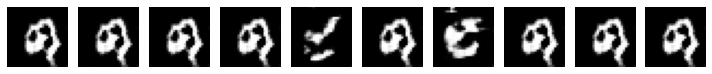

12400 [D loss: 0.001595, acc.: 100.00%] [G loss: 1.491410]
12401 [D loss: 0.009965, acc.: 99.22%] [G loss: 1.613597]
12402 [D loss: 0.001102, acc.: 100.00%] [G loss: 0.996952]
12403 [D loss: 0.028391, acc.: 98.44%] [G loss: 1.024023]
12404 [D loss: 0.030645, acc.: 99.22%] [G loss: 0.921139]
12405 [D loss: 0.017419, acc.: 99.22%] [G loss: 1.099895]
12406 [D loss: 0.007884, acc.: 100.00%] [G loss: 1.664189]
12407 [D loss: 0.002549, acc.: 100.00%] [G loss: 2.447927]
12408 [D loss: 0.003641, acc.: 100.00%] [G loss: 2.660104]
12409 [D loss: 0.035259, acc.: 98.44%] [G loss: 1.582481]
12410 [D loss: 0.023194, acc.: 98.44%] [G loss: 0.688665]
12411 [D loss: 0.012243, acc.: 99.22%] [G loss: 0.654165]
12412 [D loss: 0.001735, acc.: 100.00%] [G loss: 0.974673]
12413 [D loss: 0.001796, acc.: 100.00%] [G loss: 1.324298]
12414 [D loss: 0.002189, acc.: 100.00%] [G loss: 1.531369]
12415 [D loss: 0.005596, acc.: 100.00%] [G loss: 1.685872]
12416 [D loss: 0.000775, acc.: 100.00%] [G loss: 2.227242]
1241

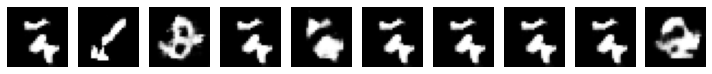

12500 [D loss: 0.005794, acc.: 100.00%] [G loss: 2.707783]
12501 [D loss: 0.000610, acc.: 100.00%] [G loss: 2.734601]
12502 [D loss: 0.002267, acc.: 100.00%] [G loss: 2.705049]
12503 [D loss: 0.028047, acc.: 98.44%] [G loss: 3.615272]
12504 [D loss: 0.074241, acc.: 97.66%] [G loss: 3.686066]
12505 [D loss: 0.061258, acc.: 98.44%] [G loss: 4.085327]
12506 [D loss: 0.000830, acc.: 100.00%] [G loss: 3.895779]
12507 [D loss: 0.000373, acc.: 100.00%] [G loss: 3.865342]
12508 [D loss: 0.000102, acc.: 100.00%] [G loss: 3.627085]
12509 [D loss: 0.011807, acc.: 99.22%] [G loss: 2.473849]
12510 [D loss: 0.006414, acc.: 100.00%] [G loss: 2.316327]
12511 [D loss: 0.050431, acc.: 99.22%] [G loss: 1.639557]
12512 [D loss: 0.006896, acc.: 100.00%] [G loss: 1.722007]
12513 [D loss: 0.011881, acc.: 100.00%] [G loss: 1.809481]
12514 [D loss: 0.001601, acc.: 100.00%] [G loss: 3.282262]
12515 [D loss: 0.004396, acc.: 100.00%] [G loss: 3.901914]
12516 [D loss: 0.000514, acc.: 100.00%] [G loss: 4.467738]
12

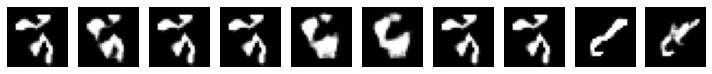

12600 [D loss: 0.001299, acc.: 100.00%] [G loss: 4.424942]
12601 [D loss: 0.000414, acc.: 100.00%] [G loss: 3.852089]
12602 [D loss: 0.012941, acc.: 99.22%] [G loss: 3.142662]
12603 [D loss: 0.002737, acc.: 100.00%] [G loss: 3.042538]
12604 [D loss: 0.003488, acc.: 100.00%] [G loss: 2.397872]
12605 [D loss: 0.007219, acc.: 100.00%] [G loss: 2.236933]
12606 [D loss: 0.010268, acc.: 99.22%] [G loss: 1.725307]
12607 [D loss: 0.009164, acc.: 99.22%] [G loss: 1.222501]
12608 [D loss: 0.007301, acc.: 100.00%] [G loss: 1.510724]
12609 [D loss: 0.051211, acc.: 99.22%] [G loss: 2.089801]
12610 [D loss: 0.011449, acc.: 99.22%] [G loss: 1.984395]
12611 [D loss: 0.004989, acc.: 100.00%] [G loss: 2.435325]
12612 [D loss: 0.003750, acc.: 100.00%] [G loss: 2.727528]
12613 [D loss: 0.001709, acc.: 100.00%] [G loss: 2.238524]
12614 [D loss: 0.047698, acc.: 97.66%] [G loss: 2.322618]
12615 [D loss: 0.012001, acc.: 99.22%] [G loss: 2.130431]
12616 [D loss: 0.053545, acc.: 99.22%] [G loss: 2.208311]
12617

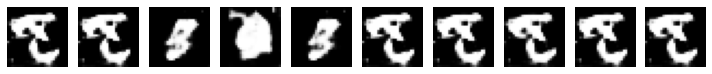

12700 [D loss: 0.008269, acc.: 99.22%] [G loss: 3.340742]
12701 [D loss: 0.048609, acc.: 97.66%] [G loss: 2.614970]
12702 [D loss: 0.002064, acc.: 100.00%] [G loss: 1.688246]
12703 [D loss: 0.053894, acc.: 97.66%] [G loss: 1.859070]
12704 [D loss: 0.000351, acc.: 100.00%] [G loss: 3.958302]
12705 [D loss: 0.000488, acc.: 100.00%] [G loss: 5.927272]
12706 [D loss: 0.000023, acc.: 100.00%] [G loss: 6.823537]
12707 [D loss: 0.004040, acc.: 100.00%] [G loss: 7.927032]
12708 [D loss: 0.011779, acc.: 99.22%] [G loss: 8.194624]
12709 [D loss: 0.000051, acc.: 100.00%] [G loss: 6.964122]
12710 [D loss: 0.000212, acc.: 100.00%] [G loss: 7.064938]
12711 [D loss: 0.000053, acc.: 100.00%] [G loss: 6.190202]
12712 [D loss: 0.013510, acc.: 99.22%] [G loss: 4.329518]
12713 [D loss: 0.000949, acc.: 100.00%] [G loss: 3.714947]
12714 [D loss: 0.001628, acc.: 100.00%] [G loss: 1.592080]
12715 [D loss: 0.027967, acc.: 98.44%] [G loss: 4.001494]
12716 [D loss: 0.002162, acc.: 100.00%] [G loss: 6.135515]
127

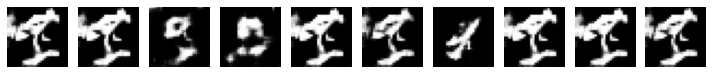

12800 [D loss: 0.003724, acc.: 100.00%] [G loss: 2.361505]
12801 [D loss: 0.000494, acc.: 100.00%] [G loss: 2.324007]
12802 [D loss: 0.000273, acc.: 100.00%] [G loss: 3.468875]
12803 [D loss: 0.033307, acc.: 99.22%] [G loss: 2.834872]
12804 [D loss: 0.001943, acc.: 100.00%] [G loss: 1.964878]
12805 [D loss: 0.002661, acc.: 100.00%] [G loss: 2.036522]
12806 [D loss: 0.001160, acc.: 100.00%] [G loss: 2.230909]
12807 [D loss: 0.002738, acc.: 100.00%] [G loss: 3.061517]
12808 [D loss: 0.032719, acc.: 99.22%] [G loss: 1.046219]
12809 [D loss: 0.013032, acc.: 100.00%] [G loss: 1.290860]
12810 [D loss: 0.010918, acc.: 100.00%] [G loss: 3.857858]
12811 [D loss: 0.000342, acc.: 100.00%] [G loss: 5.005978]
12812 [D loss: 0.000842, acc.: 100.00%] [G loss: 6.931705]
12813 [D loss: 0.000418, acc.: 100.00%] [G loss: 7.304503]
12814 [D loss: 0.002812, acc.: 100.00%] [G loss: 7.315892]
12815 [D loss: 0.072948, acc.: 99.22%] [G loss: 7.212279]
12816 [D loss: 0.006053, acc.: 100.00%] [G loss: 5.427684]


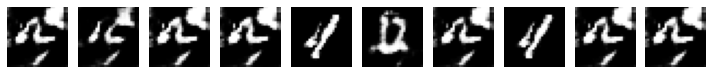

12900 [D loss: 0.002753, acc.: 100.00%] [G loss: 3.859818]
12901 [D loss: 0.001789, acc.: 100.00%] [G loss: 5.207247]
12902 [D loss: 0.008301, acc.: 99.22%] [G loss: 4.468528]
12903 [D loss: 0.000346, acc.: 100.00%] [G loss: 4.402247]
12904 [D loss: 0.005941, acc.: 100.00%] [G loss: 3.387552]
12905 [D loss: 0.000494, acc.: 100.00%] [G loss: 3.295413]
12906 [D loss: 0.031983, acc.: 98.44%] [G loss: 1.215236]
12907 [D loss: 0.047950, acc.: 98.44%] [G loss: 2.013946]
12908 [D loss: 0.001646, acc.: 100.00%] [G loss: 8.135110]
12909 [D loss: 0.005158, acc.: 100.00%] [G loss: 13.541685]
12910 [D loss: 0.038934, acc.: 99.22%] [G loss: 14.848280]
12911 [D loss: 0.017715, acc.: 99.22%] [G loss: 14.693051]
12912 [D loss: 0.002936, acc.: 100.00%] [G loss: 13.925083]
12913 [D loss: 0.065674, acc.: 96.09%] [G loss: 12.696445]
12914 [D loss: 0.029360, acc.: 98.44%] [G loss: 12.826668]
12915 [D loss: 0.005156, acc.: 100.00%] [G loss: 13.560677]
12916 [D loss: 0.001517, acc.: 100.00%] [G loss: 13.5388

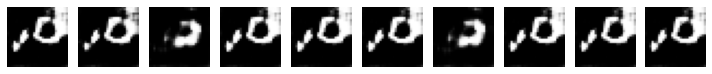

13000 [D loss: 0.009382, acc.: 100.00%] [G loss: 0.672382]
13001 [D loss: 0.030321, acc.: 99.22%] [G loss: 1.720907]
13002 [D loss: 0.003240, acc.: 100.00%] [G loss: 4.148515]
13003 [D loss: 0.008889, acc.: 99.22%] [G loss: 6.051525]
13004 [D loss: 0.000368, acc.: 100.00%] [G loss: 6.653400]
13005 [D loss: 0.000263, acc.: 100.00%] [G loss: 7.614540]
13006 [D loss: 0.024718, acc.: 99.22%] [G loss: 6.806078]
13007 [D loss: 0.002233, acc.: 100.00%] [G loss: 6.681595]
13008 [D loss: 0.005965, acc.: 100.00%] [G loss: 6.302383]
13009 [D loss: 0.019514, acc.: 98.44%] [G loss: 4.446288]
13010 [D loss: 0.006025, acc.: 100.00%] [G loss: 4.329023]
13011 [D loss: 0.020795, acc.: 100.00%] [G loss: 3.364335]
13012 [D loss: 0.012166, acc.: 99.22%] [G loss: 3.383135]
13013 [D loss: 0.002193, acc.: 100.00%] [G loss: 4.474898]
13014 [D loss: 0.001321, acc.: 100.00%] [G loss: 3.349261]
13015 [D loss: 0.008463, acc.: 99.22%] [G loss: 3.570246]
13016 [D loss: 0.018562, acc.: 99.22%] [G loss: 2.423532]
1301

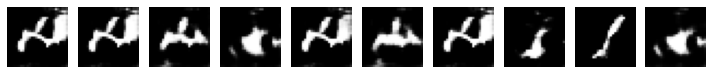

13100 [D loss: 0.027927, acc.: 99.22%] [G loss: 11.371927]
13101 [D loss: 0.016219, acc.: 99.22%] [G loss: 10.371643]
13102 [D loss: 0.017028, acc.: 99.22%] [G loss: 10.401107]
13103 [D loss: 0.006485, acc.: 100.00%] [G loss: 11.308380]
13104 [D loss: 0.001581, acc.: 100.00%] [G loss: 12.470426]
13105 [D loss: 0.006902, acc.: 99.22%] [G loss: 12.161776]
13106 [D loss: 0.002766, acc.: 100.00%] [G loss: 12.307891]
13107 [D loss: 0.030023, acc.: 99.22%] [G loss: 12.773112]
13108 [D loss: 0.004065, acc.: 100.00%] [G loss: 12.169114]
13109 [D loss: 0.001209, acc.: 100.00%] [G loss: 11.339941]
13110 [D loss: 0.015882, acc.: 99.22%] [G loss: 9.322597]
13111 [D loss: 0.009121, acc.: 100.00%] [G loss: 6.909375]
13112 [D loss: 0.009124, acc.: 99.22%] [G loss: 5.364652]
13113 [D loss: 0.006494, acc.: 100.00%] [G loss: 3.780551]
13114 [D loss: 0.002305, acc.: 100.00%] [G loss: 2.910441]
13115 [D loss: 0.000762, acc.: 100.00%] [G loss: 3.029428]
13116 [D loss: 0.003885, acc.: 100.00%] [G loss: 2.14

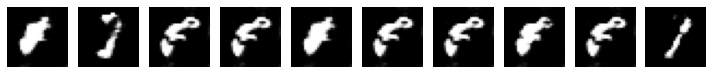

13200 [D loss: 0.242299, acc.: 91.41%] [G loss: 2.137014]
13201 [D loss: 0.000081, acc.: 100.00%] [G loss: 8.403609]
13202 [D loss: 0.048890, acc.: 98.44%] [G loss: 10.874632]
13203 [D loss: 0.207638, acc.: 95.31%] [G loss: 9.752579]
13204 [D loss: 0.065083, acc.: 97.66%] [G loss: 7.450951]
13205 [D loss: 0.078179, acc.: 97.66%] [G loss: 3.865680]
13206 [D loss: 0.007300, acc.: 100.00%] [G loss: 1.831803]
13207 [D loss: 0.007893, acc.: 100.00%] [G loss: 0.894625]
13208 [D loss: 0.079346, acc.: 98.44%] [G loss: 1.309440]
13209 [D loss: 0.024102, acc.: 99.22%] [G loss: 2.409403]
13210 [D loss: 0.002586, acc.: 100.00%] [G loss: 4.939268]
13211 [D loss: 0.000149, acc.: 100.00%] [G loss: 5.862228]
13212 [D loss: 0.000126, acc.: 100.00%] [G loss: 8.065427]
13213 [D loss: 0.001717, acc.: 100.00%] [G loss: 9.285793]
13214 [D loss: 0.000342, acc.: 100.00%] [G loss: 9.790267]
13215 [D loss: 0.027553, acc.: 99.22%] [G loss: 9.018324]
13216 [D loss: 0.021589, acc.: 98.44%] [G loss: 7.847267]
13217

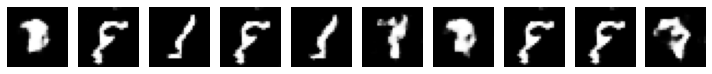

13300 [D loss: 0.016568, acc.: 99.22%] [G loss: 4.441912]
13301 [D loss: 0.005787, acc.: 100.00%] [G loss: 4.555084]
13302 [D loss: 0.019376, acc.: 99.22%] [G loss: 4.568352]
13303 [D loss: 0.001339, acc.: 100.00%] [G loss: 4.595802]
13304 [D loss: 0.019017, acc.: 99.22%] [G loss: 4.938912]
13305 [D loss: 0.011280, acc.: 99.22%] [G loss: 3.563054]
13306 [D loss: 0.002906, acc.: 100.00%] [G loss: 3.957812]
13307 [D loss: 0.008606, acc.: 100.00%] [G loss: 4.082577]
13308 [D loss: 0.001251, acc.: 100.00%] [G loss: 5.233729]
13309 [D loss: 0.005728, acc.: 100.00%] [G loss: 4.928699]
13310 [D loss: 0.003743, acc.: 100.00%] [G loss: 5.487828]
13311 [D loss: 0.000804, acc.: 100.00%] [G loss: 5.899931]
13312 [D loss: 0.061567, acc.: 98.44%] [G loss: 3.731713]
13313 [D loss: 0.028822, acc.: 98.44%] [G loss: 3.706083]
13314 [D loss: 0.010755, acc.: 100.00%] [G loss: 3.753849]
13315 [D loss: 0.038720, acc.: 98.44%] [G loss: 4.333373]
13316 [D loss: 0.000728, acc.: 100.00%] [G loss: 5.611683]
1331

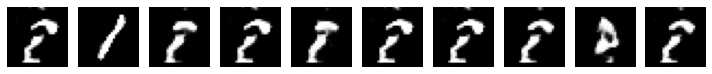

13400 [D loss: 0.030490, acc.: 99.22%] [G loss: 7.745433]
13401 [D loss: 0.002055, acc.: 100.00%] [G loss: 8.937969]
13402 [D loss: 0.033159, acc.: 97.66%] [G loss: 8.215893]
13403 [D loss: 0.014568, acc.: 99.22%] [G loss: 6.835526]
13404 [D loss: 0.000254, acc.: 100.00%] [G loss: 5.207871]
13405 [D loss: 0.001791, acc.: 100.00%] [G loss: 4.420244]
13406 [D loss: 0.010294, acc.: 100.00%] [G loss: 3.556437]
13407 [D loss: 0.009520, acc.: 99.22%] [G loss: 4.151399]
13408 [D loss: 0.001206, acc.: 100.00%] [G loss: 4.474961]
13409 [D loss: 0.004057, acc.: 100.00%] [G loss: 4.597479]
13410 [D loss: 0.023321, acc.: 99.22%] [G loss: 4.278202]
13411 [D loss: 0.002219, acc.: 100.00%] [G loss: 4.615513]
13412 [D loss: 0.002005, acc.: 100.00%] [G loss: 4.543811]
13413 [D loss: 0.002141, acc.: 100.00%] [G loss: 4.340022]
13414 [D loss: 0.035650, acc.: 99.22%] [G loss: 3.491614]
13415 [D loss: 0.003572, acc.: 100.00%] [G loss: 3.728690]
13416 [D loss: 0.009912, acc.: 100.00%] [G loss: 3.625562]
134

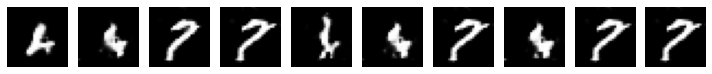

13500 [D loss: 0.027216, acc.: 98.44%] [G loss: 7.030472]
13501 [D loss: 0.031593, acc.: 98.44%] [G loss: 5.575366]
13502 [D loss: 0.076531, acc.: 99.22%] [G loss: 4.609165]
13503 [D loss: 0.013012, acc.: 99.22%] [G loss: 3.432682]
13504 [D loss: 0.022952, acc.: 99.22%] [G loss: 3.747280]
13505 [D loss: 0.001717, acc.: 100.00%] [G loss: 5.207537]
13506 [D loss: 0.029212, acc.: 98.44%] [G loss: 5.671920]
13507 [D loss: 0.002179, acc.: 100.00%] [G loss: 6.536272]
13508 [D loss: 0.007952, acc.: 100.00%] [G loss: 6.248574]
13509 [D loss: 0.054715, acc.: 98.44%] [G loss: 5.646980]
13510 [D loss: 0.003523, acc.: 100.00%] [G loss: 5.001078]
13511 [D loss: 0.003237, acc.: 100.00%] [G loss: 5.079819]
13512 [D loss: 0.003181, acc.: 100.00%] [G loss: 3.682520]
13513 [D loss: 0.002399, acc.: 100.00%] [G loss: 4.617314]
13514 [D loss: 0.005373, acc.: 100.00%] [G loss: 4.699606]
13515 [D loss: 0.018063, acc.: 99.22%] [G loss: 5.430708]
13516 [D loss: 0.002112, acc.: 100.00%] [G loss: 6.437235]
13517

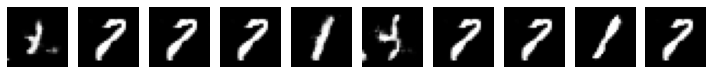

13600 [D loss: 0.045202, acc.: 98.44%] [G loss: 5.546019]
13601 [D loss: 0.021792, acc.: 99.22%] [G loss: 3.872293]
13602 [D loss: 0.065490, acc.: 97.66%] [G loss: 4.335157]
13603 [D loss: 0.020680, acc.: 99.22%] [G loss: 6.360554]
13604 [D loss: 0.004646, acc.: 100.00%] [G loss: 8.044650]
13605 [D loss: 0.013761, acc.: 99.22%] [G loss: 8.924906]
13606 [D loss: 0.003238, acc.: 100.00%] [G loss: 9.280942]
13607 [D loss: 0.038465, acc.: 99.22%] [G loss: 8.485396]
13608 [D loss: 0.001391, acc.: 100.00%] [G loss: 8.956186]
13609 [D loss: 0.051876, acc.: 98.44%] [G loss: 6.769545]
13610 [D loss: 0.012295, acc.: 100.00%] [G loss: 6.197049]
13611 [D loss: 0.035159, acc.: 99.22%] [G loss: 6.330193]
13612 [D loss: 0.021608, acc.: 99.22%] [G loss: 6.962822]
13613 [D loss: 0.004285, acc.: 100.00%] [G loss: 7.988929]
13614 [D loss: 0.001531, acc.: 100.00%] [G loss: 8.136284]
13615 [D loss: 0.062494, acc.: 98.44%] [G loss: 8.318774]
13616 [D loss: 0.024910, acc.: 99.22%] [G loss: 7.165804]
13617 [D

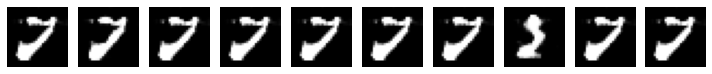

13700 [D loss: 0.008985, acc.: 100.00%] [G loss: 5.491490]
13701 [D loss: 0.007529, acc.: 100.00%] [G loss: 7.430369]
13702 [D loss: 0.025127, acc.: 98.44%] [G loss: 6.650483]
13703 [D loss: 0.012948, acc.: 99.22%] [G loss: 6.772128]
13704 [D loss: 0.036624, acc.: 97.66%] [G loss: 6.461065]
13705 [D loss: 0.109505, acc.: 97.66%] [G loss: 5.742390]
13706 [D loss: 0.032813, acc.: 99.22%] [G loss: 4.584415]
13707 [D loss: 0.004764, acc.: 100.00%] [G loss: 4.702879]
13708 [D loss: 0.110191, acc.: 96.09%] [G loss: 3.798396]
13709 [D loss: 0.056998, acc.: 98.44%] [G loss: 3.410135]
13710 [D loss: 0.021423, acc.: 99.22%] [G loss: 4.169158]
13711 [D loss: 0.020722, acc.: 99.22%] [G loss: 4.760909]
13712 [D loss: 0.020405, acc.: 99.22%] [G loss: 4.811702]
13713 [D loss: 0.010263, acc.: 100.00%] [G loss: 5.951045]
13714 [D loss: 0.001913, acc.: 100.00%] [G loss: 6.678441]
13715 [D loss: 0.002328, acc.: 100.00%] [G loss: 6.493325]
13716 [D loss: 0.000485, acc.: 100.00%] [G loss: 6.823919]
13717 [

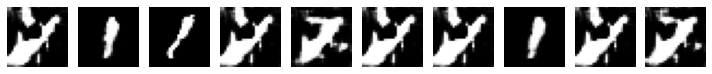

13800 [D loss: 0.003383, acc.: 100.00%] [G loss: 3.291651]
13801 [D loss: 0.000400, acc.: 100.00%] [G loss: 2.826463]
13802 [D loss: 0.015143, acc.: 99.22%] [G loss: 2.200838]
13803 [D loss: 0.004985, acc.: 100.00%] [G loss: 2.518902]
13804 [D loss: 0.002160, acc.: 100.00%] [G loss: 3.288725]
13805 [D loss: 0.043052, acc.: 98.44%] [G loss: 3.252424]
13806 [D loss: 0.000663, acc.: 100.00%] [G loss: 4.394187]
13807 [D loss: 0.000581, acc.: 100.00%] [G loss: 6.369016]
13808 [D loss: 0.055657, acc.: 98.44%] [G loss: 6.248819]
13809 [D loss: 0.030220, acc.: 99.22%] [G loss: 4.224703]
13810 [D loss: 0.043517, acc.: 98.44%] [G loss: 3.740878]
13811 [D loss: 0.023984, acc.: 98.44%] [G loss: 3.344876]
13812 [D loss: 0.002704, acc.: 100.00%] [G loss: 3.712650]
13813 [D loss: 0.021669, acc.: 99.22%] [G loss: 4.684589]
13814 [D loss: 0.040340, acc.: 98.44%] [G loss: 4.710787]
13815 [D loss: 0.012743, acc.: 100.00%] [G loss: 3.982953]
13816 [D loss: 0.003679, acc.: 100.00%] [G loss: 4.216506]
13817

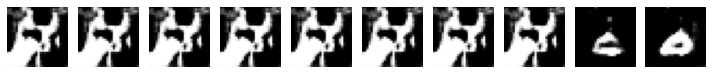

13900 [D loss: 0.043500, acc.: 97.66%] [G loss: 0.831109]
13901 [D loss: 0.024288, acc.: 98.44%] [G loss: 1.495034]
13902 [D loss: 0.039988, acc.: 98.44%] [G loss: 1.318806]
13903 [D loss: 0.029937, acc.: 99.22%] [G loss: 1.714310]
13904 [D loss: 0.004560, acc.: 100.00%] [G loss: 1.438491]
13905 [D loss: 0.020375, acc.: 99.22%] [G loss: 1.344775]
13906 [D loss: 0.015618, acc.: 99.22%] [G loss: 1.406799]
13907 [D loss: 0.017260, acc.: 99.22%] [G loss: 1.084065]
13908 [D loss: 0.046280, acc.: 98.44%] [G loss: 1.258282]
13909 [D loss: 0.009909, acc.: 100.00%] [G loss: 1.381839]
13910 [D loss: 0.040994, acc.: 98.44%] [G loss: 1.250954]
13911 [D loss: 0.033658, acc.: 98.44%] [G loss: 1.651050]
13912 [D loss: 0.022890, acc.: 99.22%] [G loss: 2.319081]
13913 [D loss: 0.058210, acc.: 98.44%] [G loss: 2.194823]
13914 [D loss: 0.035152, acc.: 99.22%] [G loss: 2.885870]
13915 [D loss: 0.003383, acc.: 100.00%] [G loss: 2.238283]
13916 [D loss: 0.063568, acc.: 98.44%] [G loss: 2.207362]
13917 [D lo

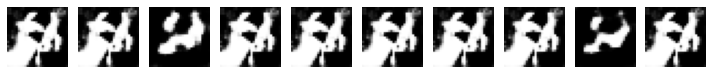

14000 [D loss: 0.001891, acc.: 100.00%] [G loss: 2.026231]
14001 [D loss: 0.002631, acc.: 100.00%] [G loss: 1.909499]
14002 [D loss: 0.007461, acc.: 99.22%] [G loss: 2.215293]
14003 [D loss: 0.001047, acc.: 100.00%] [G loss: 2.173373]
14004 [D loss: 0.001567, acc.: 100.00%] [G loss: 1.412470]
14005 [D loss: 0.005478, acc.: 100.00%] [G loss: 1.983161]
14006 [D loss: 0.001976, acc.: 100.00%] [G loss: 2.174896]
14007 [D loss: 0.004018, acc.: 100.00%] [G loss: 3.098229]
14008 [D loss: 0.047463, acc.: 99.22%] [G loss: 2.922667]
14009 [D loss: 0.025358, acc.: 99.22%] [G loss: 3.692691]
14010 [D loss: 0.020133, acc.: 99.22%] [G loss: 4.333656]
14011 [D loss: 0.028937, acc.: 98.44%] [G loss: 3.439378]
14012 [D loss: 0.037126, acc.: 99.22%] [G loss: 3.058074]
14013 [D loss: 0.030194, acc.: 99.22%] [G loss: 2.816429]
14014 [D loss: 0.001531, acc.: 100.00%] [G loss: 2.047041]
14015 [D loss: 0.013243, acc.: 99.22%] [G loss: 2.588906]
14016 [D loss: 0.019952, acc.: 99.22%] [G loss: 3.984429]
14017 

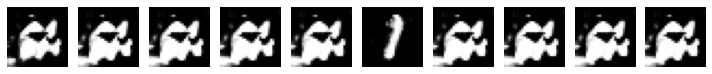

14100 [D loss: 0.032341, acc.: 98.44%] [G loss: 0.650869]
14101 [D loss: 0.019924, acc.: 99.22%] [G loss: 1.263428]
14102 [D loss: 0.003065, acc.: 100.00%] [G loss: 1.684135]
14103 [D loss: 0.003322, acc.: 100.00%] [G loss: 2.526045]
14104 [D loss: 0.049704, acc.: 98.44%] [G loss: 2.368512]
14105 [D loss: 0.042774, acc.: 99.22%] [G loss: 1.710119]
14106 [D loss: 0.012156, acc.: 99.22%] [G loss: 1.618114]
14107 [D loss: 0.010519, acc.: 99.22%] [G loss: 0.852910]
14108 [D loss: 0.041425, acc.: 99.22%] [G loss: 0.588971]
14109 [D loss: 0.024137, acc.: 99.22%] [G loss: 0.404090]
14110 [D loss: 0.010113, acc.: 100.00%] [G loss: 0.446414]
14111 [D loss: 0.007255, acc.: 100.00%] [G loss: 0.631041]
14112 [D loss: 0.013501, acc.: 100.00%] [G loss: 0.955392]
14113 [D loss: 0.007366, acc.: 100.00%] [G loss: 0.821227]
14114 [D loss: 0.005592, acc.: 100.00%] [G loss: 1.277744]
14115 [D loss: 0.010769, acc.: 100.00%] [G loss: 0.948019]
14116 [D loss: 0.002743, acc.: 100.00%] [G loss: 0.952640]
14117

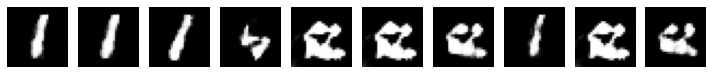

14200 [D loss: 0.013834, acc.: 99.22%] [G loss: 6.112990]
14201 [D loss: 0.004085, acc.: 100.00%] [G loss: 6.831676]
14202 [D loss: 0.045683, acc.: 97.66%] [G loss: 6.487266]
14203 [D loss: 0.001702, acc.: 100.00%] [G loss: 6.625872]
14204 [D loss: 0.000607, acc.: 100.00%] [G loss: 6.153806]
14205 [D loss: 0.044387, acc.: 98.44%] [G loss: 5.176395]
14206 [D loss: 0.006667, acc.: 100.00%] [G loss: 4.511570]
14207 [D loss: 0.021180, acc.: 99.22%] [G loss: 4.341483]
14208 [D loss: 0.004217, acc.: 100.00%] [G loss: 4.775463]
14209 [D loss: 0.008880, acc.: 100.00%] [G loss: 5.423917]
14210 [D loss: 0.020410, acc.: 99.22%] [G loss: 5.644197]
14211 [D loss: 0.003296, acc.: 100.00%] [G loss: 5.059961]
14212 [D loss: 0.015180, acc.: 99.22%] [G loss: 4.250177]
14213 [D loss: 0.012246, acc.: 99.22%] [G loss: 3.561406]
14214 [D loss: 0.004364, acc.: 100.00%] [G loss: 3.594332]
14215 [D loss: 0.007424, acc.: 100.00%] [G loss: 3.919599]
14216 [D loss: 0.033615, acc.: 99.22%] [G loss: 3.923367]
14217

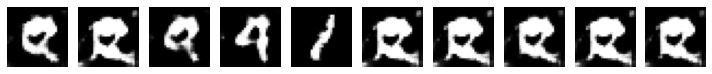

14300 [D loss: 0.000744, acc.: 100.00%] [G loss: 3.552495]
14301 [D loss: 0.040423, acc.: 99.22%] [G loss: 3.989286]
14302 [D loss: 0.010651, acc.: 99.22%] [G loss: 4.191745]
14303 [D loss: 0.075140, acc.: 97.66%] [G loss: 3.134604]
14304 [D loss: 0.063777, acc.: 98.44%] [G loss: 1.221853]
14305 [D loss: 0.006008, acc.: 100.00%] [G loss: 0.883874]
14306 [D loss: 0.032116, acc.: 99.22%] [G loss: 0.514253]
14307 [D loss: 0.007689, acc.: 99.22%] [G loss: 0.650188]
14308 [D loss: 0.047561, acc.: 99.22%] [G loss: 0.627753]
14309 [D loss: 0.018339, acc.: 99.22%] [G loss: 0.603937]
14310 [D loss: 0.002869, acc.: 100.00%] [G loss: 0.912469]
14311 [D loss: 0.002508, acc.: 100.00%] [G loss: 1.082056]
14312 [D loss: 0.008714, acc.: 100.00%] [G loss: 1.137175]
14313 [D loss: 0.004599, acc.: 100.00%] [G loss: 1.155404]
14314 [D loss: 0.002282, acc.: 100.00%] [G loss: 1.409807]
14315 [D loss: 0.002207, acc.: 100.00%] [G loss: 1.006711]
14316 [D loss: 0.038745, acc.: 98.44%] [G loss: 0.913515]
14317 

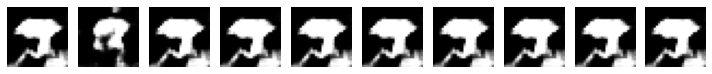

14400 [D loss: 0.015844, acc.: 99.22%] [G loss: 1.386673]
14401 [D loss: 0.061056, acc.: 99.22%] [G loss: 0.833570]
14402 [D loss: 0.035310, acc.: 97.66%] [G loss: 0.798958]
14403 [D loss: 0.019467, acc.: 98.44%] [G loss: 1.031603]
14404 [D loss: 0.017499, acc.: 99.22%] [G loss: 1.345218]
14405 [D loss: 0.011145, acc.: 99.22%] [G loss: 1.650037]
14406 [D loss: 0.044353, acc.: 99.22%] [G loss: 1.735803]
14407 [D loss: 0.012708, acc.: 99.22%] [G loss: 1.474848]
14408 [D loss: 0.013656, acc.: 99.22%] [G loss: 1.548707]
14409 [D loss: 0.003360, acc.: 100.00%] [G loss: 0.894924]
14410 [D loss: 0.041713, acc.: 98.44%] [G loss: 0.966360]
14411 [D loss: 0.036245, acc.: 98.44%] [G loss: 1.543550]
14412 [D loss: 0.018515, acc.: 99.22%] [G loss: 2.263954]
14413 [D loss: 0.049783, acc.: 98.44%] [G loss: 2.183513]
14414 [D loss: 0.007548, acc.: 100.00%] [G loss: 1.696319]
14415 [D loss: 0.044880, acc.: 97.66%] [G loss: 1.410348]
14416 [D loss: 0.027323, acc.: 99.22%] [G loss: 1.334059]
14417 [D los

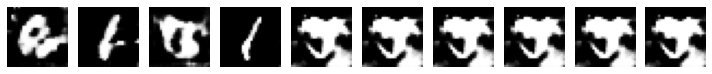

14500 [D loss: 0.002027, acc.: 100.00%] [G loss: 6.786406]
14501 [D loss: 0.037600, acc.: 98.44%] [G loss: 6.329271]
14502 [D loss: 0.010631, acc.: 99.22%] [G loss: 6.058760]
14503 [D loss: 0.028693, acc.: 98.44%] [G loss: 6.289475]
14504 [D loss: 0.050277, acc.: 97.66%] [G loss: 5.863936]
14505 [D loss: 0.001370, acc.: 100.00%] [G loss: 7.834892]
14506 [D loss: 0.004443, acc.: 100.00%] [G loss: 7.391422]
14507 [D loss: 0.004440, acc.: 100.00%] [G loss: 7.843126]
14508 [D loss: 0.050615, acc.: 99.22%] [G loss: 7.234621]
14509 [D loss: 0.000899, acc.: 100.00%] [G loss: 7.177330]
14510 [D loss: 0.038402, acc.: 98.44%] [G loss: 6.530073]
14511 [D loss: 0.002000, acc.: 100.00%] [G loss: 6.632171]
14512 [D loss: 0.012329, acc.: 100.00%] [G loss: 6.351502]
14513 [D loss: 0.006835, acc.: 100.00%] [G loss: 6.780599]
14514 [D loss: 0.000540, acc.: 100.00%] [G loss: 6.803420]
14515 [D loss: 0.010774, acc.: 99.22%] [G loss: 5.741485]
14516 [D loss: 0.000851, acc.: 100.00%] [G loss: 5.410866]
1451

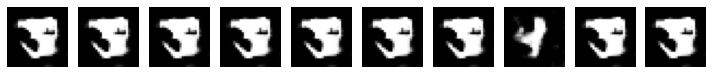

14600 [D loss: 0.018599, acc.: 98.44%] [G loss: 3.861746]
14601 [D loss: 0.000605, acc.: 100.00%] [G loss: 3.176663]
14602 [D loss: 0.019639, acc.: 99.22%] [G loss: 2.191402]
14603 [D loss: 0.018881, acc.: 100.00%] [G loss: 3.758150]
14604 [D loss: 0.063717, acc.: 98.44%] [G loss: 4.352357]
14605 [D loss: 0.009138, acc.: 99.22%] [G loss: 5.198030]
14606 [D loss: 0.001997, acc.: 100.00%] [G loss: 5.682928]
14607 [D loss: 0.021502, acc.: 99.22%] [G loss: 5.274814]
14608 [D loss: 0.014577, acc.: 99.22%] [G loss: 6.262421]
14609 [D loss: 0.025445, acc.: 99.22%] [G loss: 4.125046]
14610 [D loss: 0.008538, acc.: 100.00%] [G loss: 3.810946]
14611 [D loss: 0.023135, acc.: 99.22%] [G loss: 2.112316]
14612 [D loss: 0.044430, acc.: 97.66%] [G loss: 3.326449]
14613 [D loss: 0.007131, acc.: 100.00%] [G loss: 6.008180]
14614 [D loss: 0.044201, acc.: 99.22%] [G loss: 7.815749]
14615 [D loss: 0.003561, acc.: 100.00%] [G loss: 9.395413]
14616 [D loss: 0.004909, acc.: 100.00%] [G loss: 9.738724]
14617 [

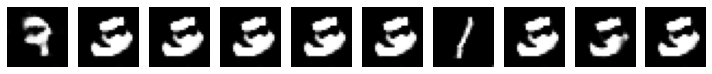

14700 [D loss: 0.003818, acc.: 100.00%] [G loss: 2.874214]
14701 [D loss: 0.002120, acc.: 100.00%] [G loss: 2.697354]
14702 [D loss: 0.042143, acc.: 98.44%] [G loss: 2.541641]
14703 [D loss: 0.050709, acc.: 98.44%] [G loss: 1.497113]
14704 [D loss: 0.015547, acc.: 99.22%] [G loss: 1.648422]
14705 [D loss: 0.008725, acc.: 100.00%] [G loss: 2.276565]
14706 [D loss: 0.003668, acc.: 100.00%] [G loss: 2.775293]
14707 [D loss: 0.007947, acc.: 99.22%] [G loss: 3.357344]
14708 [D loss: 0.001776, acc.: 100.00%] [G loss: 3.698025]
14709 [D loss: 0.011163, acc.: 99.22%] [G loss: 4.008919]
14710 [D loss: 0.006430, acc.: 99.22%] [G loss: 3.660554]
14711 [D loss: 0.002136, acc.: 100.00%] [G loss: 2.925584]
14712 [D loss: 0.082201, acc.: 97.66%] [G loss: 1.241643]
14713 [D loss: 0.005379, acc.: 100.00%] [G loss: 0.683746]
14714 [D loss: 0.056533, acc.: 95.31%] [G loss: 1.088796]
14715 [D loss: 0.037919, acc.: 99.22%] [G loss: 1.795312]
14716 [D loss: 0.001920, acc.: 100.00%] [G loss: 2.984204]
14717 

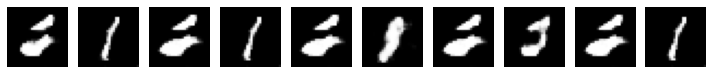

14800 [D loss: 0.001406, acc.: 100.00%] [G loss: 6.050544]
14801 [D loss: 0.005605, acc.: 100.00%] [G loss: 6.797210]
14802 [D loss: 0.005417, acc.: 100.00%] [G loss: 6.728256]
14803 [D loss: 0.003795, acc.: 100.00%] [G loss: 7.361503]
14804 [D loss: 0.053003, acc.: 98.44%] [G loss: 6.224892]
14805 [D loss: 0.002632, acc.: 100.00%] [G loss: 5.756158]
14806 [D loss: 0.016003, acc.: 100.00%] [G loss: 5.606693]
14807 [D loss: 0.017769, acc.: 99.22%] [G loss: 5.111565]
14808 [D loss: 0.006290, acc.: 100.00%] [G loss: 4.174904]
14809 [D loss: 0.025376, acc.: 98.44%] [G loss: 4.508873]
14810 [D loss: 0.000355, acc.: 100.00%] [G loss: 4.534500]
14811 [D loss: 0.056776, acc.: 98.44%] [G loss: 3.062925]
14812 [D loss: 0.096114, acc.: 97.66%] [G loss: 1.521922]
14813 [D loss: 0.036362, acc.: 98.44%] [G loss: 0.652621]
14814 [D loss: 0.042807, acc.: 98.44%] [G loss: 0.748061]
14815 [D loss: 0.038119, acc.: 98.44%] [G loss: 1.396215]
14816 [D loss: 0.005506, acc.: 100.00%] [G loss: 2.591479]
14817

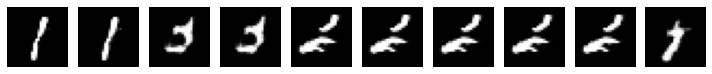

14900 [D loss: 0.105053, acc.: 97.66%] [G loss: 4.923691]
14901 [D loss: 0.001040, acc.: 100.00%] [G loss: 4.653688]
14902 [D loss: 0.053458, acc.: 99.22%] [G loss: 4.097479]
14903 [D loss: 0.007576, acc.: 99.22%] [G loss: 3.882043]
14904 [D loss: 0.000397, acc.: 100.00%] [G loss: 2.921581]
14905 [D loss: 0.005552, acc.: 100.00%] [G loss: 2.753344]
14906 [D loss: 0.003044, acc.: 100.00%] [G loss: 2.371161]
14907 [D loss: 0.003484, acc.: 100.00%] [G loss: 2.329253]
14908 [D loss: 0.031591, acc.: 98.44%] [G loss: 2.377150]
14909 [D loss: 0.011305, acc.: 99.22%] [G loss: 3.089061]
14910 [D loss: 0.004743, acc.: 100.00%] [G loss: 2.774919]
14911 [D loss: 0.003139, acc.: 100.00%] [G loss: 2.966069]
14912 [D loss: 0.021394, acc.: 99.22%] [G loss: 2.984884]
14913 [D loss: 0.001539, acc.: 100.00%] [G loss: 2.657368]
14914 [D loss: 0.015958, acc.: 99.22%] [G loss: 2.901996]
14915 [D loss: 0.001995, acc.: 100.00%] [G loss: 2.644833]
14916 [D loss: 0.018485, acc.: 99.22%] [G loss: 2.178843]
14917

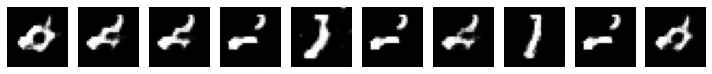

15000 [D loss: 0.008736, acc.: 99.22%] [G loss: 3.124573]
15001 [D loss: 0.000572, acc.: 100.00%] [G loss: 3.655851]
15002 [D loss: 0.024942, acc.: 98.44%] [G loss: 4.038223]
15003 [D loss: 0.000736, acc.: 100.00%] [G loss: 4.136725]
15004 [D loss: 0.001034, acc.: 100.00%] [G loss: 4.095295]
15005 [D loss: 0.005249, acc.: 100.00%] [G loss: 4.468101]
15006 [D loss: 0.009330, acc.: 100.00%] [G loss: 4.842266]
15007 [D loss: 0.002856, acc.: 100.00%] [G loss: 4.881357]
15008 [D loss: 0.047795, acc.: 99.22%] [G loss: 4.668937]
15009 [D loss: 0.034307, acc.: 99.22%] [G loss: 3.956042]
15010 [D loss: 0.043483, acc.: 99.22%] [G loss: 3.119548]
15011 [D loss: 0.085292, acc.: 96.88%] [G loss: 2.825196]
15012 [D loss: 0.015666, acc.: 99.22%] [G loss: 3.409165]
15013 [D loss: 0.013108, acc.: 99.22%] [G loss: 4.795613]
15014 [D loss: 0.024899, acc.: 98.44%] [G loss: 5.788317]
15015 [D loss: 0.031982, acc.: 99.22%] [G loss: 7.154226]
15016 [D loss: 0.028223, acc.: 98.44%] [G loss: 7.486225]
15017 [D

In [ ]:
gan=DCGAN()
gan.train(epochs=20000)


In [33]:
(x_train,y_train),(x_test,y_test)=datasets.mnist.load_data()
print(x_train.shape)

(60000, 28, 28)
